# LRP explanations for ML Synergy Models
Implemented using zennit: https://github.com/chr5tphr/zennit

In [1]:
#! pip install zennit

In [2]:
import os

os.chdir(os.path.abspath(os.path.join(os.getcwd(), "../..")))
print(os.getcwd())

c:\Users\ismyn\UNI\FU Berlin\SWP_Cancer\Drug-Inhibitor-Cancer-Treatment


We need to find the right rule for each model layer, let's examine it first

In [3]:
from explainability.utils import load_transynergy_model, load_biomining_model

model_trans = load_transynergy_model("external/drug_combination/trans_synergy/data/models/fold_test_model.pt") 
model_biomining = load_biomining_model("external/predicting_synergy_nn/outputs/models/final_f1.pt")

## Biomining

See "Biomining" paper: https://biodatamining.biomedcentral.com/articles/10.1186/s13040-024-00359-z

We apply **LRP rules** only to the **Linear** layers. BatchNorm layers are handled using `SequentialMergeBatchNorm`. **ReLU** activations are **ignored**, as indicated in the [Zennit documentation](https://zennit.readthedocs.io/en/0.4.4/how-to/use-rules-composites-and-canonizers.html).

For the LRP rules used in the Linear layers, we follow the methodology described in [this paper](https://iphome.hhi.de/samek/pdf/MonXAI19.pdf). Specifically The Gamma rules for all layers, to filter out noise as much as possible.

These choices are made in accordance with the recommendations provided in the literature.


### "Biomining"  Model architecture

In [4]:
print(model_biomining)

SynergyModel(
  (net): Sequential(
    (0): Linear(in_features=33, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=256, out_features=512, bias=True)
    (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=512, out_features=1, bias=True)
  )
)


## Explainations LRP for Biomining


In [5]:
import numpy as np
from explainability.data_utils import load_biomining_cell_line_data, load_biomining_data, load_biomining_drug_names
from explainability.explaination_config import ExplainationConfig

config = ExplainationConfig(
    paper="biomining",
)
cell_line_data = load_biomining_cell_line_data(split = 'test')
cell_line_data = np.concatenate([cell_line_data, cell_line_data], axis=0)
drug_name_a, drug_name_b = load_biomining_drug_names(split= 'test')
X, Y = load_biomining_data(split = 'test')

relevances = np.load("explainability/lrp/results/biomining_subsample_False/relevances.npy")
feature_names = config.feature_names


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Something strange is happening in the plots below.

You can see that the **same features from Drug A and Drug B do not hold the same relevance**, even though the prediction scores for the datapoints  
`(DRUG_A, DRUG_B, CELL_LINE)` and `(DRUG_B, DRUG_A, CELL_LINE)` are **averaged**.

This suggests an inconsistency in how feature relevance is attributed, despite the symmetry in scoring.


In [6]:
def normalize_and_rescale(arr):
    normed = arr / np.sum(np.abs(arr))
    return normed / np.max(np.abs(normed))

norm_relevances = normalize_and_rescale(relevances)


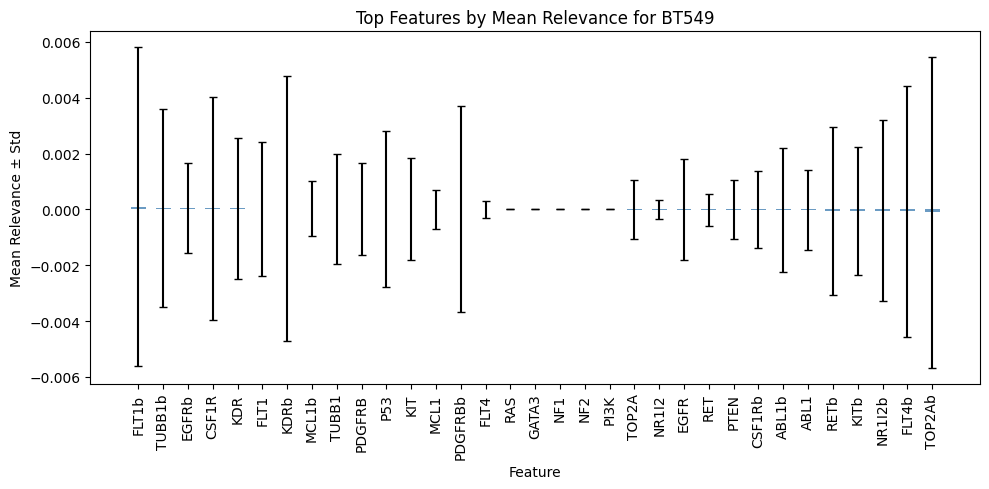

Number of samples for BT549: 6412


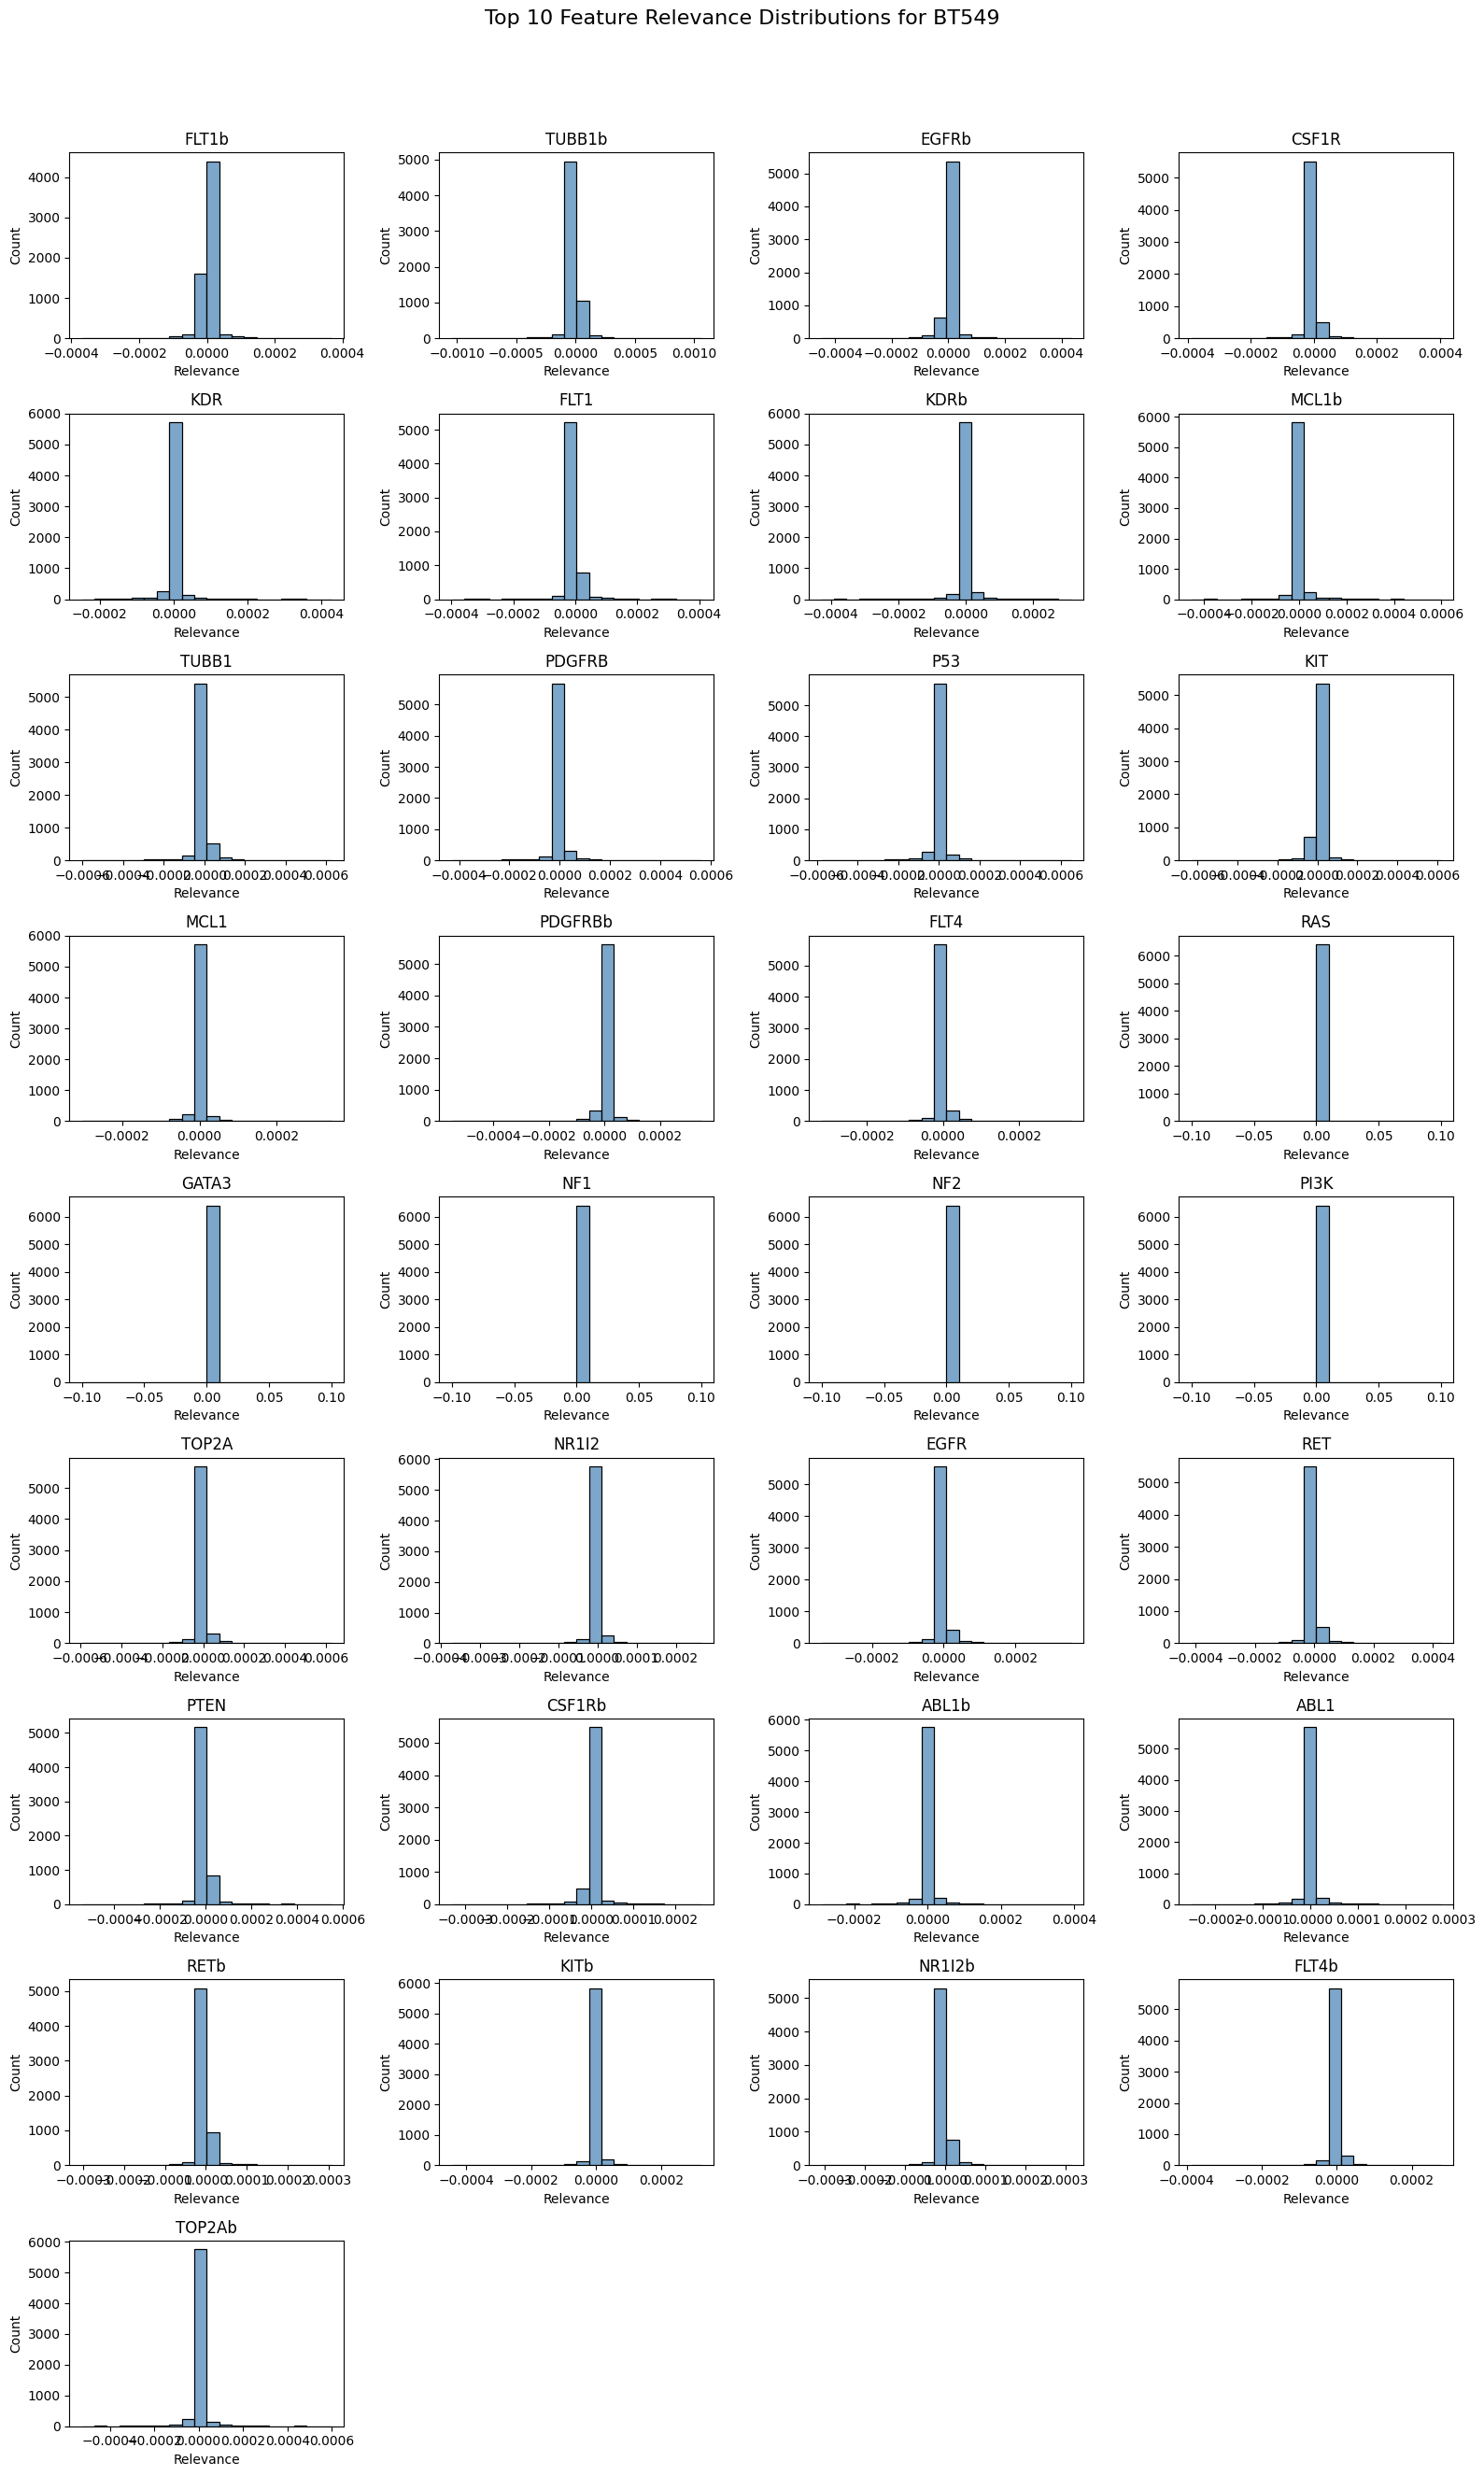

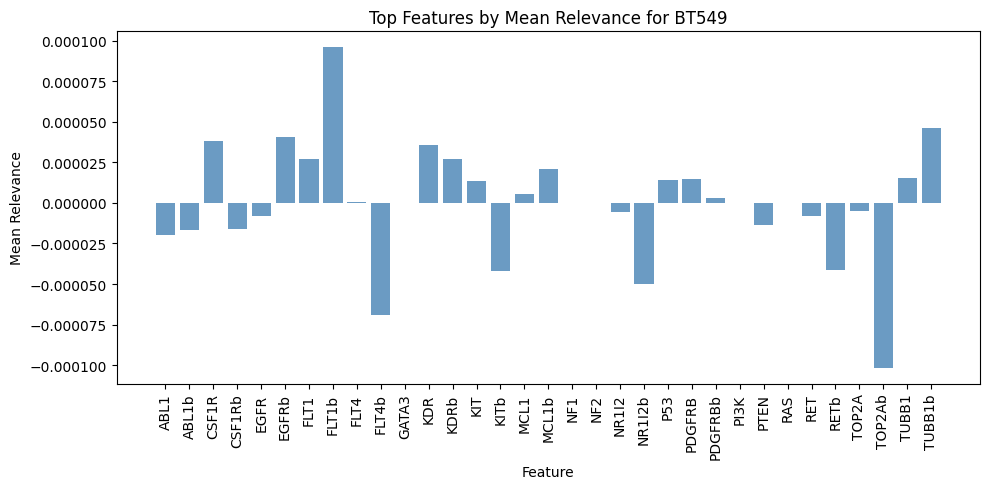

Number of samples for BT549: 6412


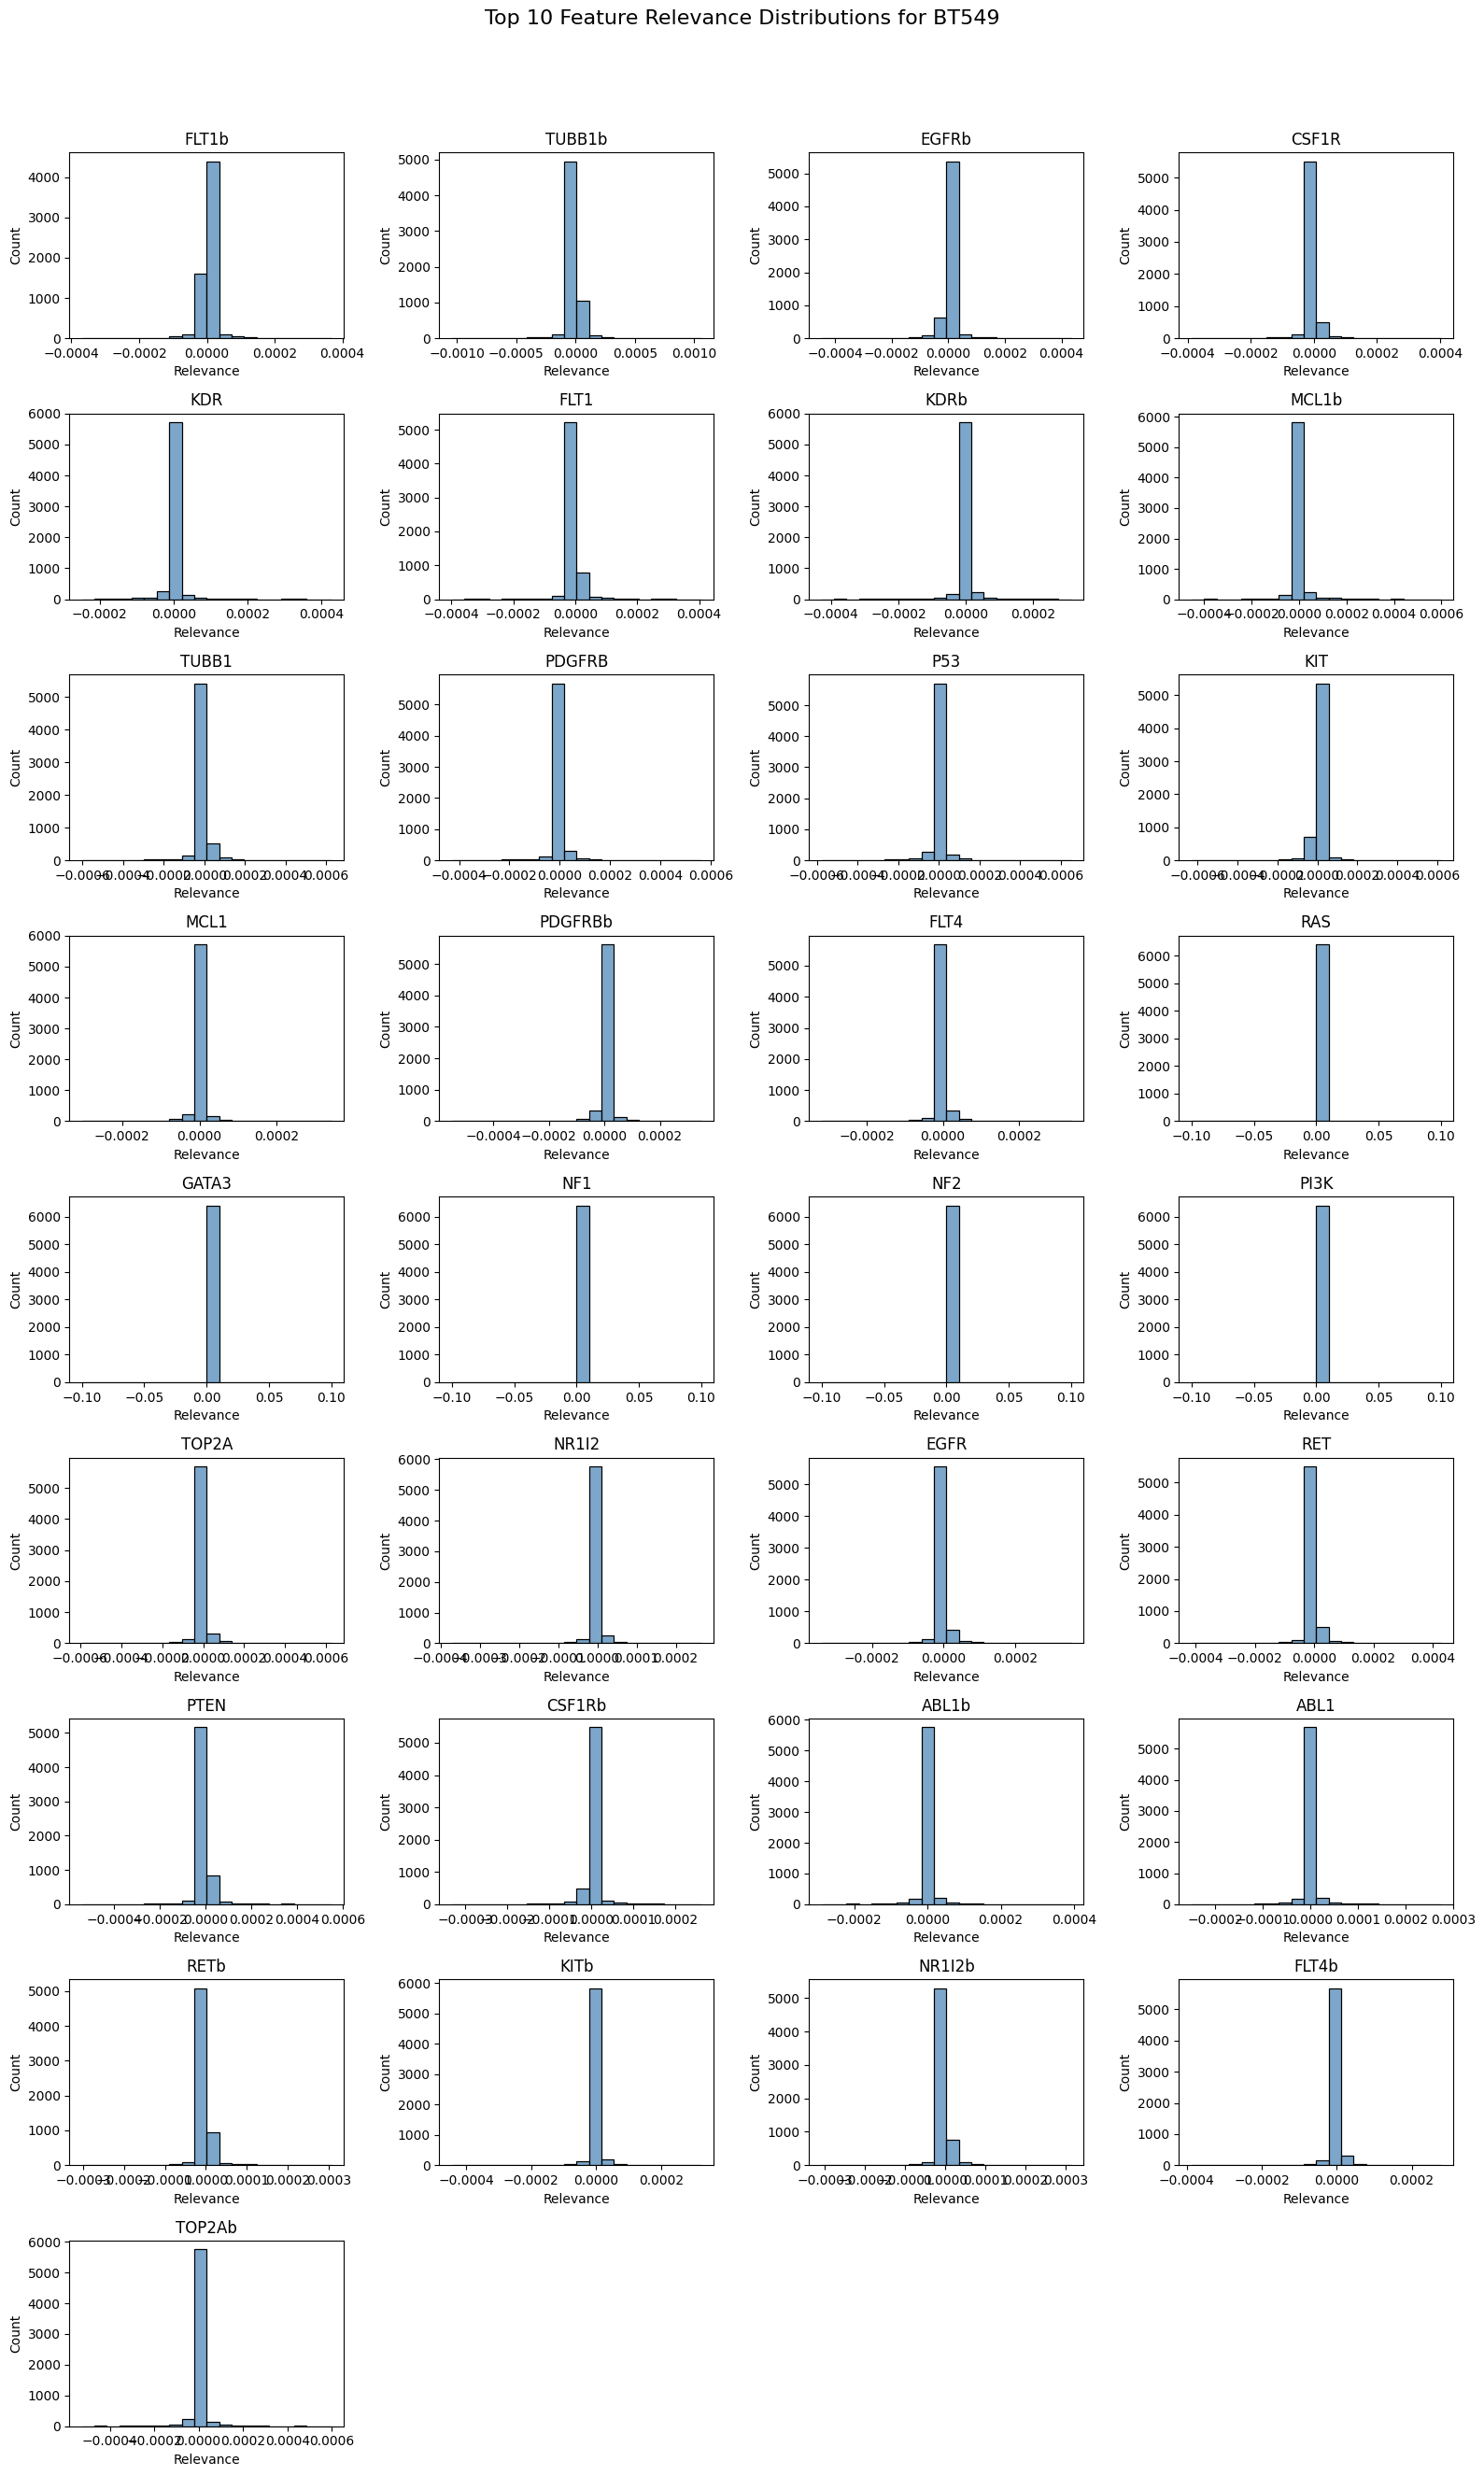

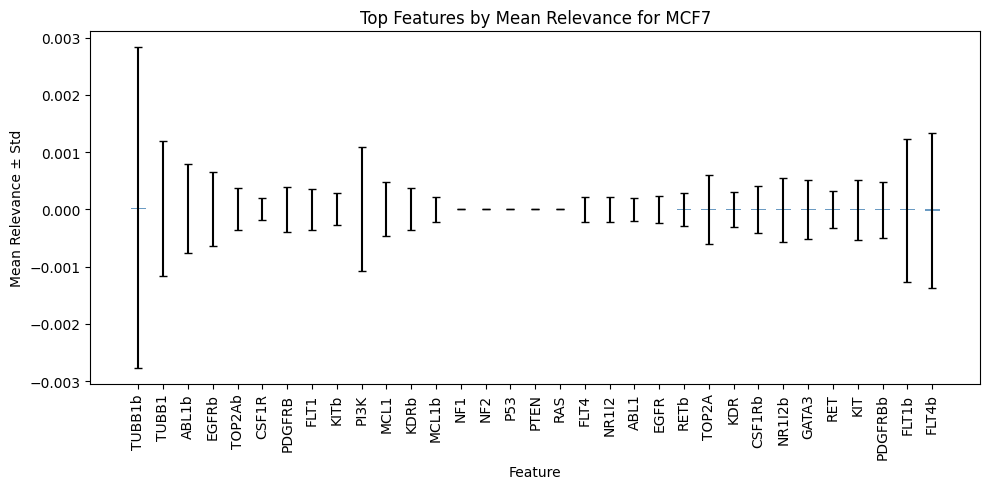

Number of samples for MCF7: 6484


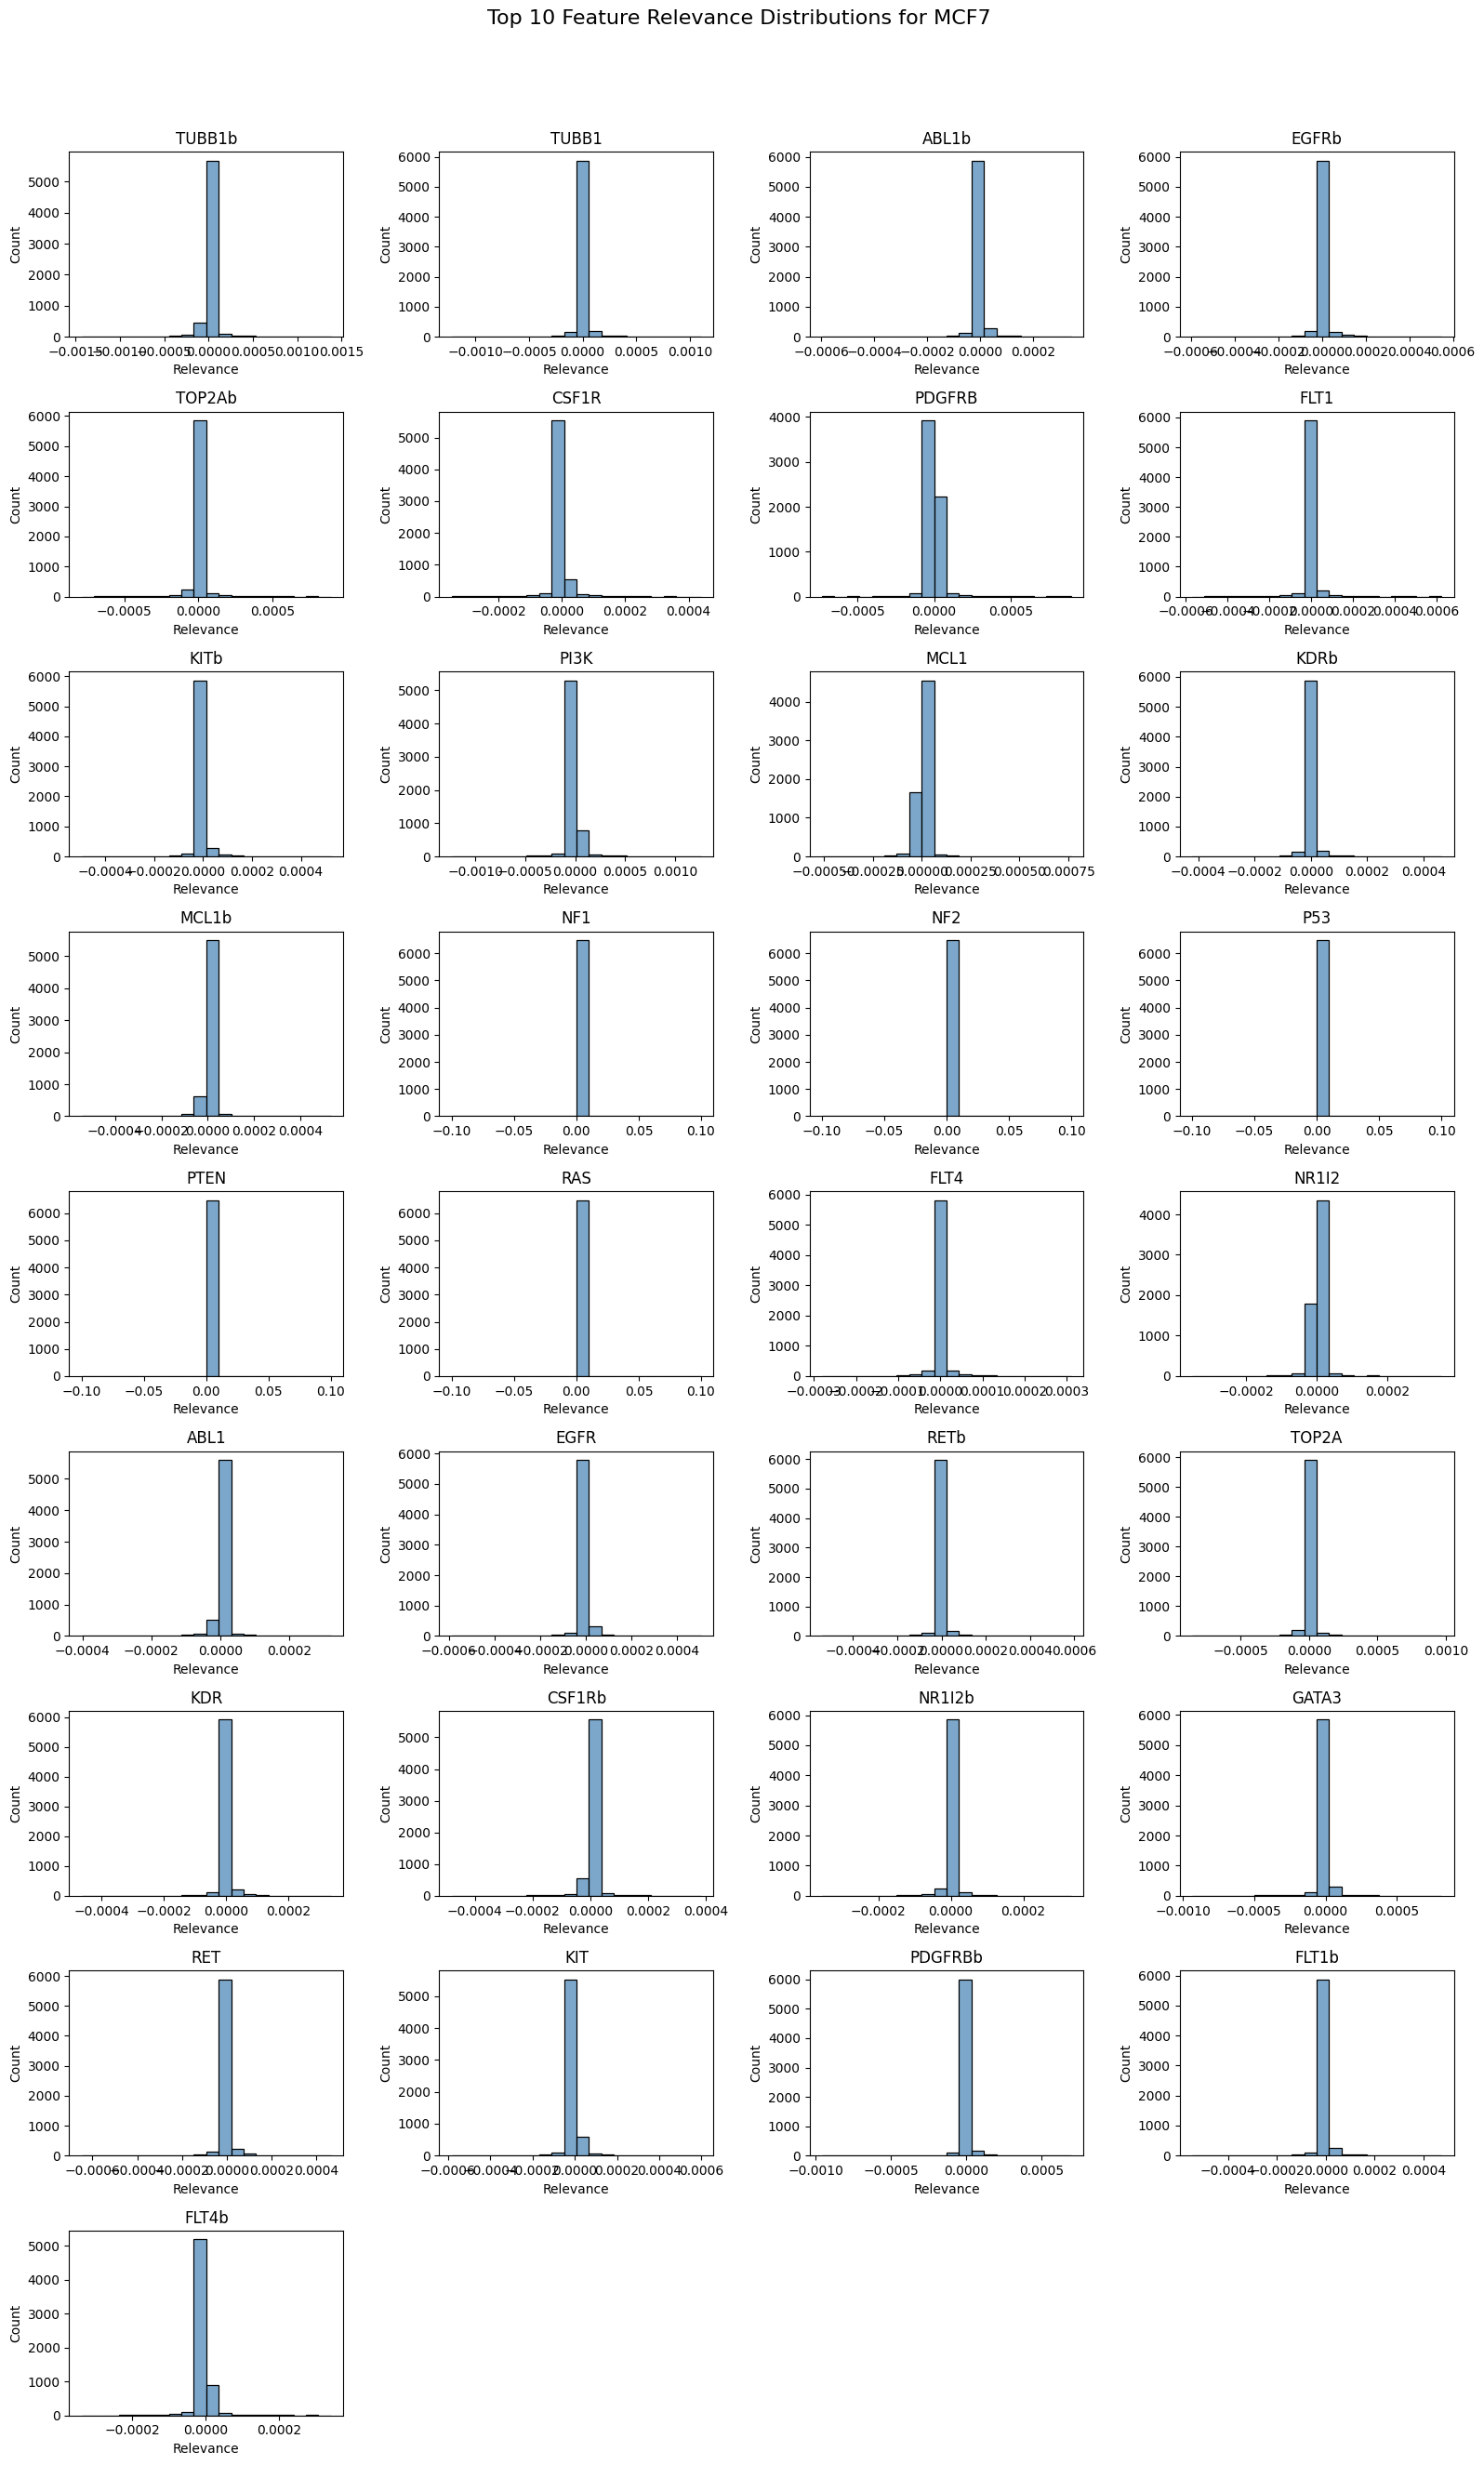

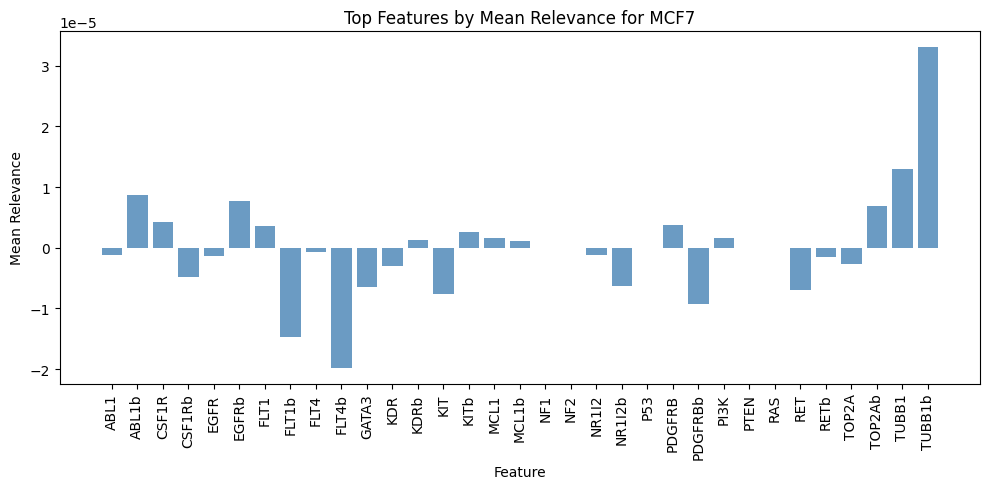

Number of samples for MCF7: 6484


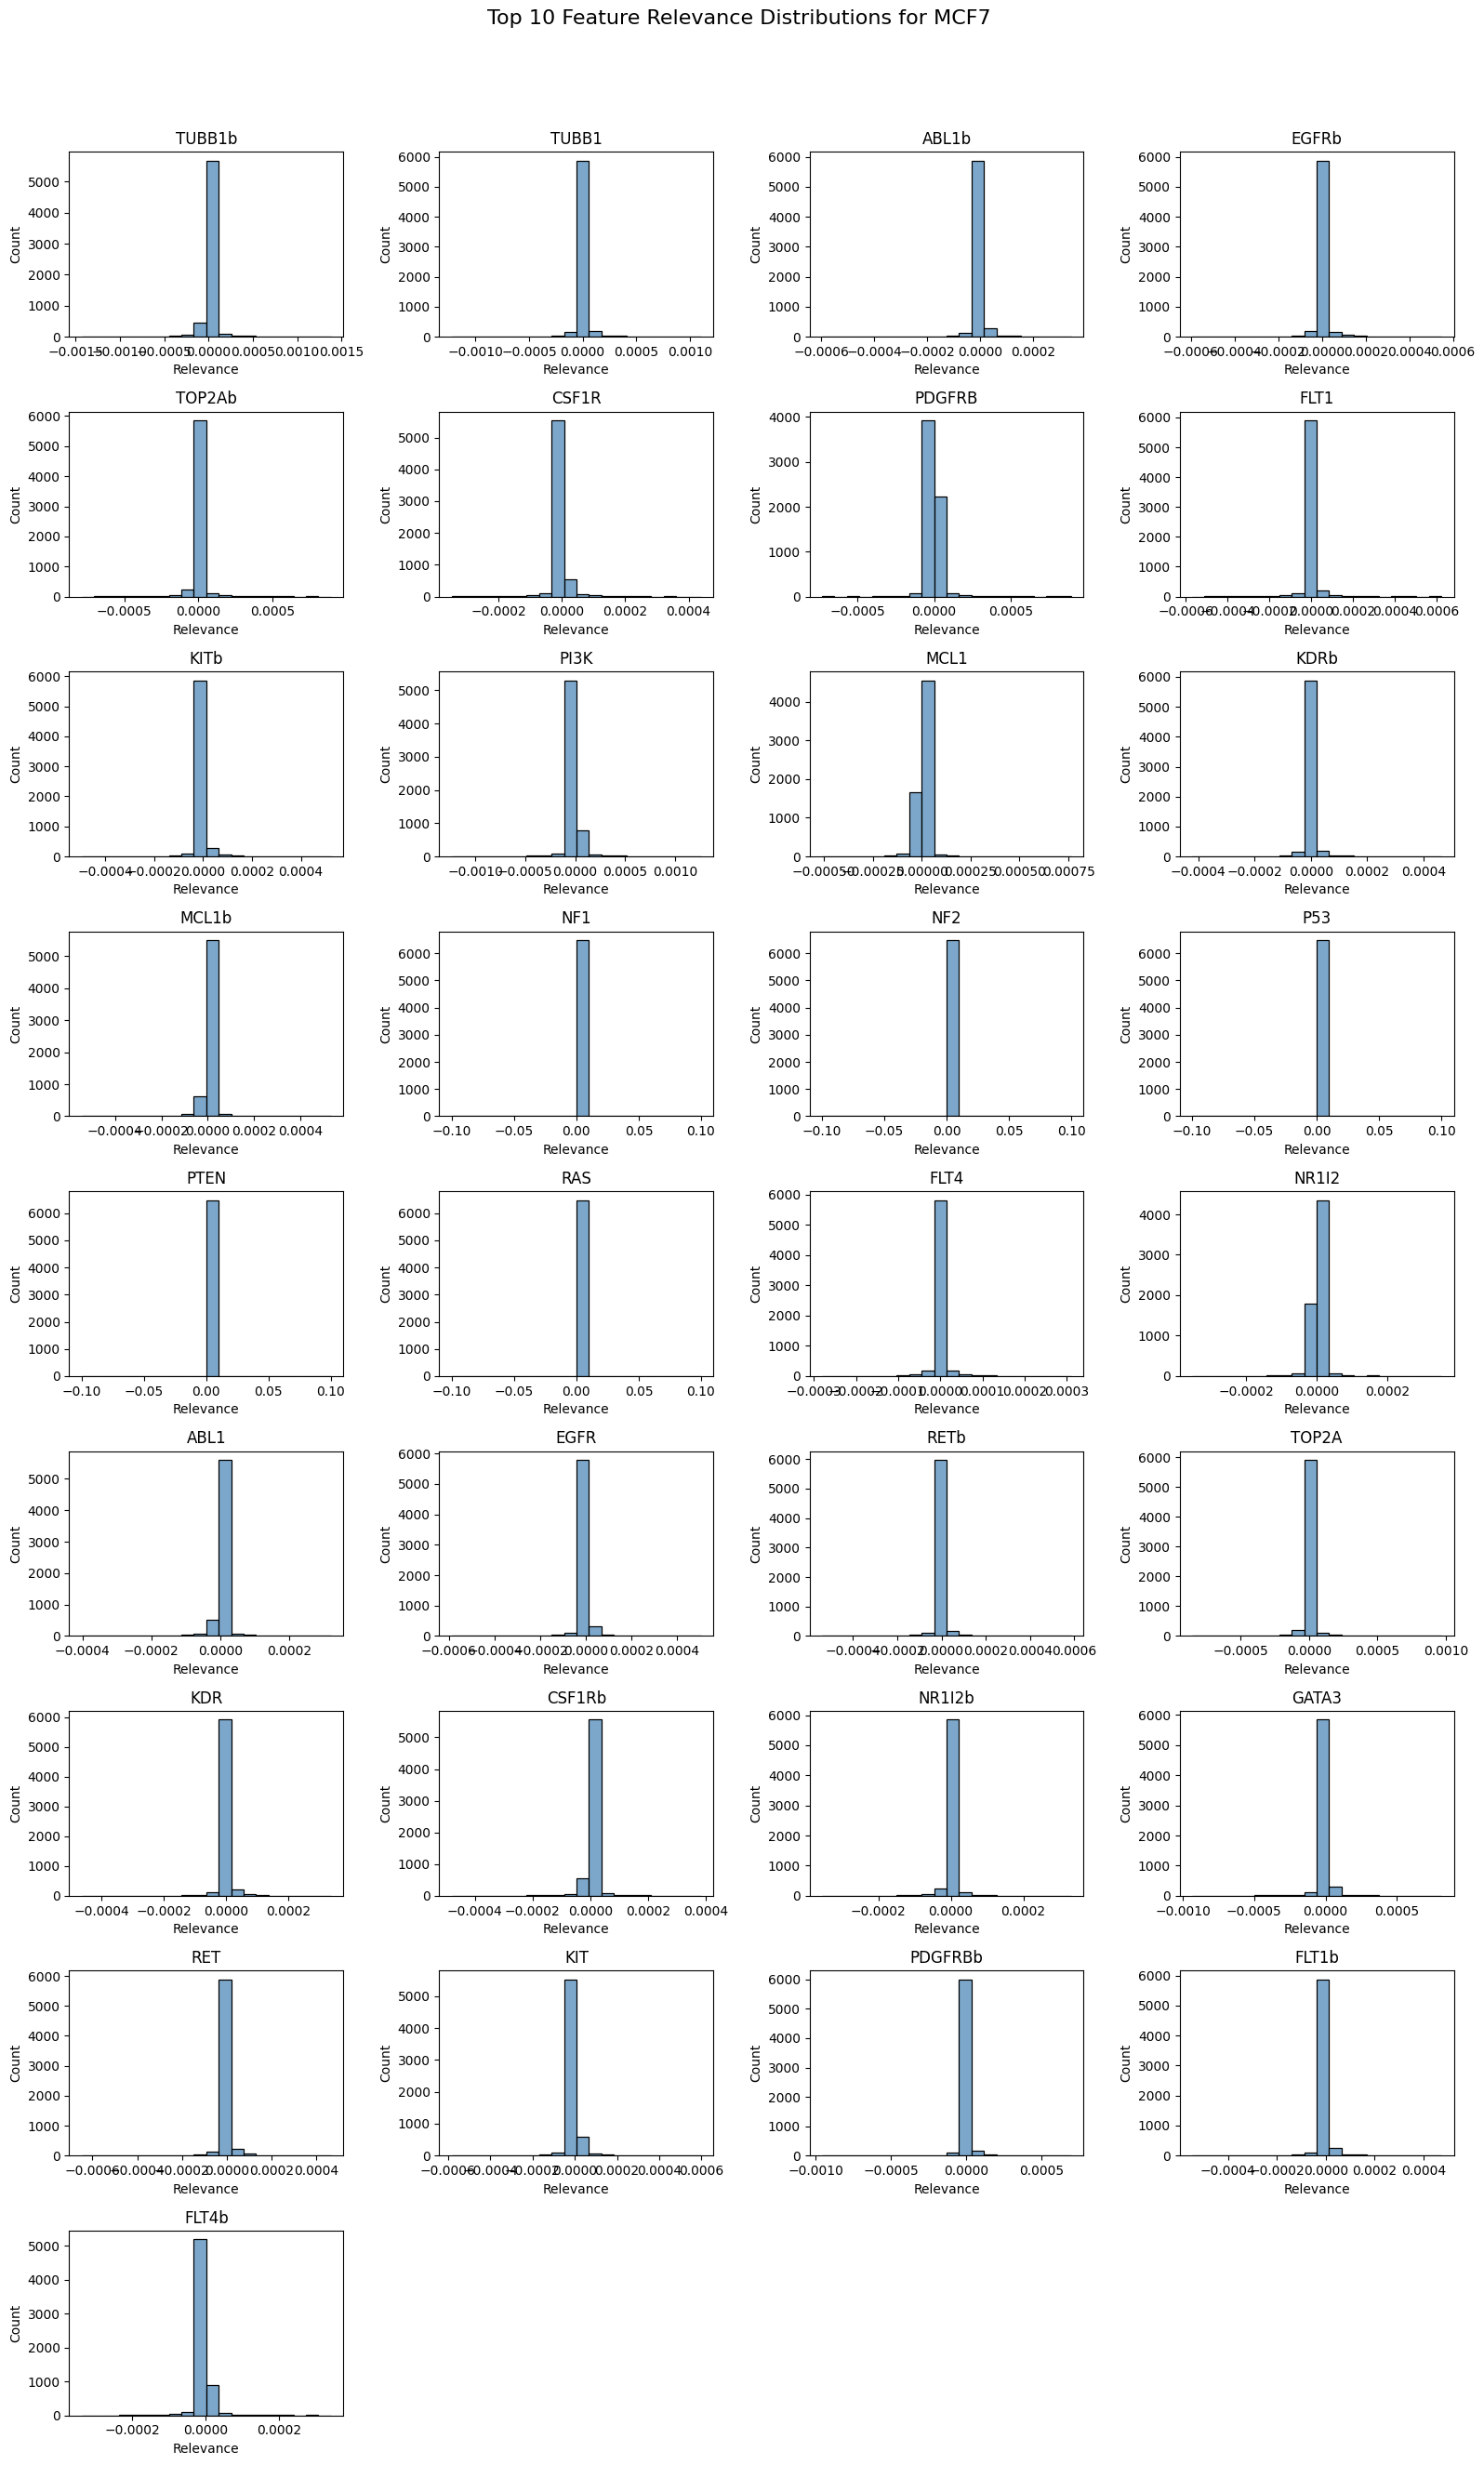

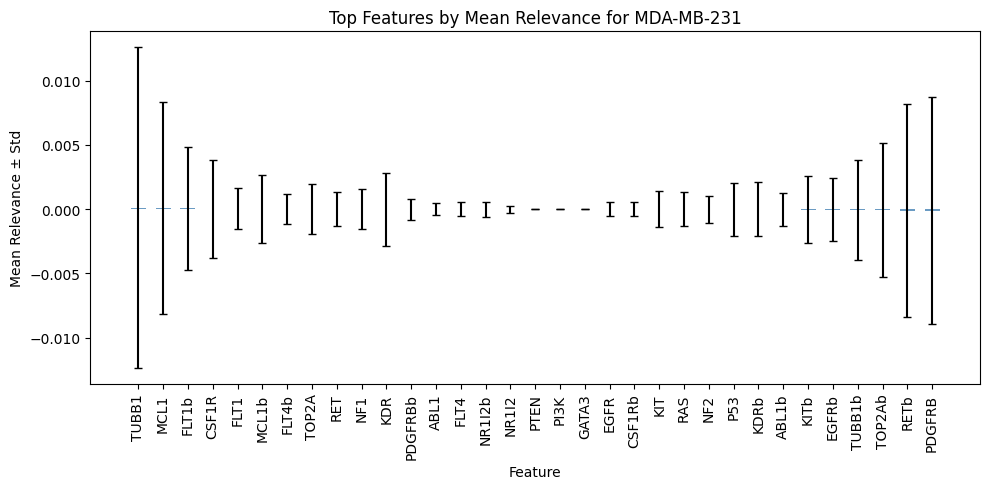

Number of samples for MDA-MB-231: 6476


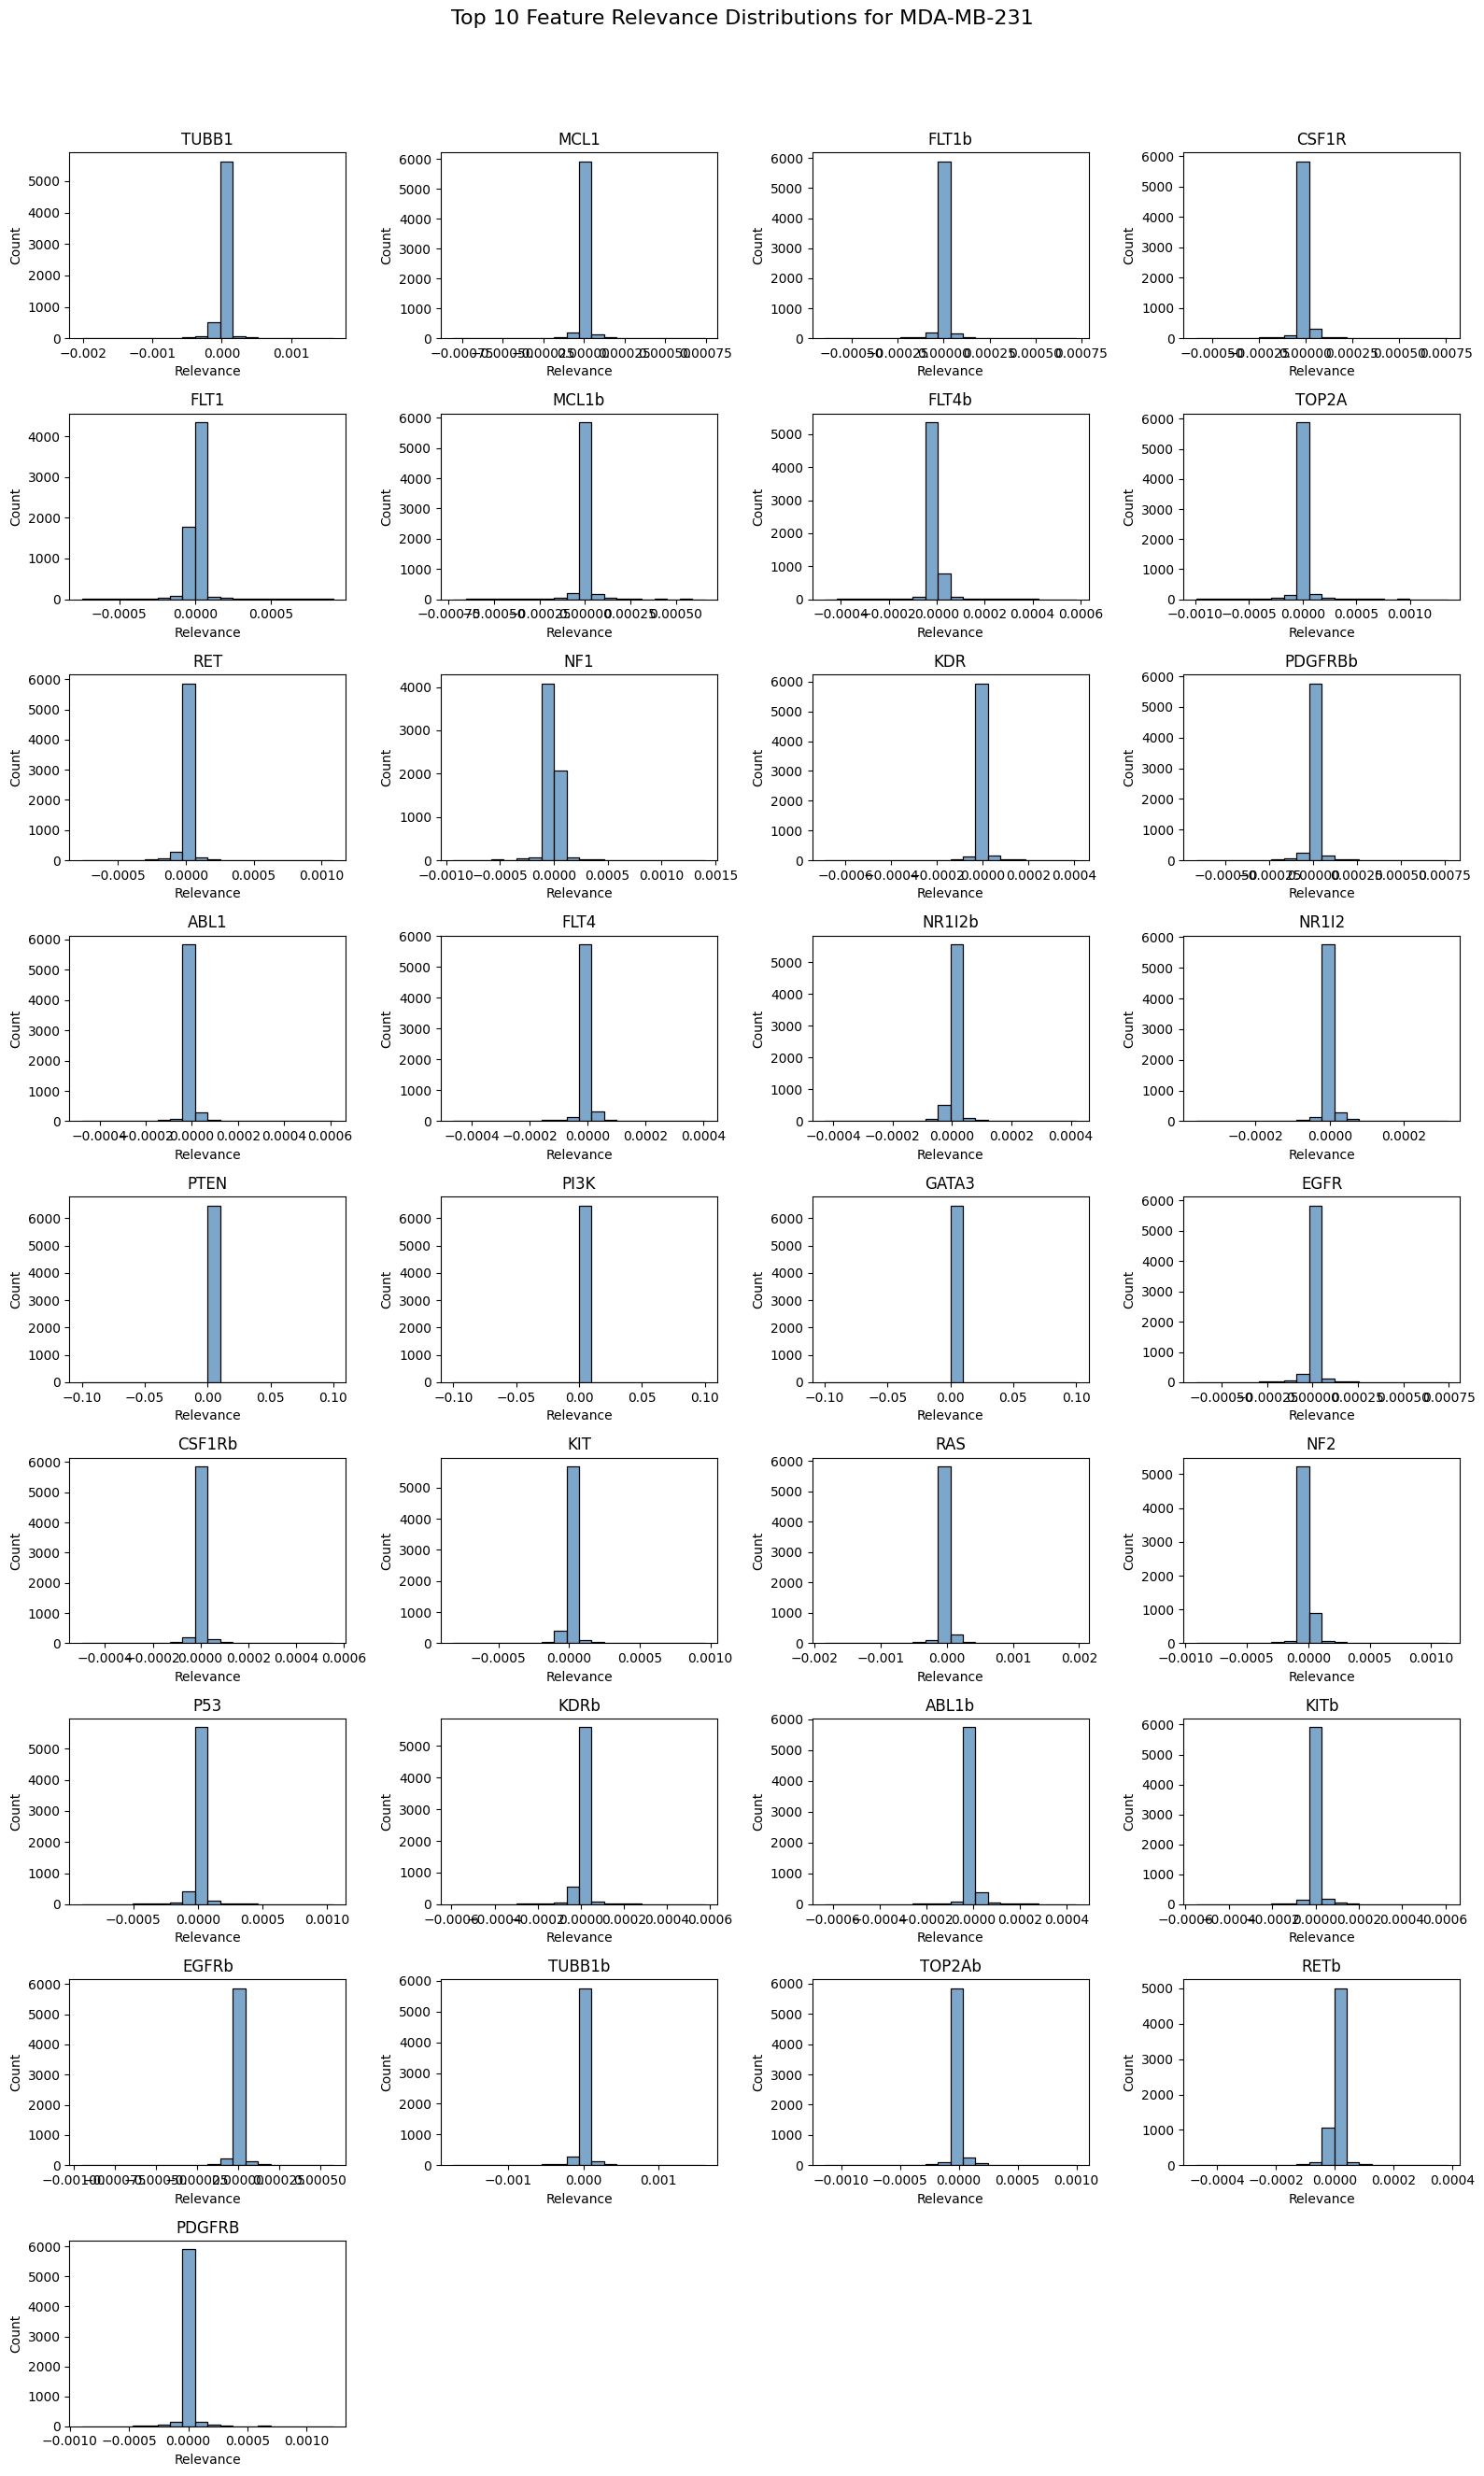

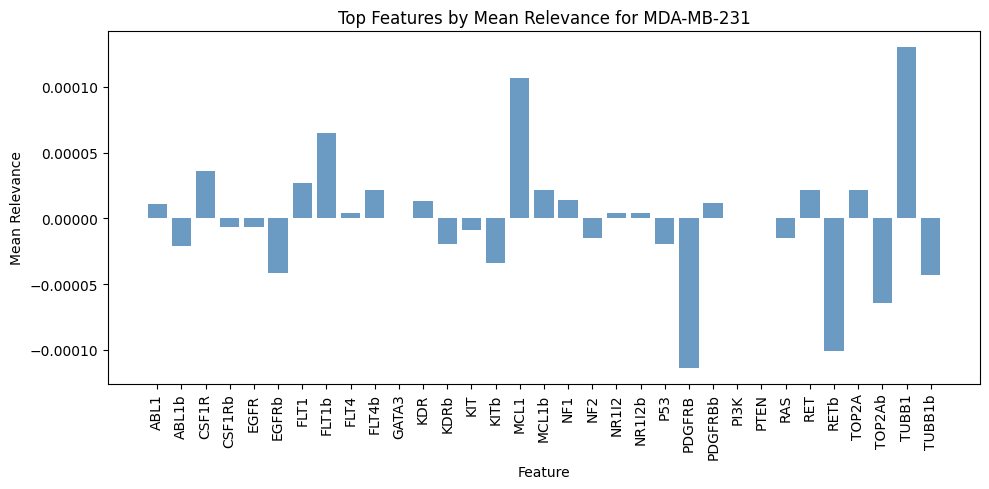

Number of samples for MDA-MB-231: 6476


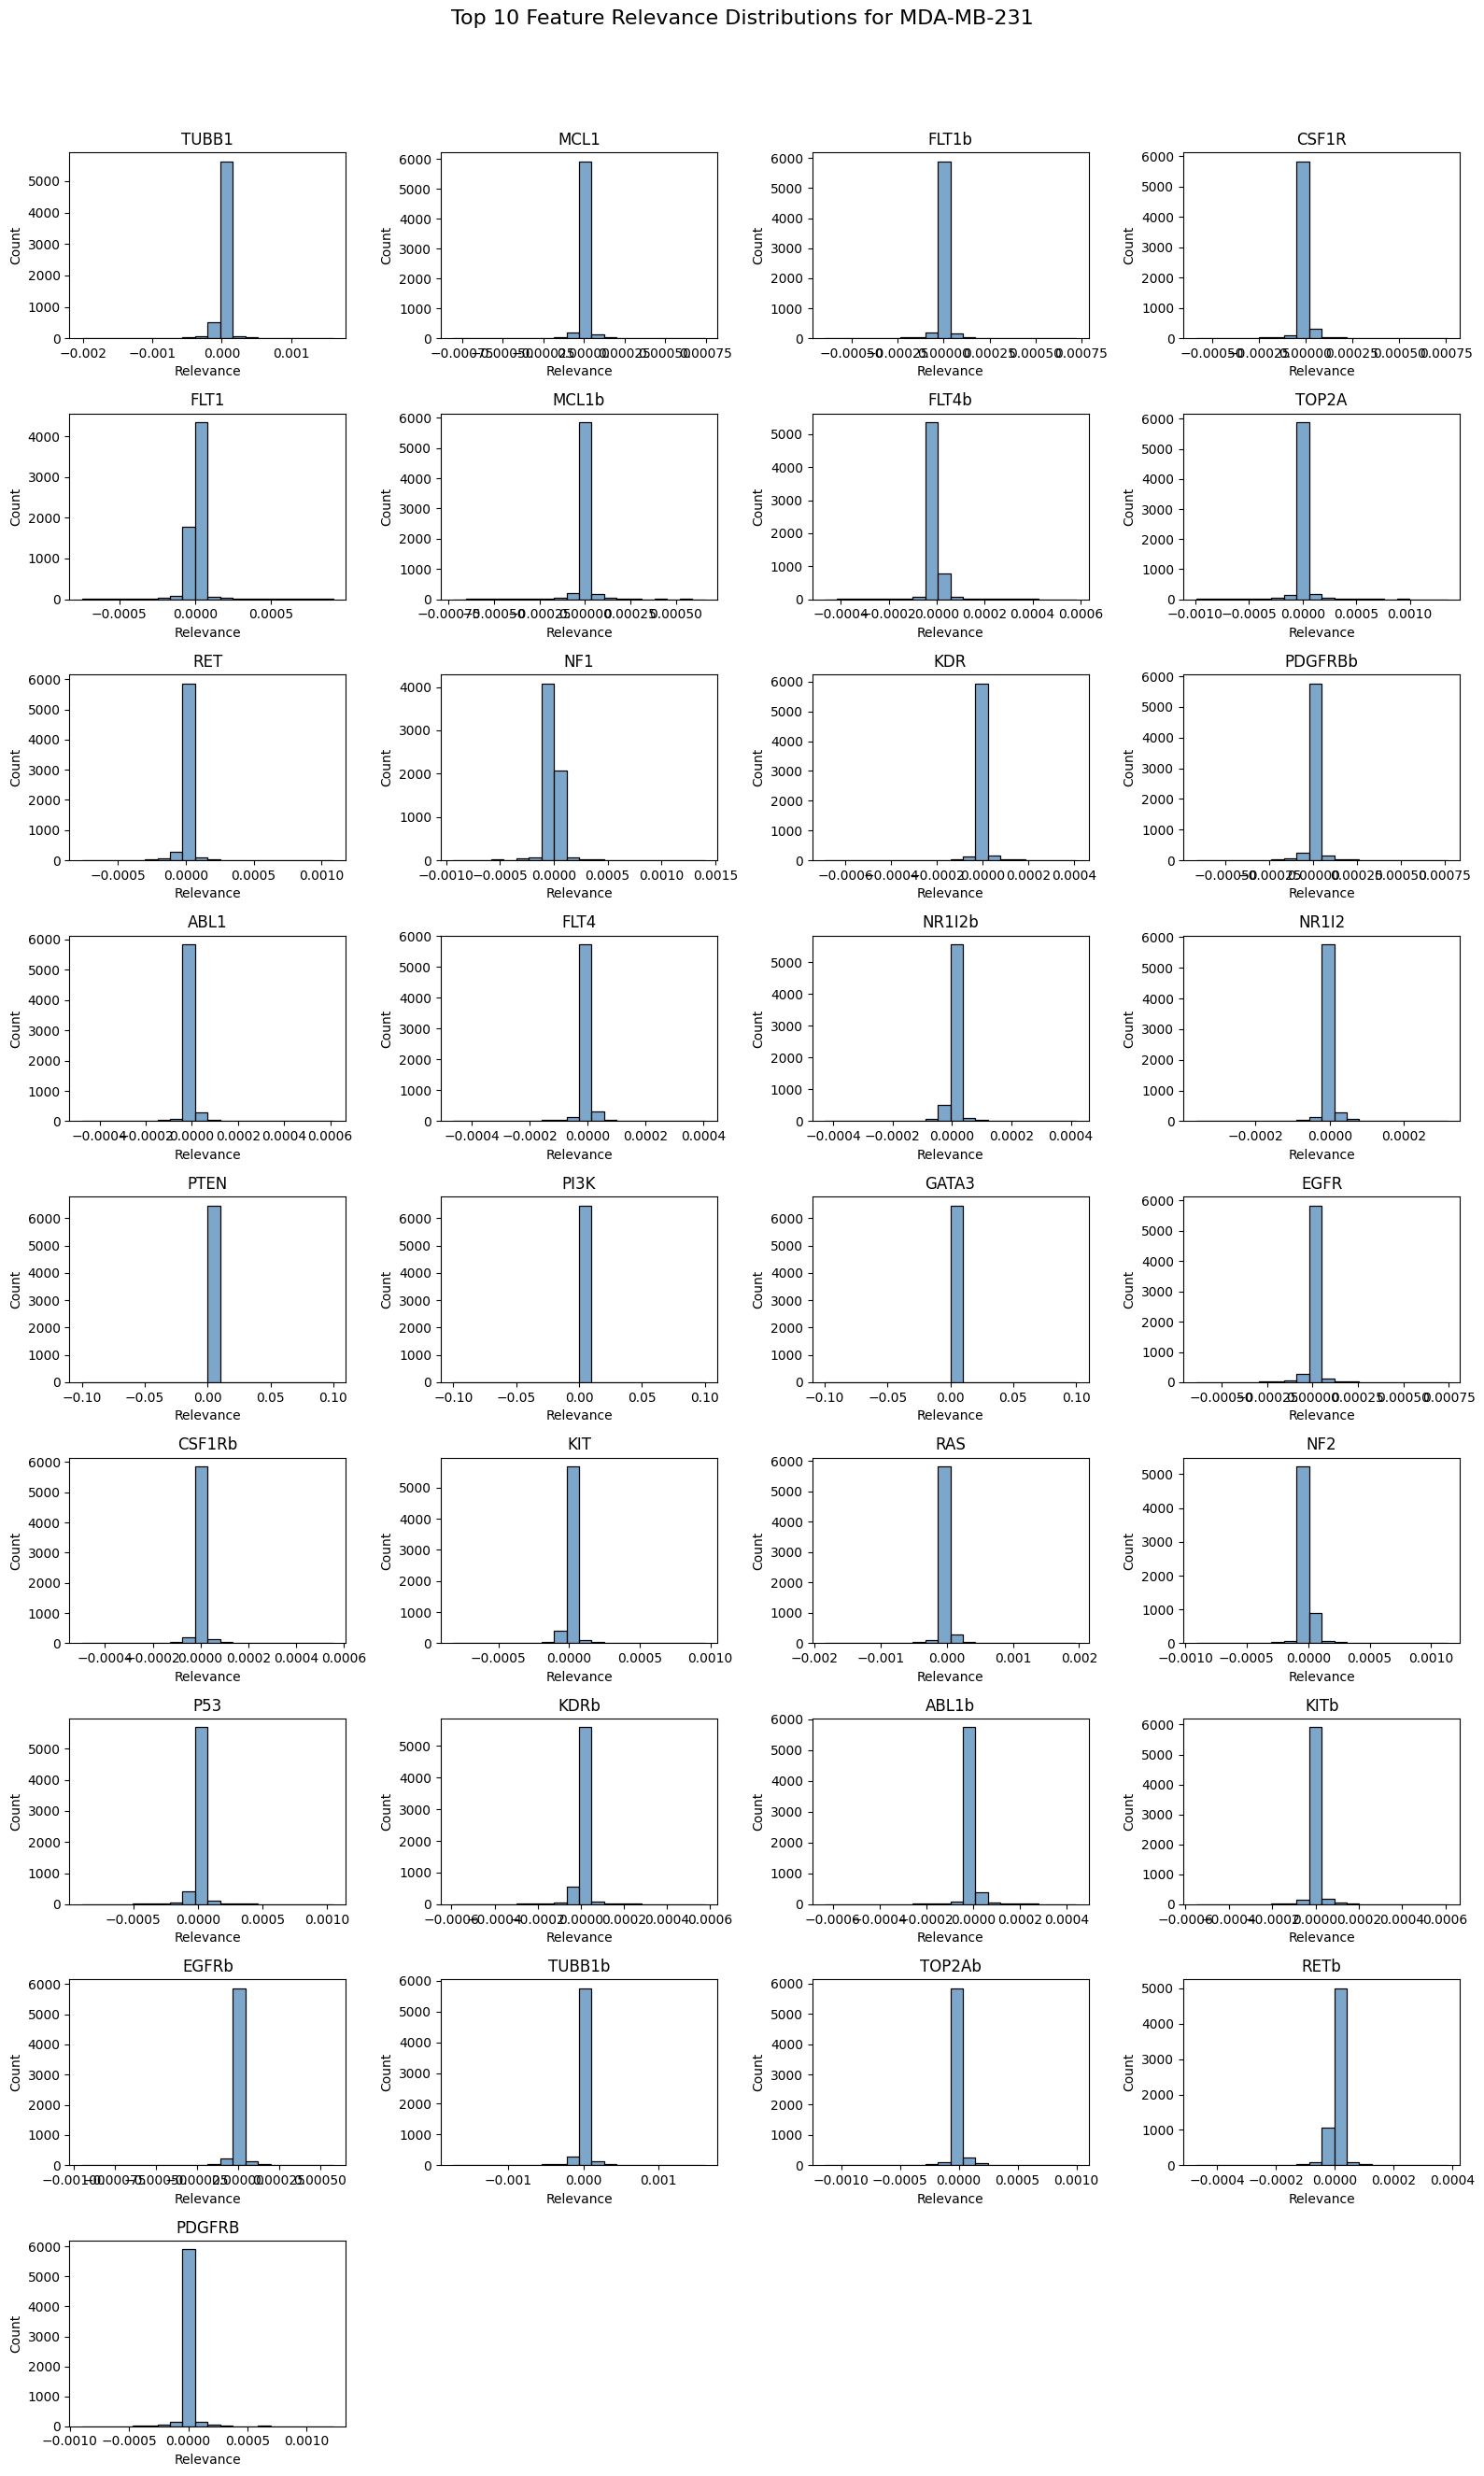

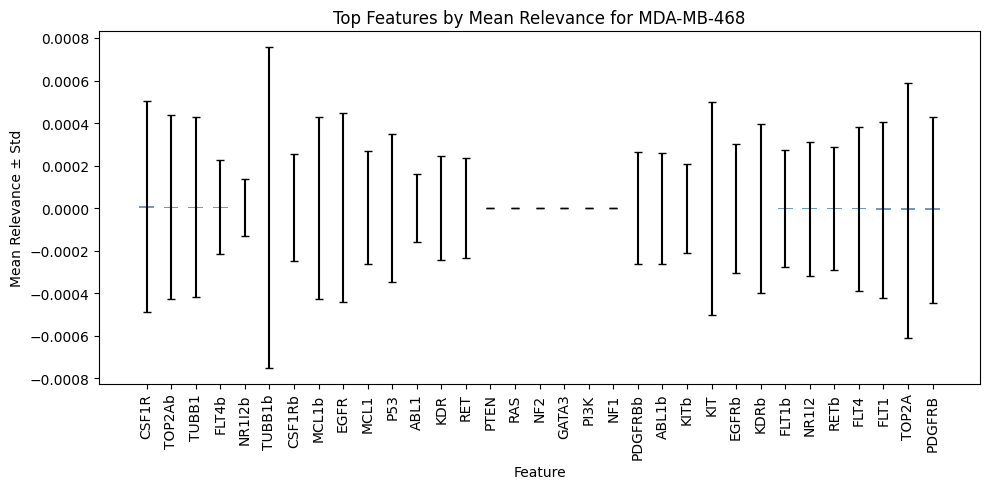

Number of samples for MDA-MB-468: 6400


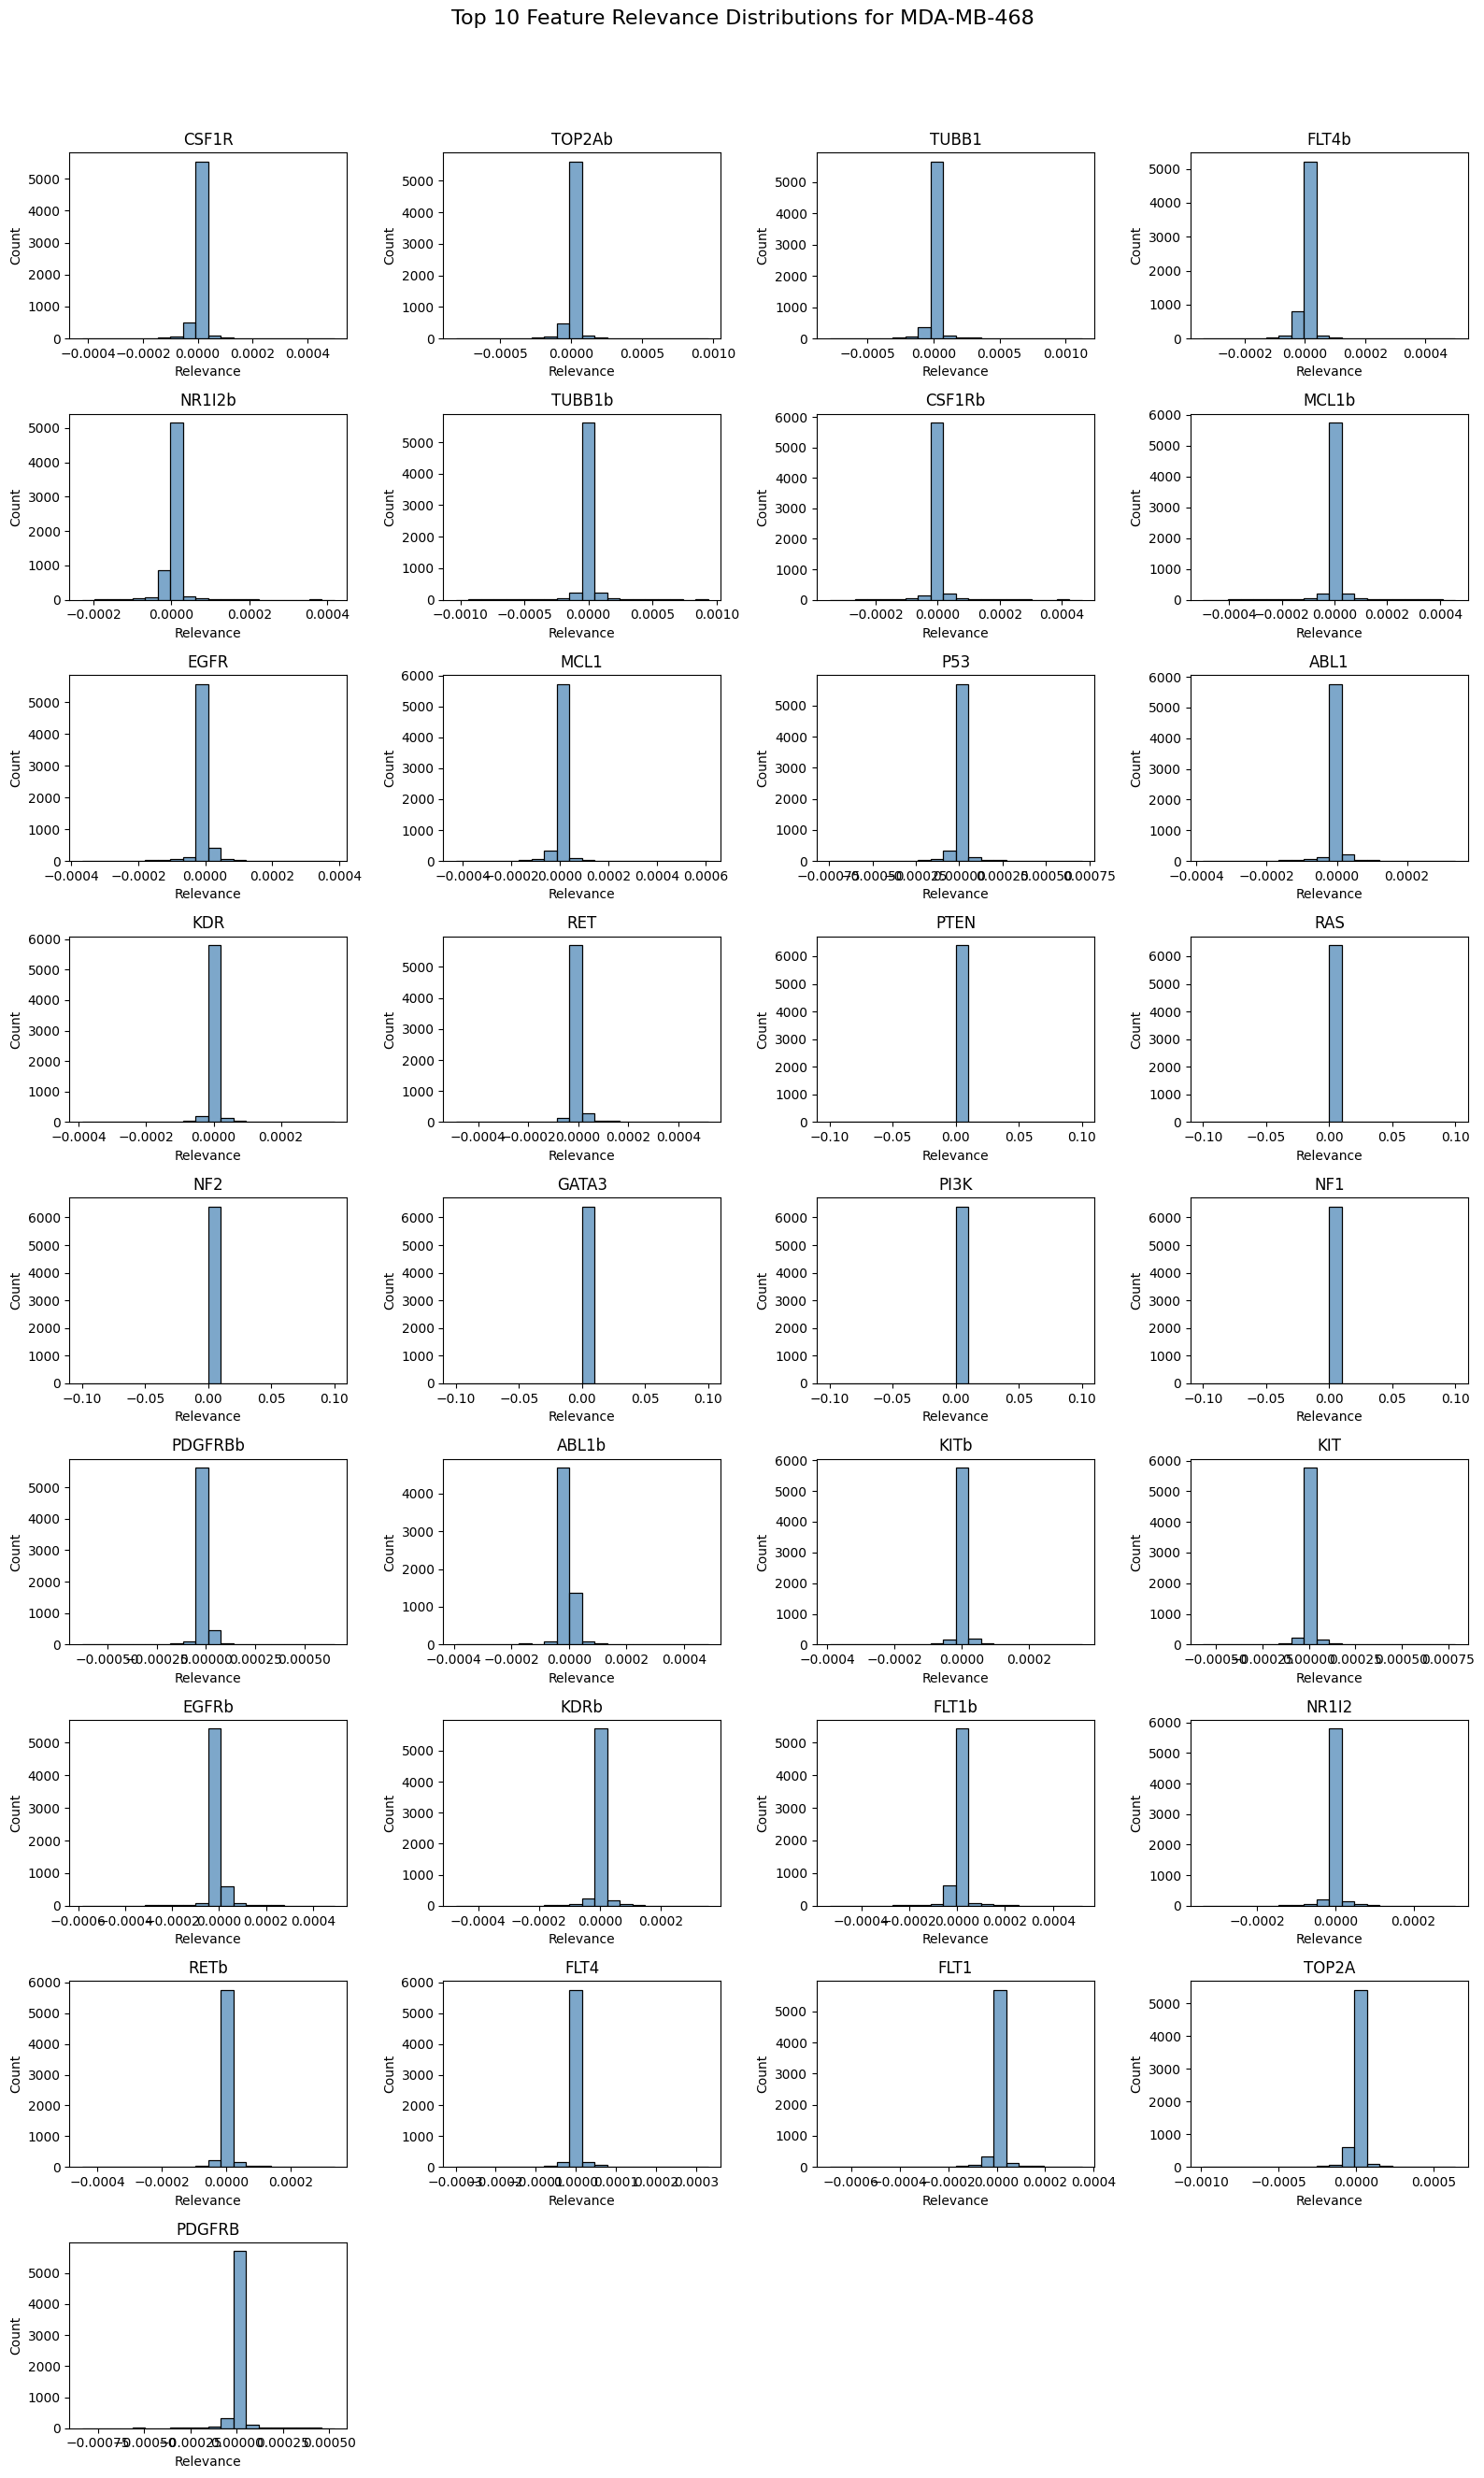

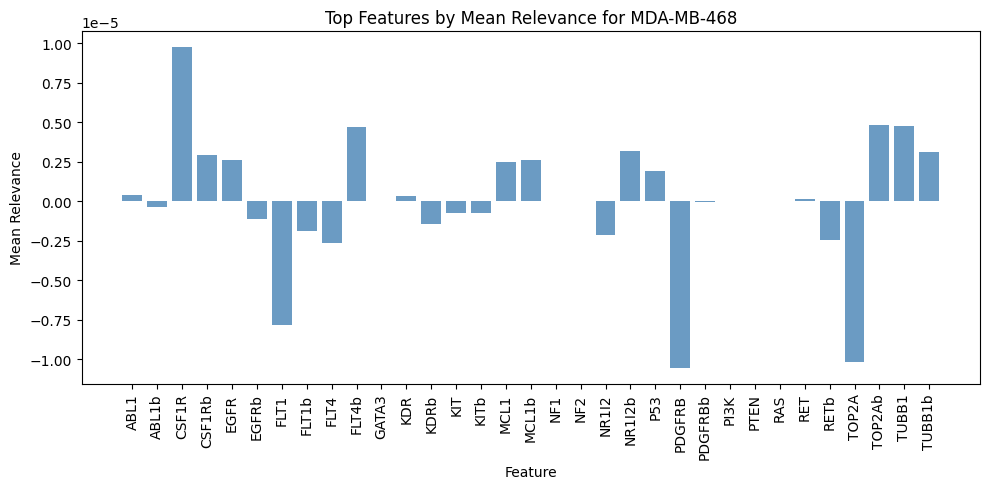

Number of samples for MDA-MB-468: 6400


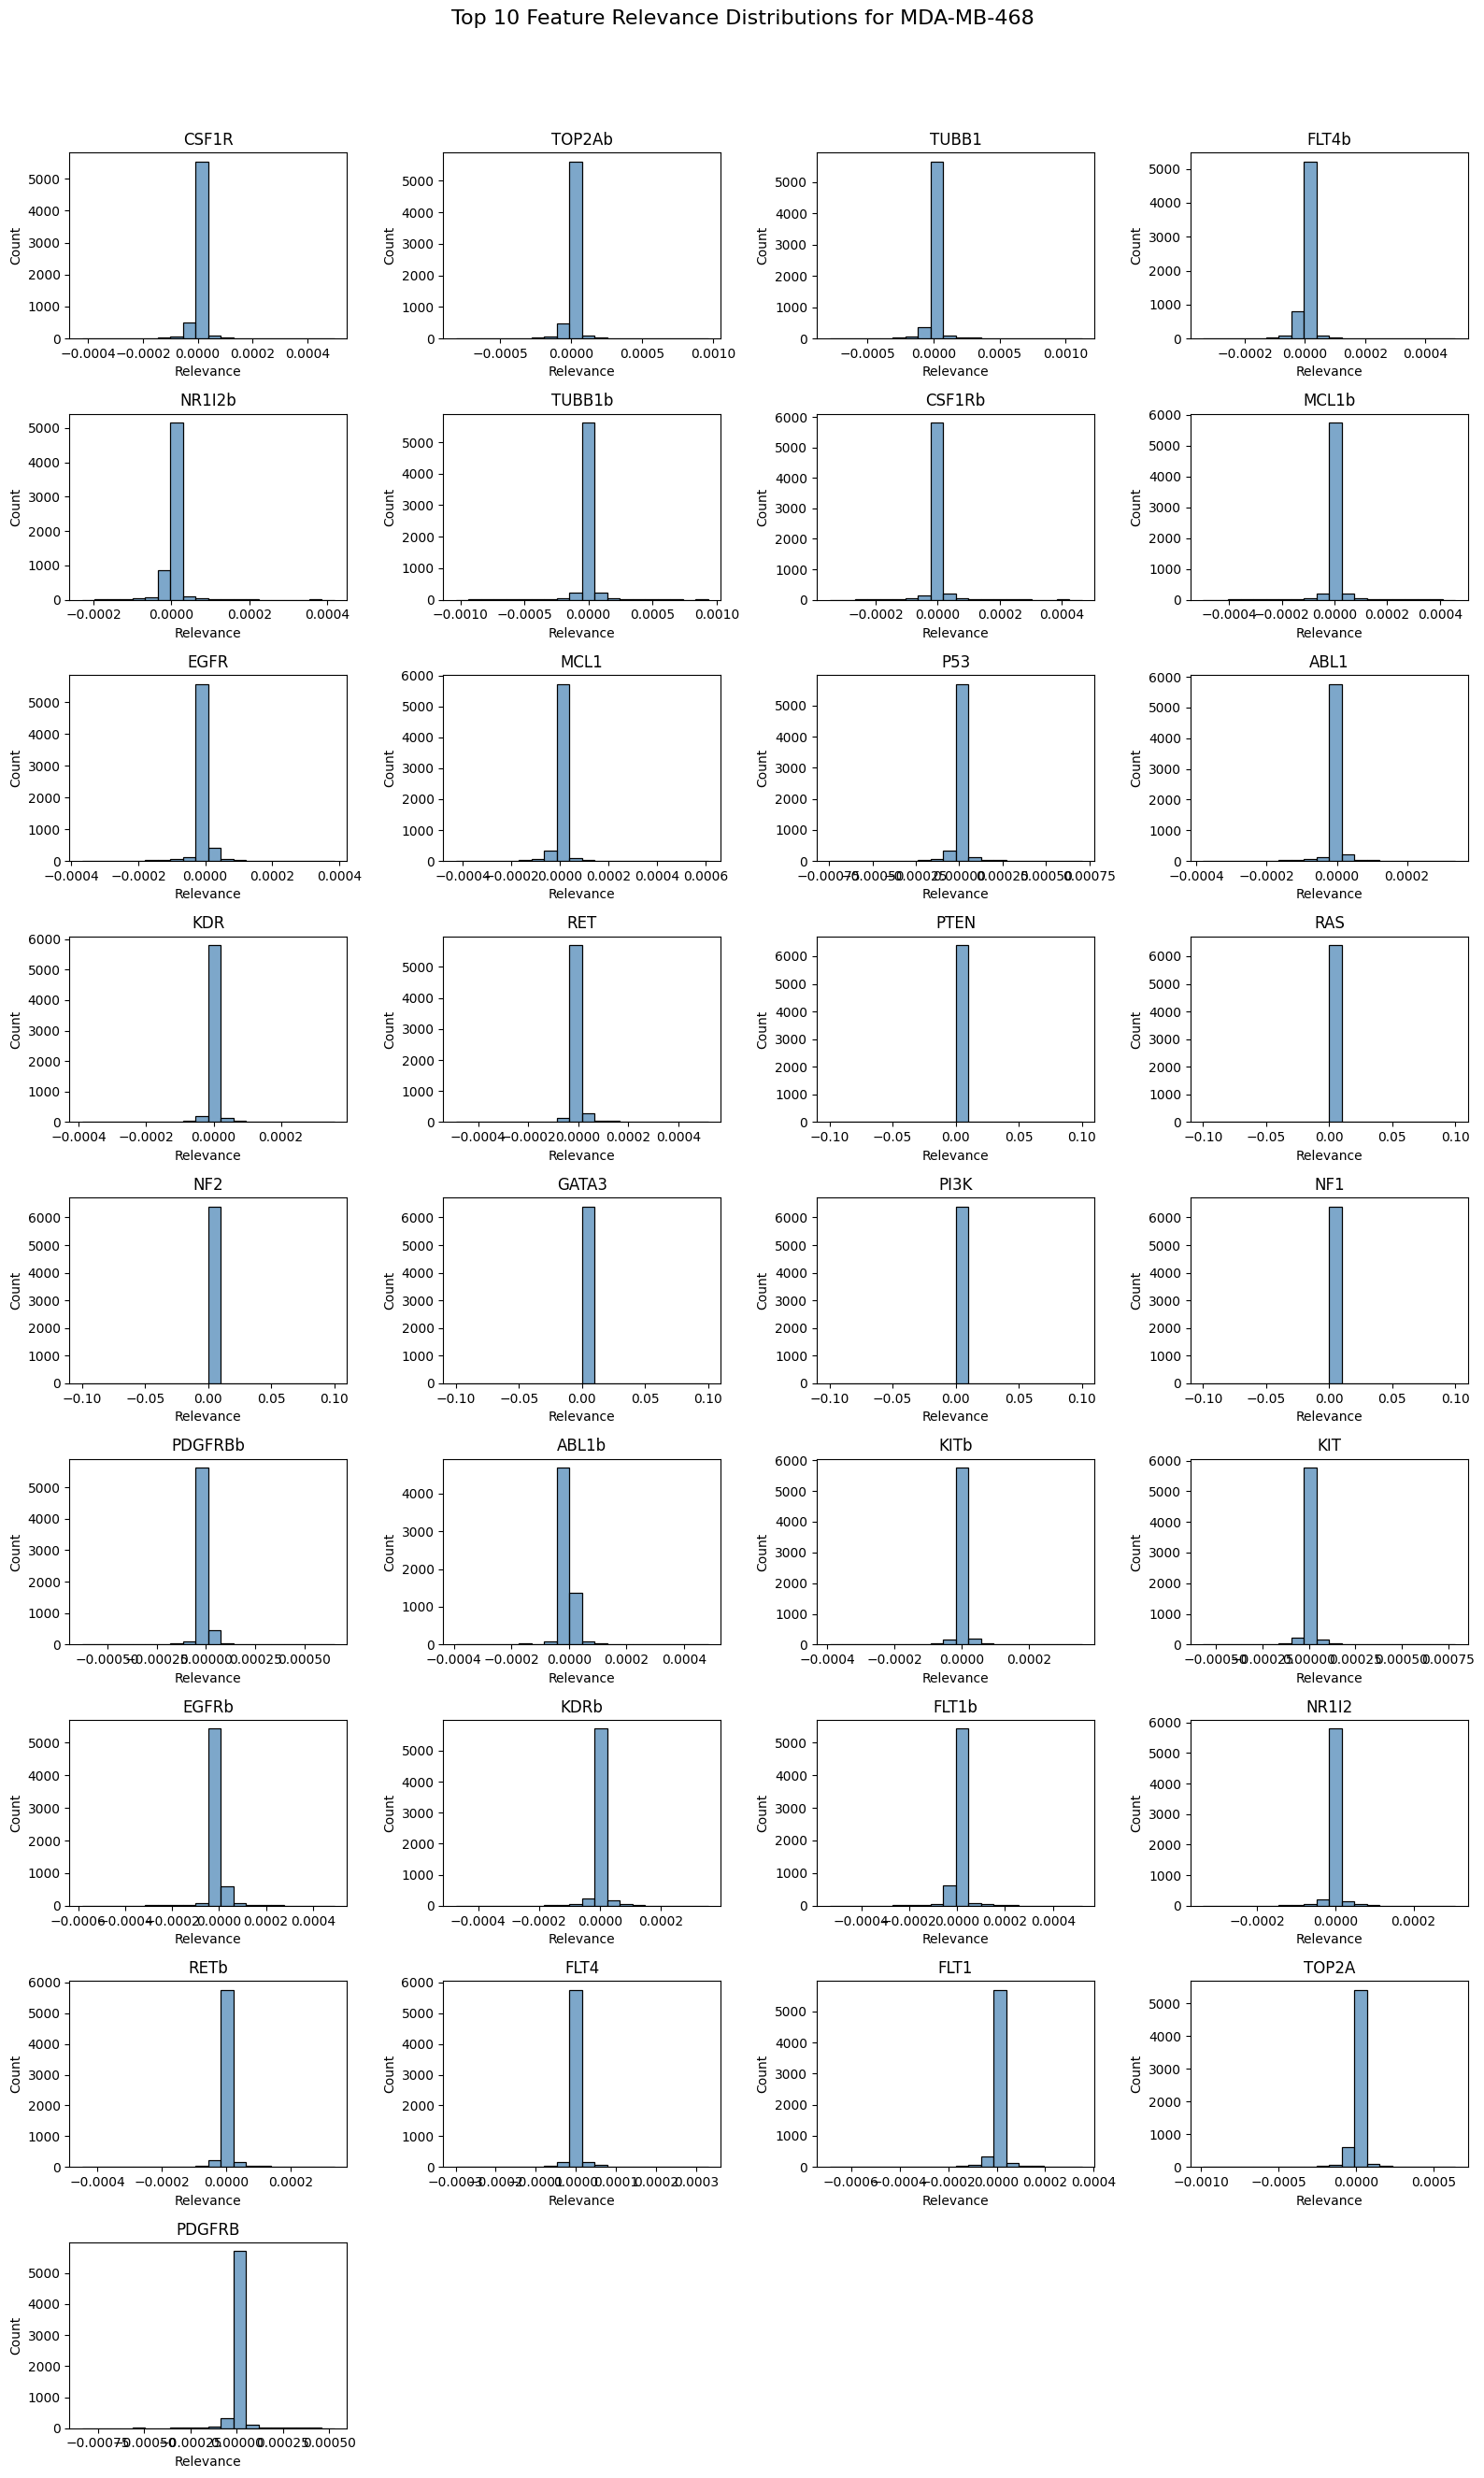

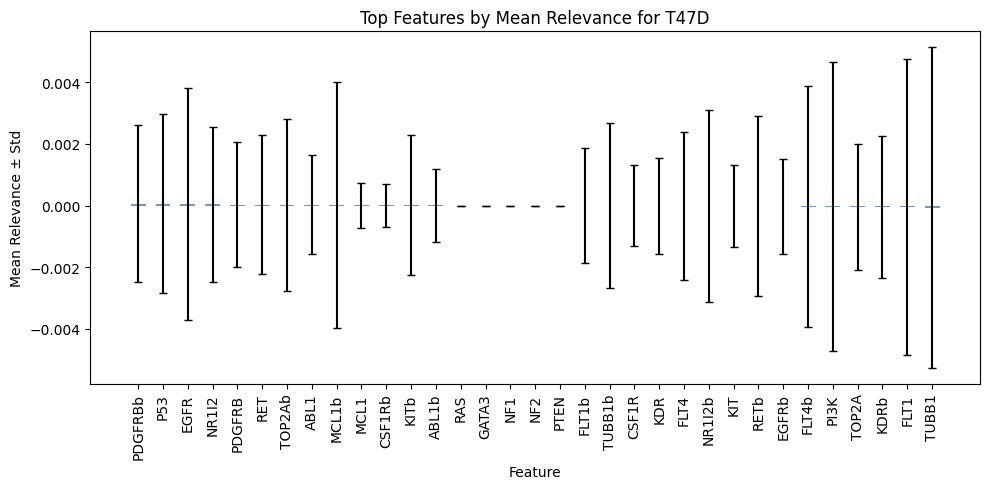

Number of samples for T47D: 6432


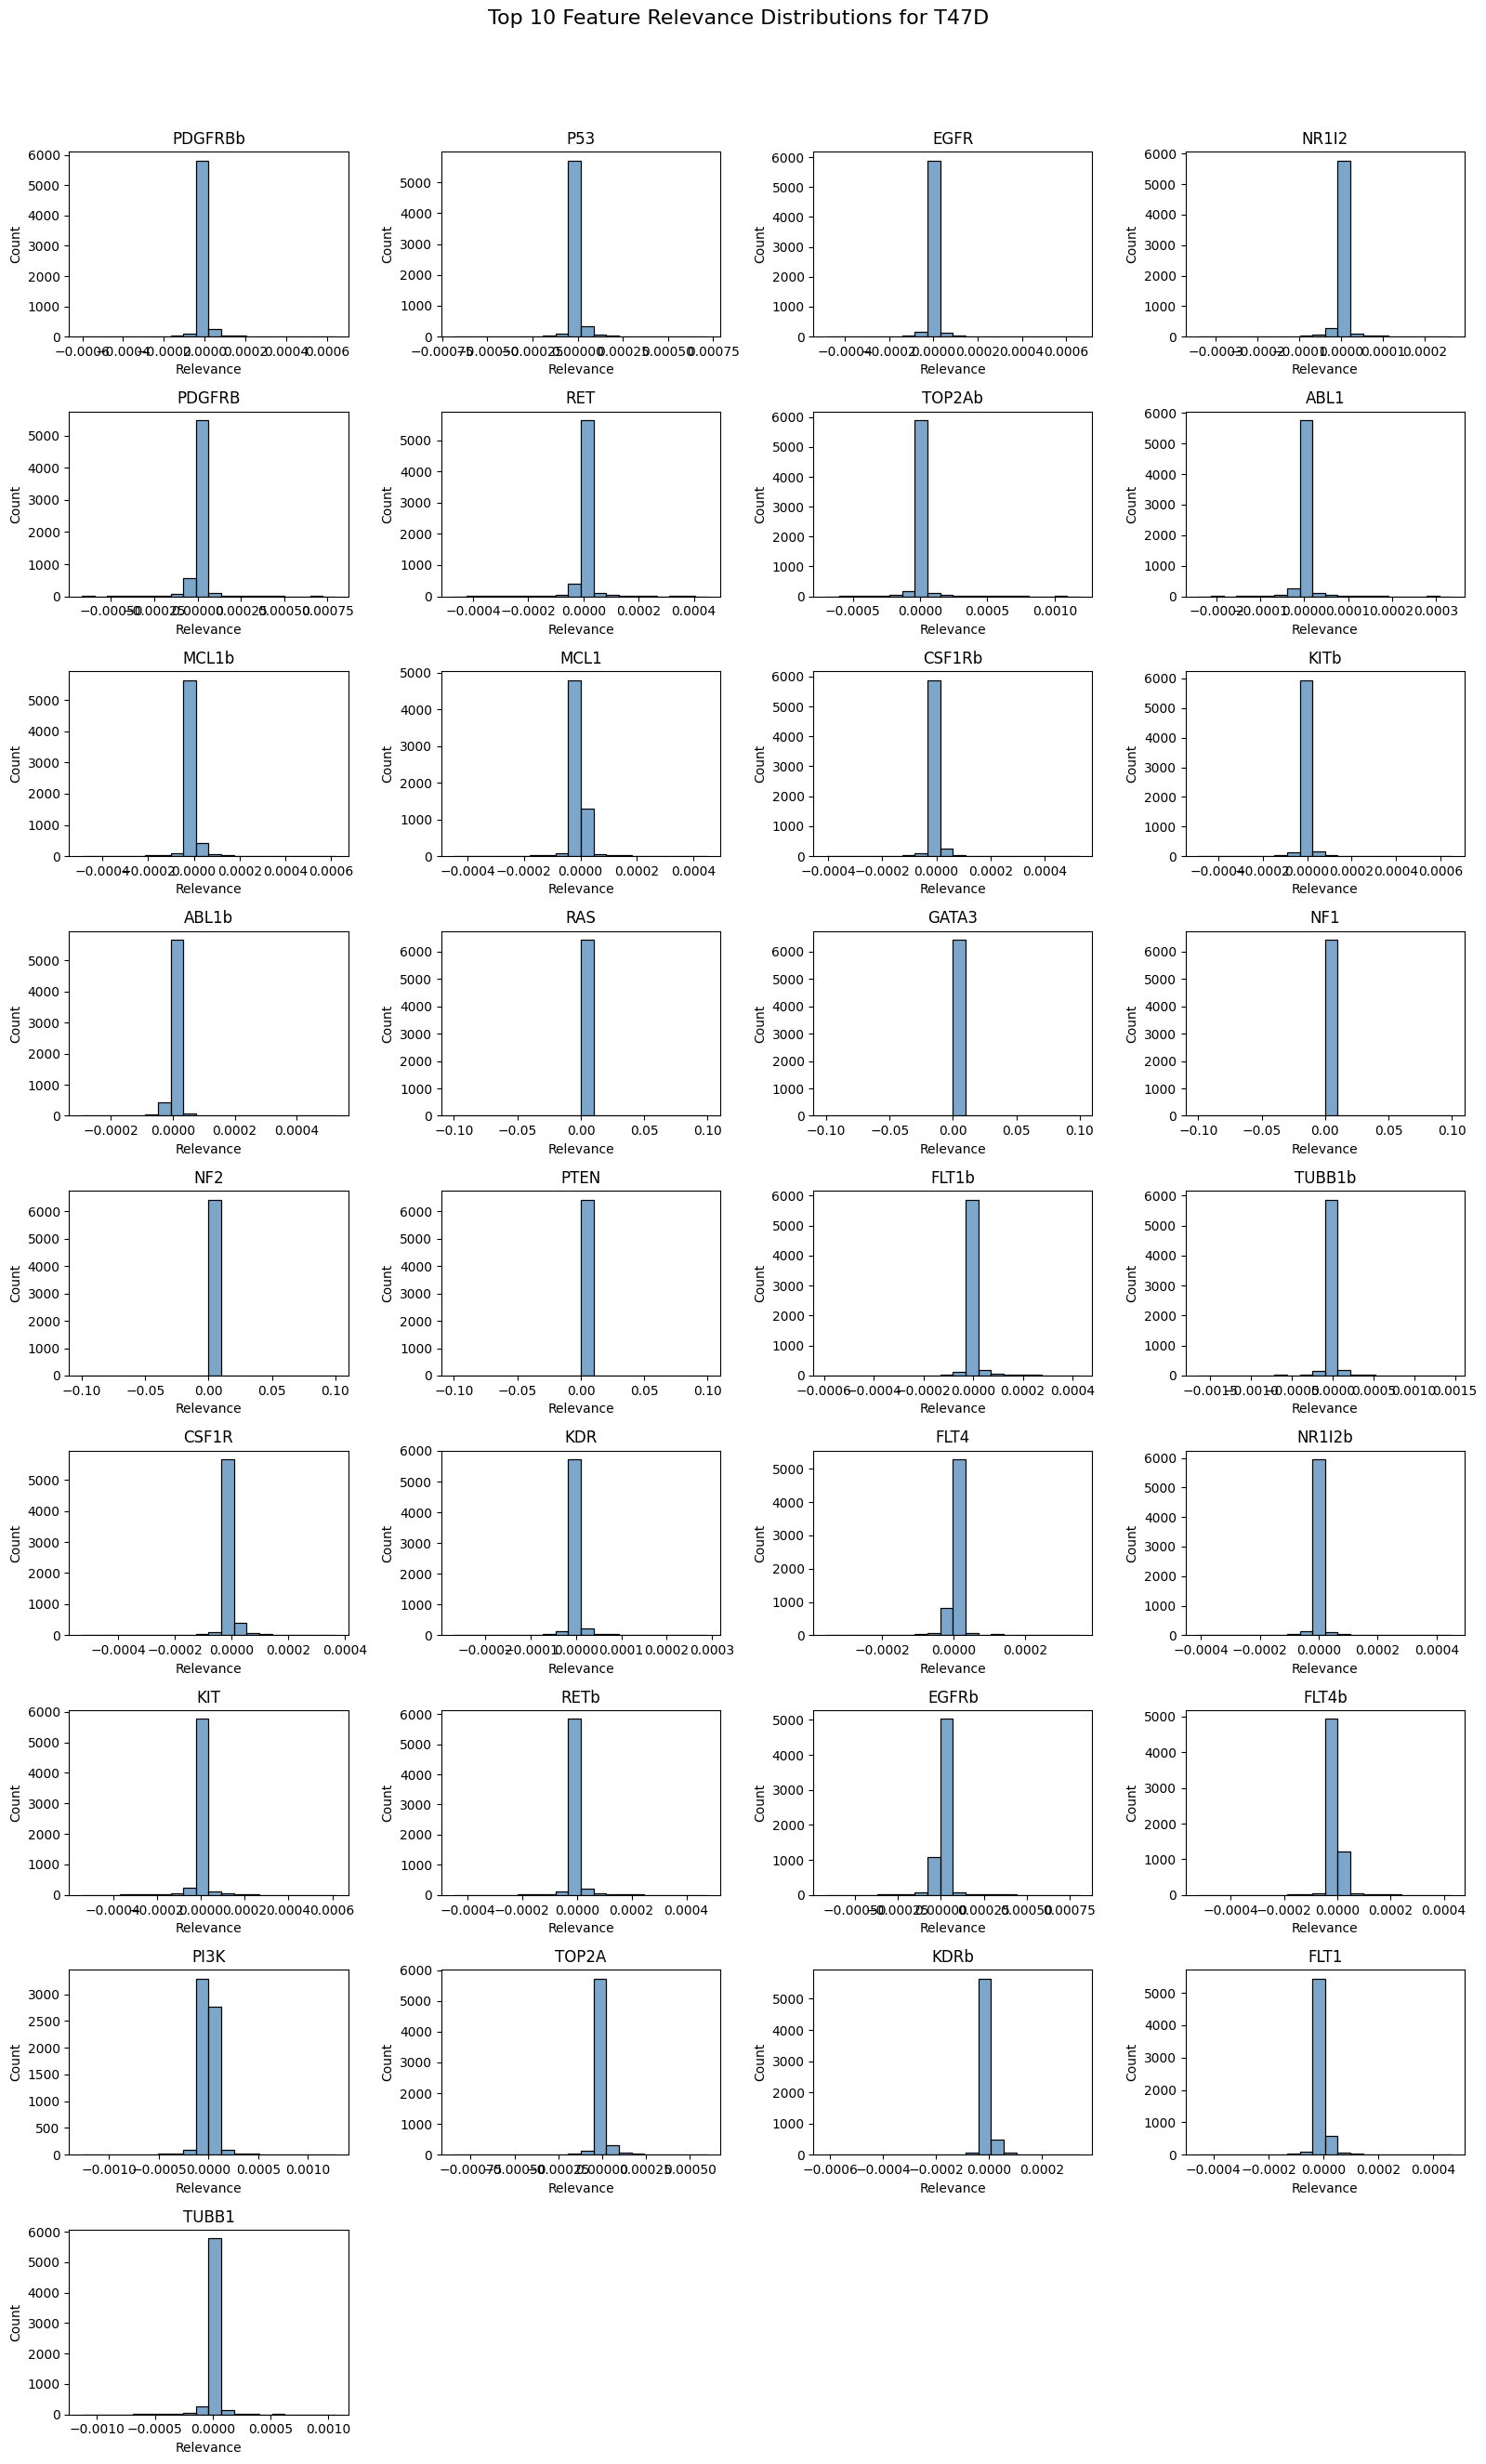

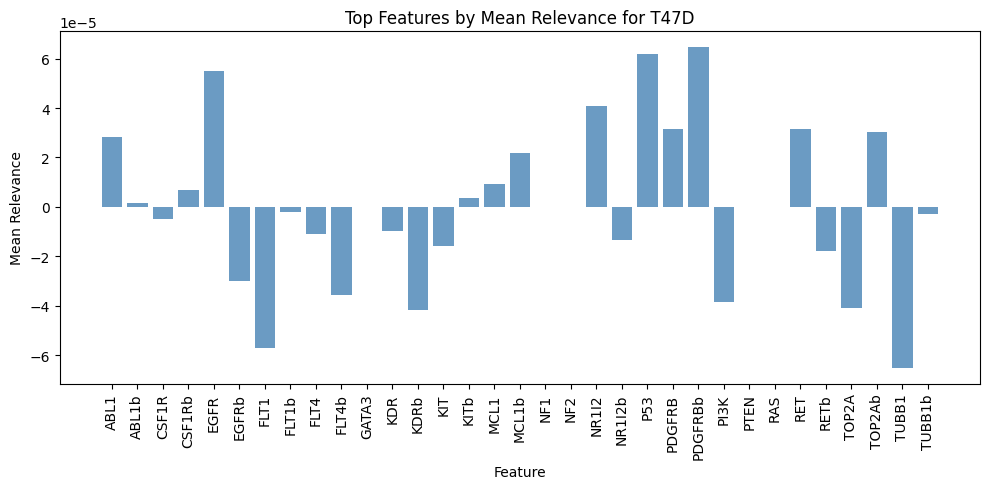

Number of samples for T47D: 6432


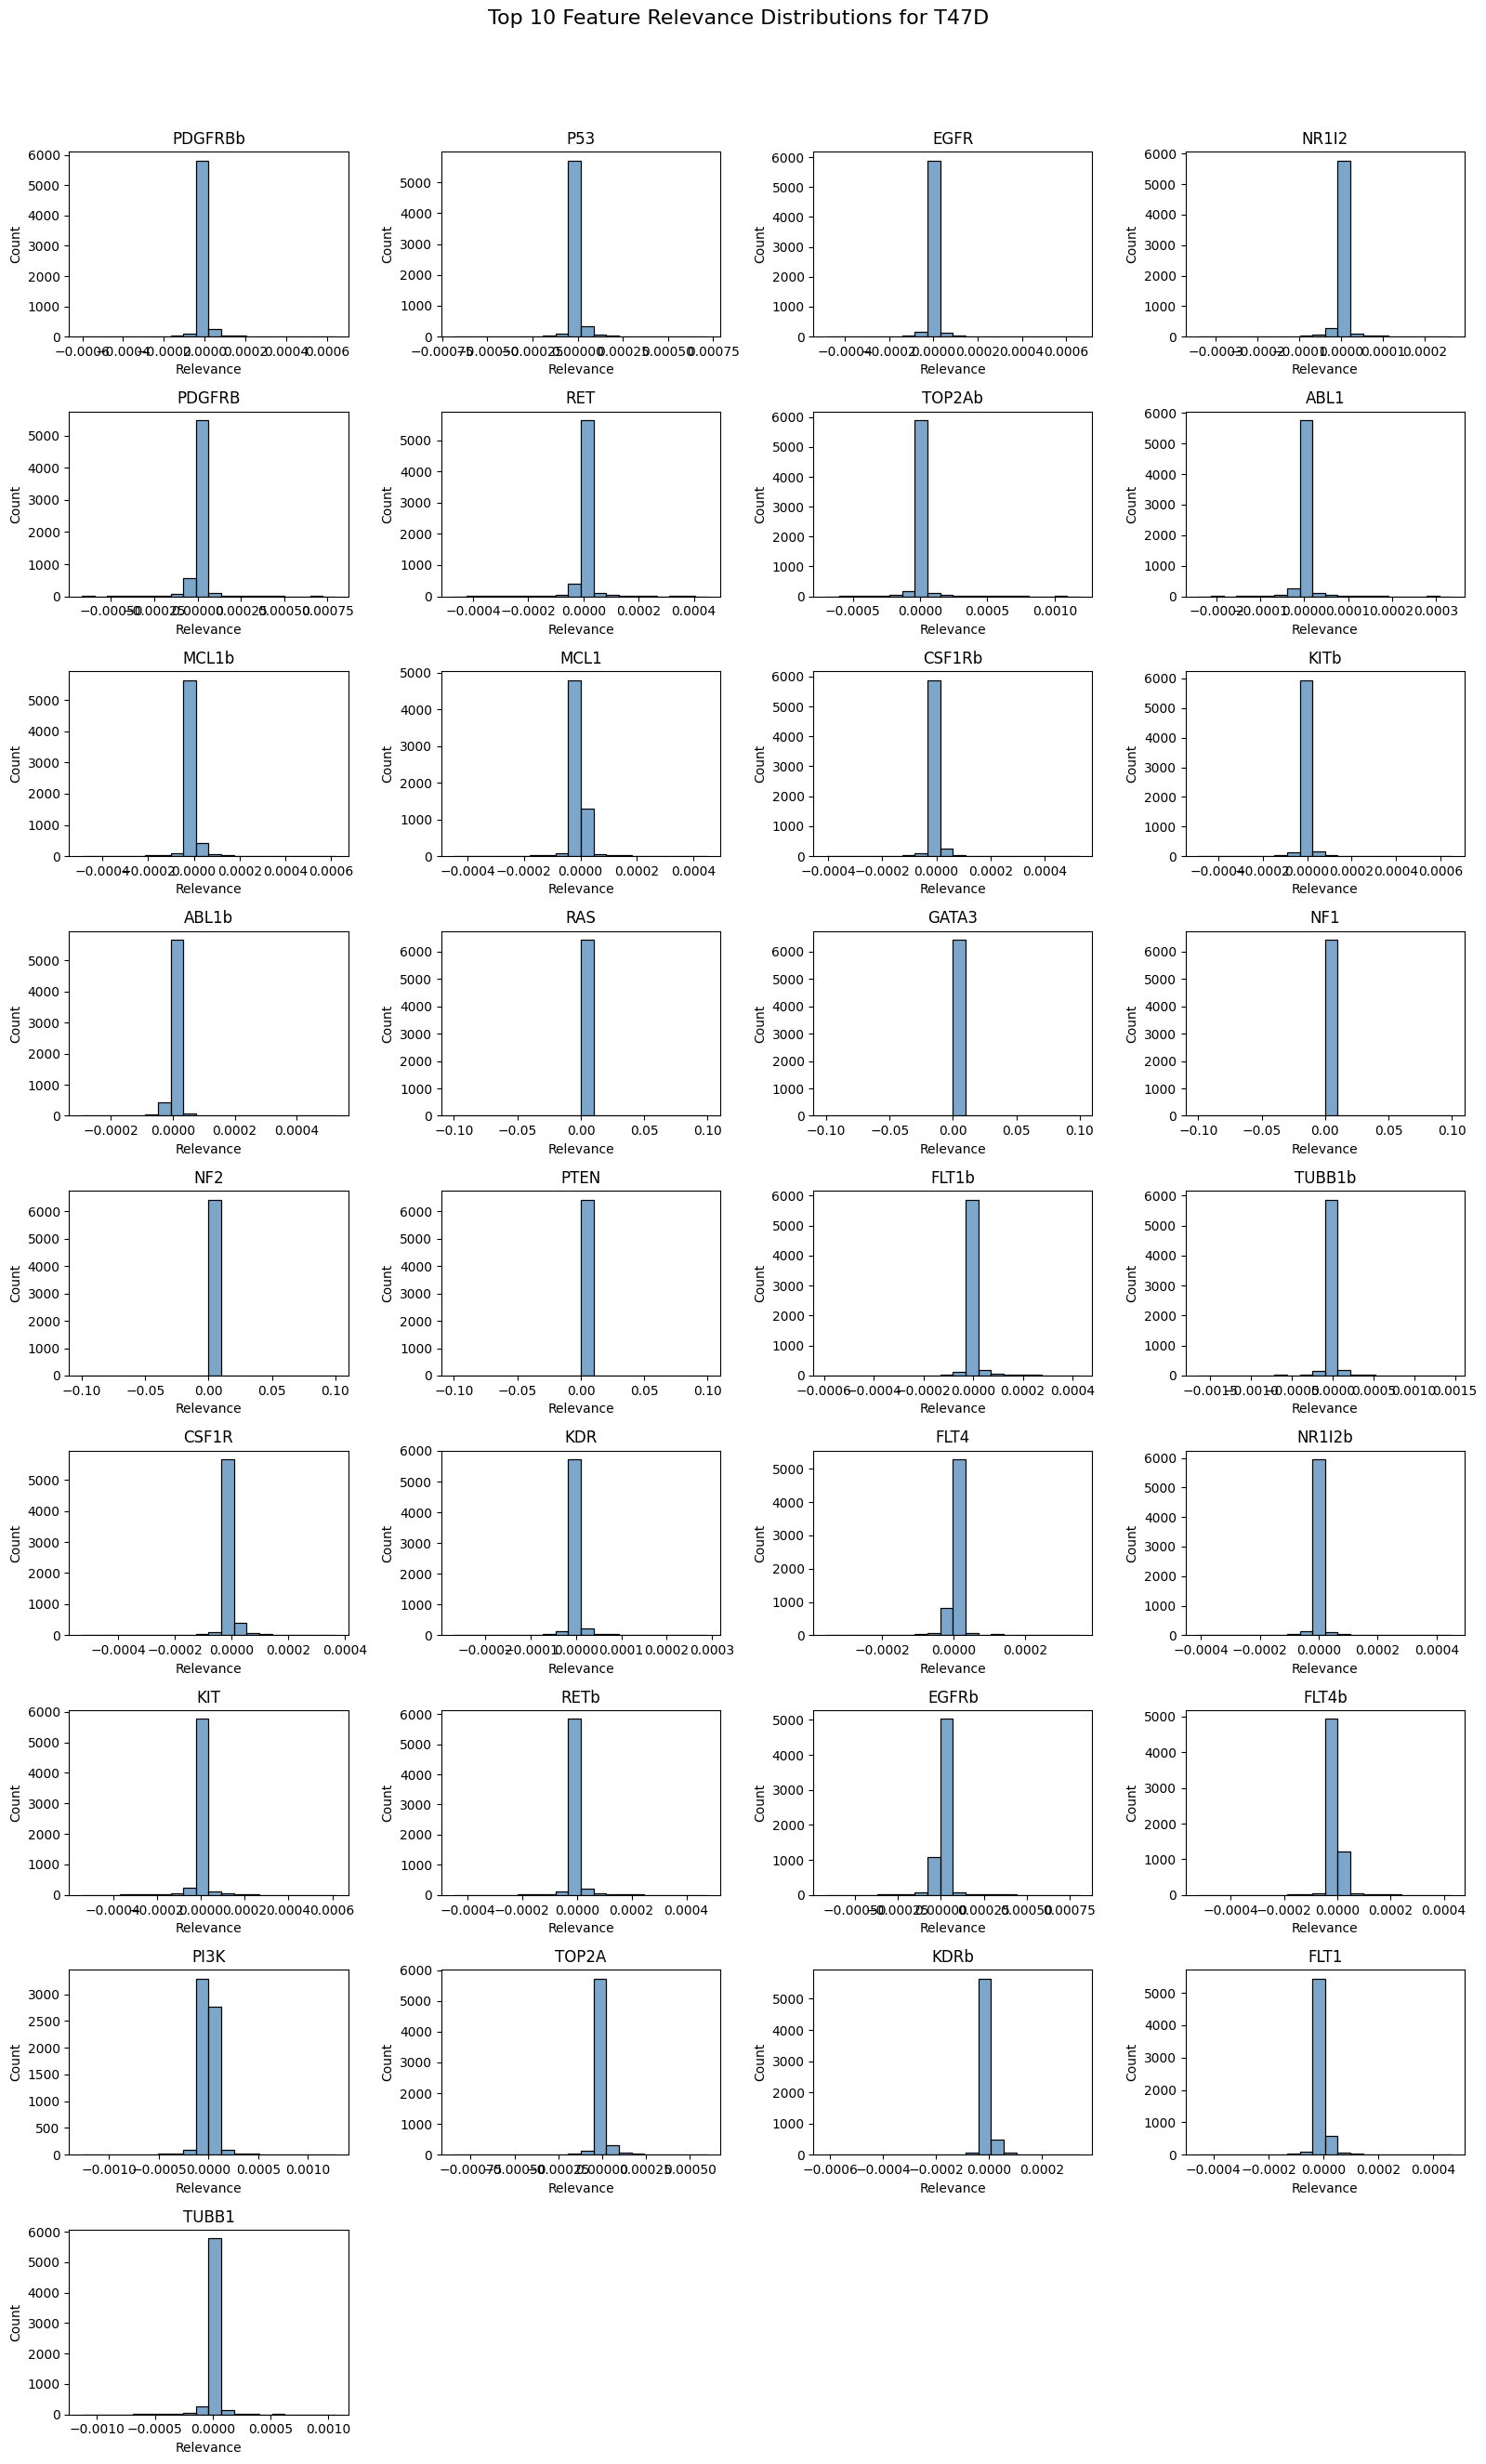

In [8]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

def show_small_multiple_histograms(mask, title_suffix="", selected_features=None):
    relevances_filtered = norm_relevances[mask]
    Y_filtered = Y[mask]
    y_values = np.array(Y_filtered).reshape(-1)
    print(f"Number of samples for {title_suffix}: {len(y_values)}")

    if len(y_values) == 0:
        print(f"Skipping {title_suffix} — no samples after filtering.")
        return

    if selected_features is None:
        features_to_plot = feature_names
    else:
        features_to_plot = selected_features

    data = pd.DataFrame(relevances_filtered, columns=feature_names)

    num_features = len(features_to_plot)
    ncols = 4
    nrows = (num_features + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows), sharex=False, sharey=False)
    axes = axes.flatten()

    for i, feature in enumerate(features_to_plot):
        ax = axes[i]
        vmin = np.percentile(data[feature], 0.5)
        vmax = np.percentile(data[feature], 99.5)
        delta = (vmax - vmin) * 0.1 if vmax > vmin else 0.1
        sns.histplot(
            data[feature],
            bins=20,
            kde=False,
            ax=ax,
            color='steelblue',
            alpha=0.7,
            binrange=(vmin - delta, vmax + delta)
        )
        ax.set_title(feature)
        ax.set_xlabel("Relevance")
        ax.set_ylabel("Count")

    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.suptitle(f"Top 10 Feature Relevance Distributions for {title_suffix}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# Usage:
cell_line_names = np.unique(cell_line_data)

for cell_line_name in cell_line_names:
    mask = cell_line_data == cell_line_name
    relevances_filtered = norm_relevances[mask]

    means = np.mean(relevances_filtered, axis=0)
    stds = np.std(relevances_filtered, axis=0)

    # Sort by mean relevance (descending)
    sorted_indices = np.argsort(means)[::-1]
    features_sorted = np.array(feature_names)[sorted_indices]
    means_sorted = means[sorted_indices]
    stds_sorted = stds[sorted_indices]

    plt.figure(figsize=(10, 5))
    plt.bar(features_sorted, means_sorted, yerr=stds_sorted,
            color='steelblue', alpha=0.8, capsize=3, width=0.6)
    plt.xticks(rotation=90)
    plt.xlabel("Feature")
    plt.ylabel("Mean Relevance ± Std")
    plt.title(f"Top Features by Mean Relevance for {cell_line_name}")
    plt.tight_layout()
    plt.show()

    show_small_multiple_histograms(mask, title_suffix=cell_line_name, selected_features=features_sorted)

    Y_cell_line = Y[mask]
    relevances_filtered = norm_relevances[mask]
    means = np.mean(relevances_filtered, axis=0)
    
    # sort by bean relevance 
    features = np.array(feature_names)[np.argsort(means)[::-1]]
    means = means[np.argsort(means)[::-1]]
    # sort features alpabetically and means accordingly please
    sorted_indices_alpha = np.argsort(features)
    features_alpha = features[sorted_indices_alpha]
    means = means[sorted_indices_alpha]
        
    plt.figure(figsize=(10, 5))
    plt.bar(features_alpha, means, color='steelblue', alpha=0.8)
    plt.xticks(rotation=90)
    plt.xlabel("Feature")
    plt.ylabel("Mean Relevance")
    plt.title(f"Top Features by Mean Relevance for {cell_line_name}")
    plt.tight_layout()
    plt.show()

    show_small_multiple_histograms(mask, title_suffix=cell_line_name, selected_features=features)


Number of samples for BT549: 2548


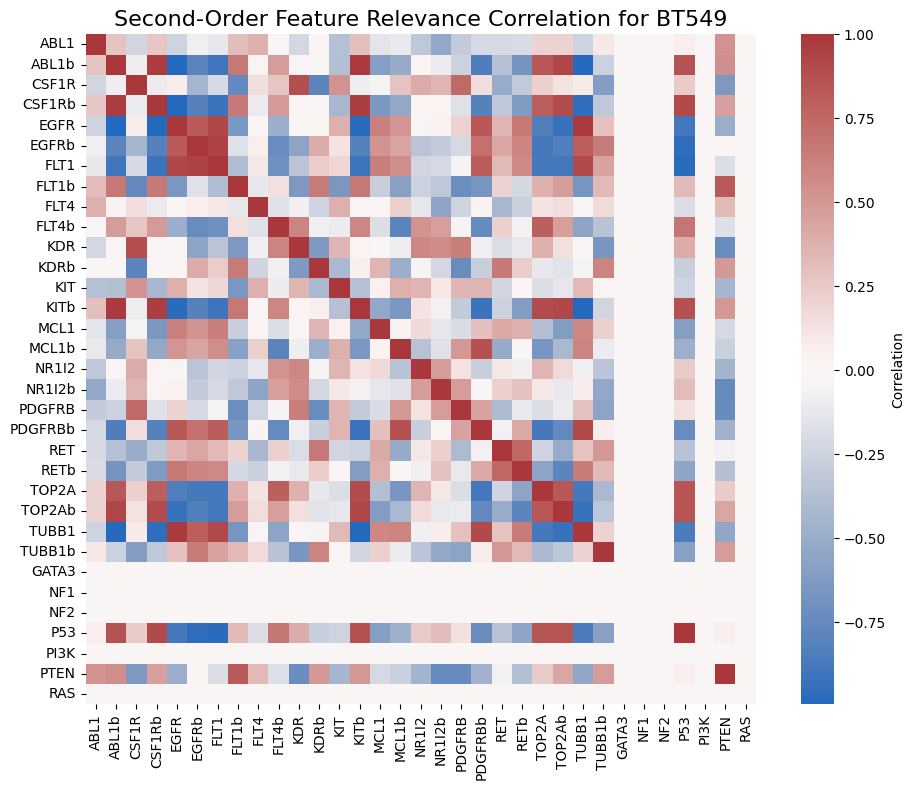

Number of samples for MCF7: 2196


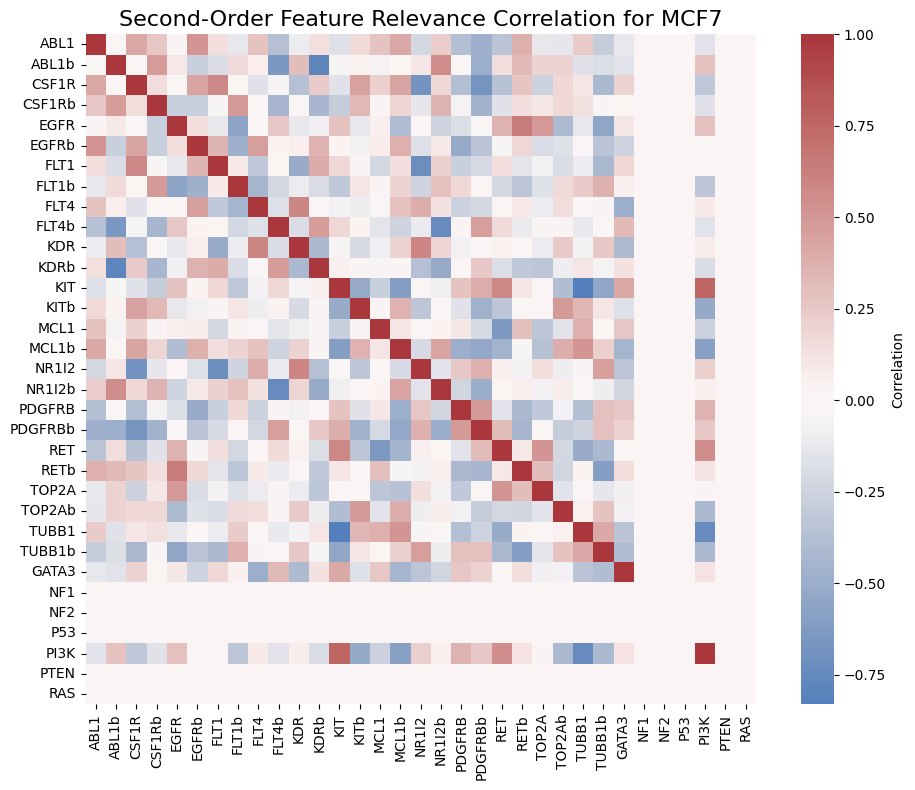

Number of samples for MDA-MB-231: 1764


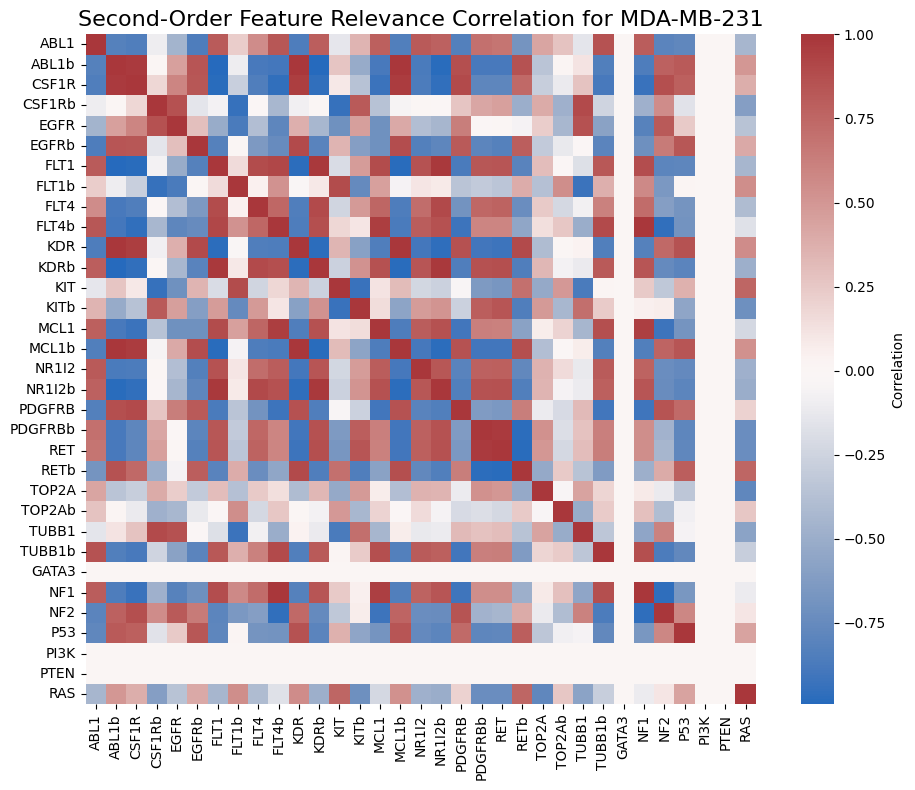

Number of samples for MDA-MB-468: 2484


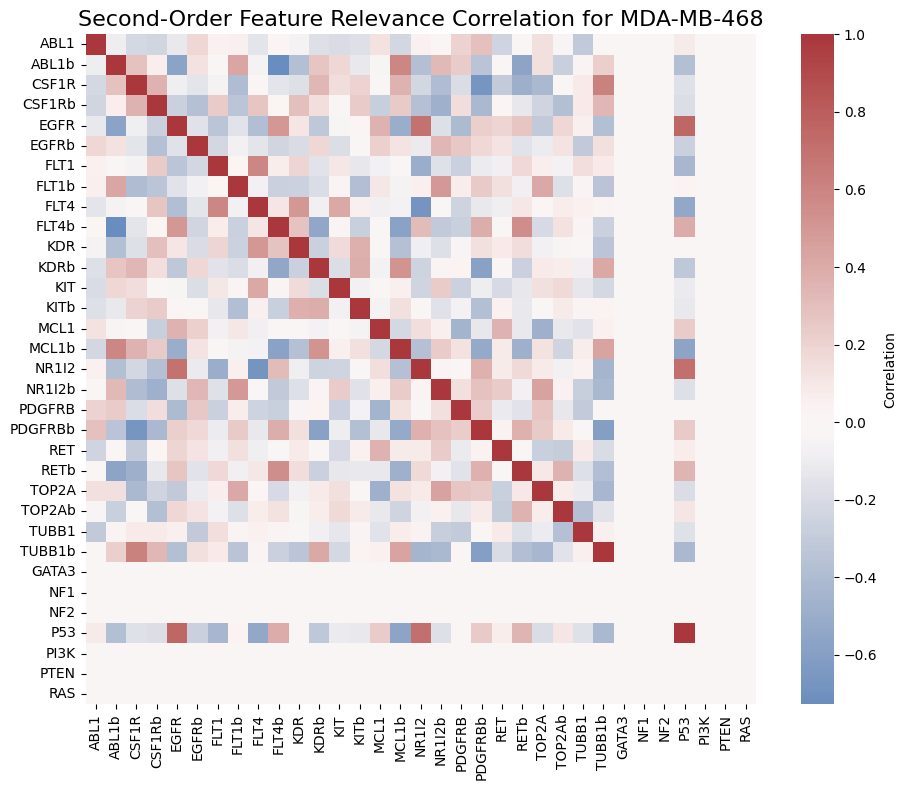

Number of samples for T47D: 2316


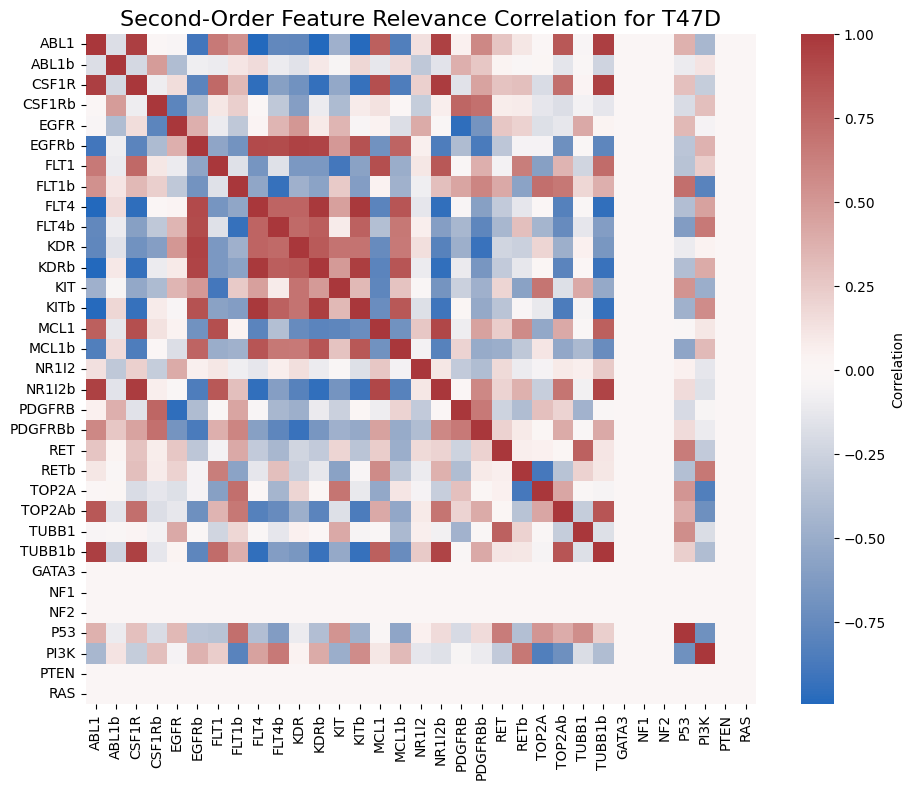

In [ ]:
# get second order plot 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np


def show_second_order_relevances(mask, title_suffix=""):
    relevances_filtered = relevances[mask]
    Y_filtered = Y[mask]
    y_values = np.array(Y_filtered).reshape(-1)

    if len(y_values) == 0:
        print(f"Skipping {title_suffix} — no samples after filtering.")
        return

    print(f"Number of samples for {title_suffix}: {len(y_values)}")

    df = pd.DataFrame(relevances_filtered, columns=feature_names)
    second_order = df.corr().fillna(0)

    plt.figure(figsize=(10, 8))
    sns.heatmap(second_order, cmap="vlag", center=0, square=True, cbar_kws={"label": "Correlation"})
    plt.title(f"Second-Order Feature Relevance Correlation for {title_suffix}", fontsize=16)
    plt.tight_layout()
    plt.show()


cell_line_names = np.unique(cell_line_data)
for cell_line_name in cell_line_names:
    mask = cell_line_data == cell_line_name
    positive_mask = Y > 0
    new_mask = mask & positive_mask
    show_second_order_relevances(new_mask, title_suffix=cell_line_name)


## Transynergy

See paper: file:///C:/Users/ismyn/Downloads/journal.pcbi.1008653.pdf

In [ ]:
print(model_trans)

TransposeMultiTransformersPlusLinear(
  (linear_layers): ModuleList(
    (0-2): 3 x Linear(in_features=2402, out_features=400, bias=True)
  )
  (norms): ModuleList(
    (0-2): 3 x Norm()
  )
  (dropouts): ModuleList(
    (0-2): 3 x Dropout(p=0.2, inplace=False)
  )
  (transformer_list): ModuleList(
    (0): Transformer(
      (encoder): Encoder(
        (layers): ModuleList(
          (0): EncoderLayer(
            (norm_1): Norm()
            (norm_2): Norm()
            (attn): MultiHeadAttention(
              (q_linear): Linear(in_features=3, out_features=3, bias=True)
              (v_linear): Linear(in_features=3, out_features=3, bias=True)
              (k_linear): Linear(in_features=3, out_features=3, bias=True)
              (dropout): Dropout(p=0.2, inplace=False)
              (out): Linear(in_features=3, out_features=3, bias=True)
            )
            (ff): FeedForward(
              (linear_1): Linear(in_features=3, out_features=3, bias=True)
              (dropout): 

In [ ]:
# the neural fingerprint layers are actually unsused in the model and an artifact from the original model
import numpy as np
from explainability.data_utils import load_transynergy_cell_line_data, load_transynergy_data , load_transynergy_drug_names
from explainability.explaination_config import ExplainationConfig

config = ExplainationConfig(
    paper="transynergy",
)
cell_line_data = load_transynergy_cell_line_data(split = 'test')
cell_line_data = np.concatenate([cell_line_data, cell_line_data], axis=0)

drug_name_a, drug_name_b = load_transynergy_drug_names(split= 'test')
drug_name_a = np.concatenate([drug_name_a, drug_name_b], axis=0)
drug_name_b = np.concatenate([drug_name_b, drug_name_a], axis=0)

X, Y = load_transynergy_data(split = 'test')

relevances = np.load("explainability/lrp/results/transynergy_subsample_False/relevances.npy")
feature_names = config.feature_names

[fold] Leakage:
  • Test ↔ Train: 0
  • Val  ↔ Train: 0
  • Val  ↔ Test : 0
Original rows: 18552
Remaining rows after cleaning: 18552
[fold] Leakage:
  • Test ↔ Train: 0
  • Val  ↔ Train: 0
  • Val  ↔ Test : 0
Original rows: 18552
Remaining rows after cleaning: 18552


AttributeError: type object 'SynergyDataReader' has no attribute 'get_synergy_data_drug_names_by_indices'

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

def show_small_multiple_histograms(mask, title_suffix="", selected_features=None):
    relevances_filtered = relevances[mask]
    relevancess_filtered_reshaped = relevances_filtered.reshape(-1, len(feature_names))
    Y_filtered = Y[mask]
    y_values = np.array(Y_filtered).reshape(-1)
    print(f"Number of samples for {title_suffix}: {len(y_values)}")

    if len(y_values) == 0:
        print(f"Skipping {title_suffix} — no samples after filtering.")
        return

    if selected_features is None:
        features_to_plot = feature_names
    else:
        features_to_plot = selected_features

    data = pd.DataFrame(relevancess_filtered_reshaped, columns=feature_names)

    num_features = len(features_to_plot)
    ncols = 4
    nrows = (num_features + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows), sharex=False, sharey=False)
    axes = axes.flatten()

    for i, feature in enumerate(features_to_plot):
        ax = axes[i]
        vmin = np.percentile(data[feature], 0.5)
        vmax = np.percentile(data[feature], 99.5)
        delta = (vmax - vmin) * 0.1 if vmax > vmin else 0.1
        sns.histplot(
            data[feature],
            bins=20,
            kde=False,
            ax=ax,
            color='steelblue',
            alpha=0.7,
            binrange=(vmin - delta, vmax + delta)
        )
        ax.set_title(feature)
        ax.set_xlabel("Relevance")
        ax.set_ylabel("Count")

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.suptitle(f"Top Feature Relevance Distributions for {title_suffix}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# Usage:
cell_line_names = np.unique(cell_line_data)
for cell_line_name in cell_line_names:
    mask = cell_line_data == cell_line_name
    Y_cell_line = Y[mask]
    
    relevances_filtered = relevances[mask]
    relevancess_filtered_reshaped = relevances_filtered.reshape(-1, len(feature_names))
    means = np.mean(relevancess_filtered_reshaped, axis=0)
    
    # varainces
    stds = np.std(relevancess_filtered_reshaped, axis=0)

    # Get top 20 features by mean relevance
    top_indices = np.argsort(means)[::-1]
    mask_not_CL = top_indices <= 4804
    
    top_indices = top_indices[mask_not_CL][:20]
    top_indices_expanded = np.concatenate(
        [np.array(top_indices + 2402, dtype=int), np.array(top_indices - 2402, dtype=int), top_indices]
    )
    top_indices_expanded = np.unique(top_indices_expanded)
    mask_top_indices = (0 <= top_indices_expanded) & (top_indices_expanded <= 4804)
    top_indices = top_indices_expanded[mask_top_indices]
    # make sure that if 408 is in there then also 408 + 2402 is there and conversely
    top_features = np.array(feature_names)[top_indices]
    top_means = means[top_indices]
    top_vars = stds[top_indices]
    
    # Sort alphabetically
    sorted_indices_alpha = np.argsort(top_features)
    features_alpha = top_features[sorted_indices_alpha]
    means_alpha = top_means[sorted_indices_alpha]

    # Bar plot of top 20
    plt.figure(figsize=(10, 5))
    plt.bar(features_alpha, means_alpha, color='steelblue', alpha=0.8)
    plt.xticks(rotation=90)
    plt.xlabel("Feature")
    plt.ylabel("Mean Relevance")
    plt.title(f"Top 20 Features by Mean Relevance for {cell_line_name}")
    plt.tight_layout()
    plt.show()

    # Histogram plots of top 20
    show_small_multiple_histograms(mask, title_suffix=cell_line_name, selected_features=top_features)

IndexError: index 2404 is out of bounds for axis 0 with size 33

Top 20 Features for Cell Line: A2058 (Averaged! across relevances o 2 drug pairs)
pIC50: 0.2544
WEE1: 0.2359
MTOR: 0.2015
PABPC1L: 0.1574
MYT1: 0.1565
CHEK1: 0.1494
ZNF429: 0.1284
BRSK1: 0.1263
CDK2: 0.1196
USP44: 0.1155
AKT2: 0.1147
FNTA: 0.1108
PGGT1B: 0.0946
PTPRO: 0.0928
AKT3: 0.0905
MNAT1: 0.0861
CCNE1: 0.0767
AKT1: 0.0766
OTUD7A: 0.0764
PTPRB: 0.0736


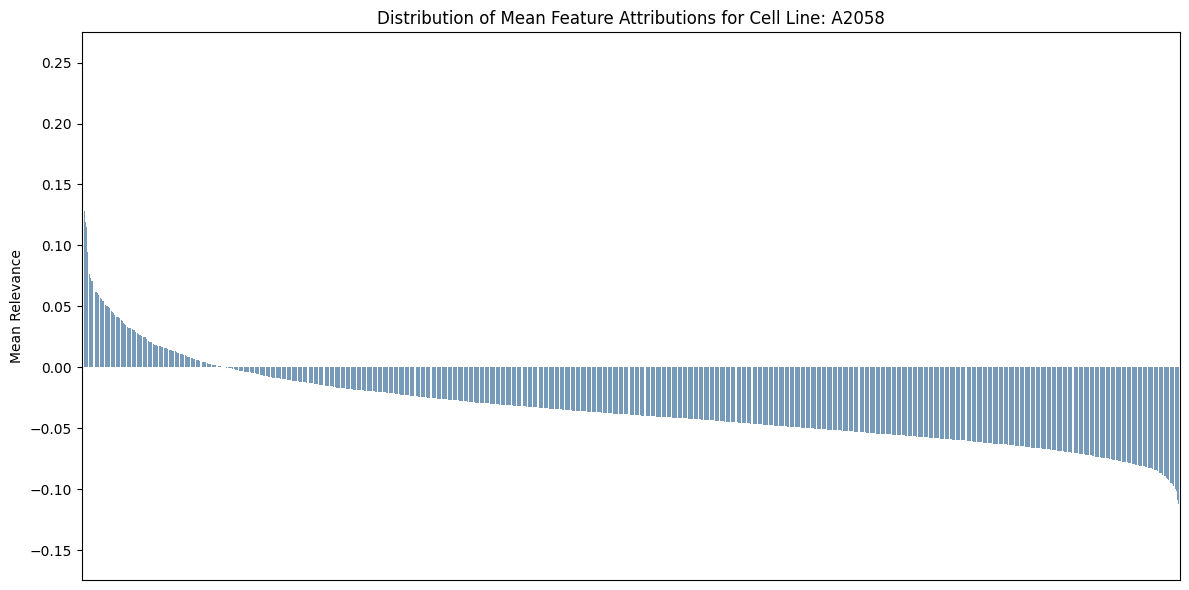

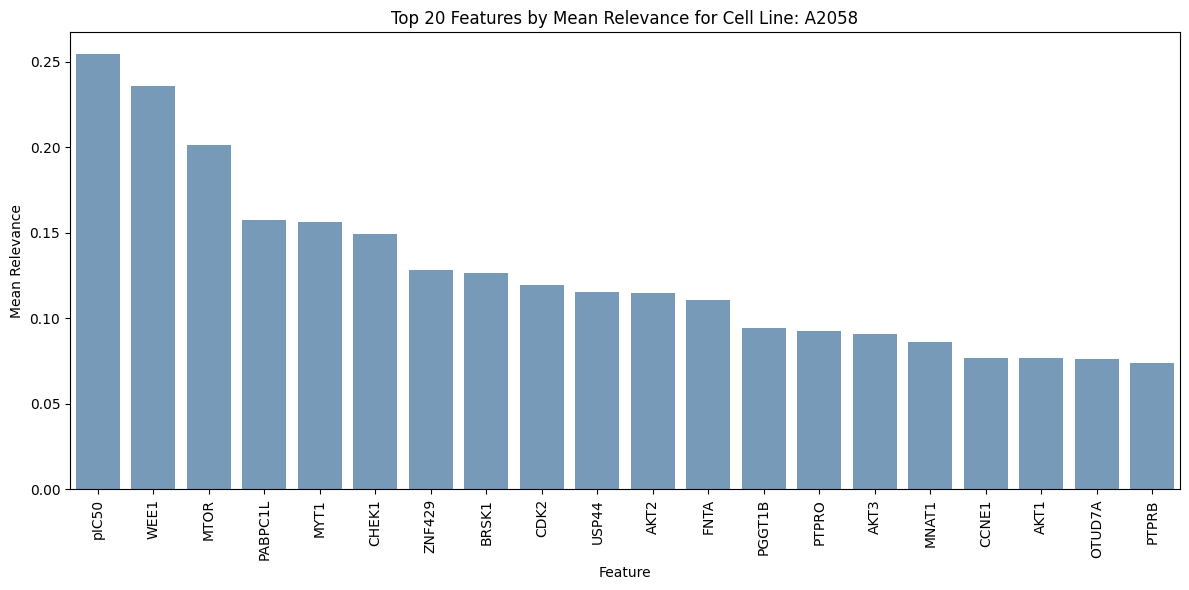

Top 20 Features for Cell Line: A2780 (Averaged! across relevances o 2 drug pairs)
MTOR: 0.3057
AKT2: 0.1554
AKT3: 0.1357
SLC7A13: 0.1310
ATG13: 0.1255
pIC50: 0.1224
PREX2: 0.1196
WEE1: 0.1154
AKT1: 0.1131
CRTC3: 0.1026
PABPC1L: 0.1003
TPTE2: 0.0895
MAST3: 0.0892
MYT1: 0.0882
ANKRD26: 0.0851
RPTOR: 0.0818
ZNF429: 0.0808
EGFR: 0.0806
STIM1: 0.0801
NKX3-1: 0.0800


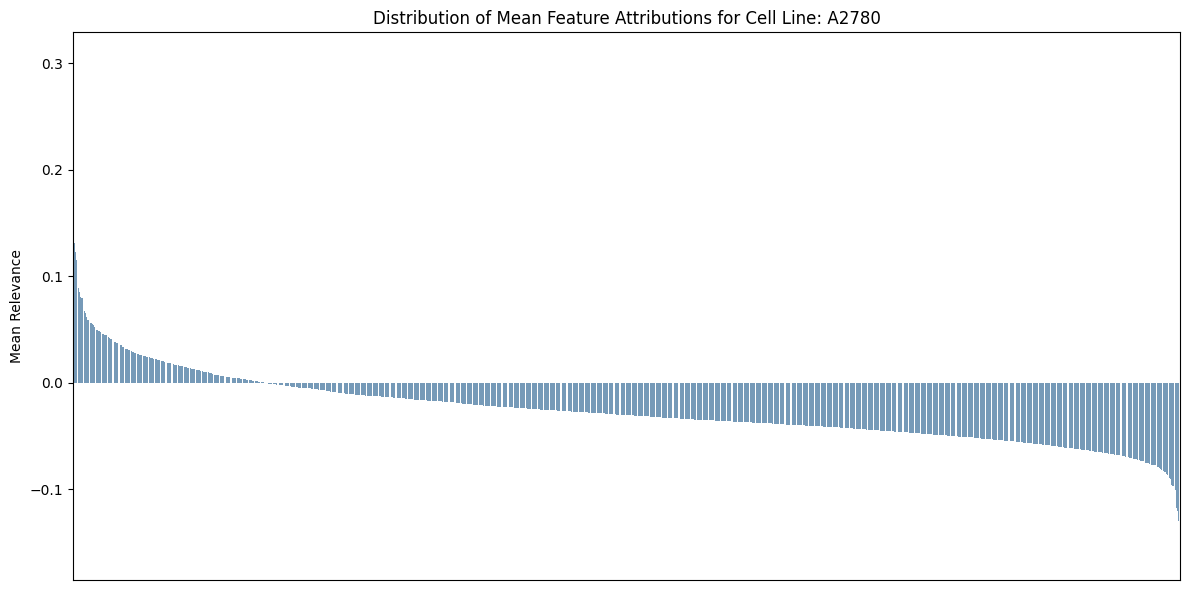

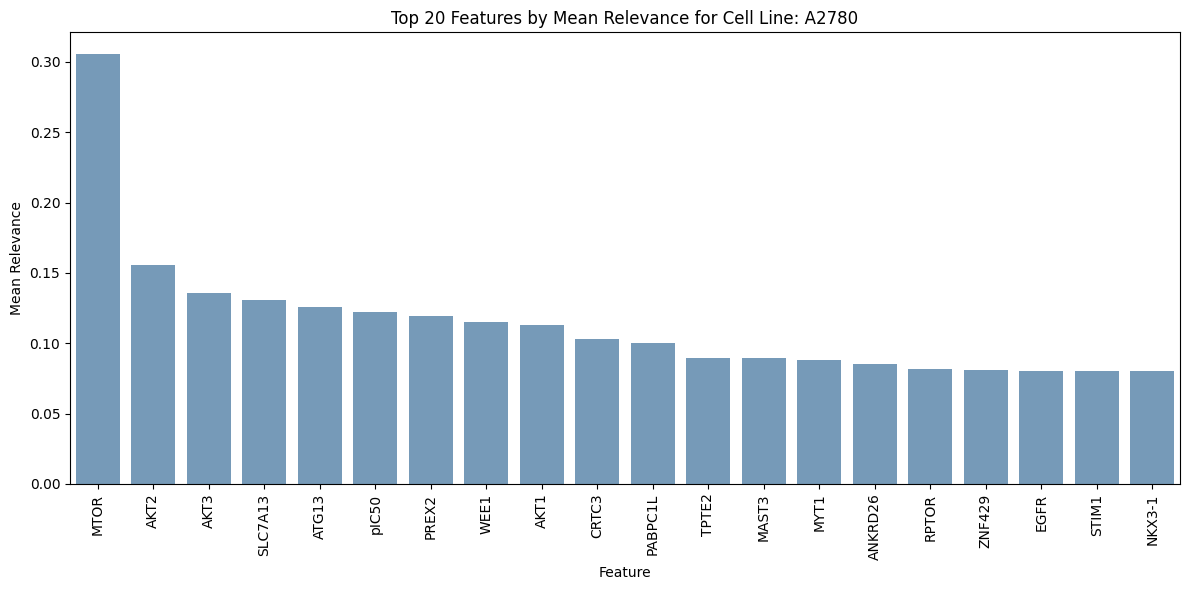

Top 20 Features for Cell Line: A375 (Averaged! across relevances o 2 drug pairs)
MTOR: 0.2945
pIC50: 0.2731
WEE1: 0.2632
PABPC1L: 0.1792
ZNF429: 0.1755
MYT1: 0.1614
USP44: 0.1369
TLR2: 0.1327
HMGN2P46: 0.1276
ZNF765: 0.1242
TUBA3C: 0.1240
BRSK1: 0.1188
SRD5A2: 0.1171
EMG1: 0.1164
PIK3R6: 0.1164
FAM47C: 0.1153
ZNF99: 0.1152
C15orf65: 0.1122
PRKDC: 0.1092
ATG13: 0.1074


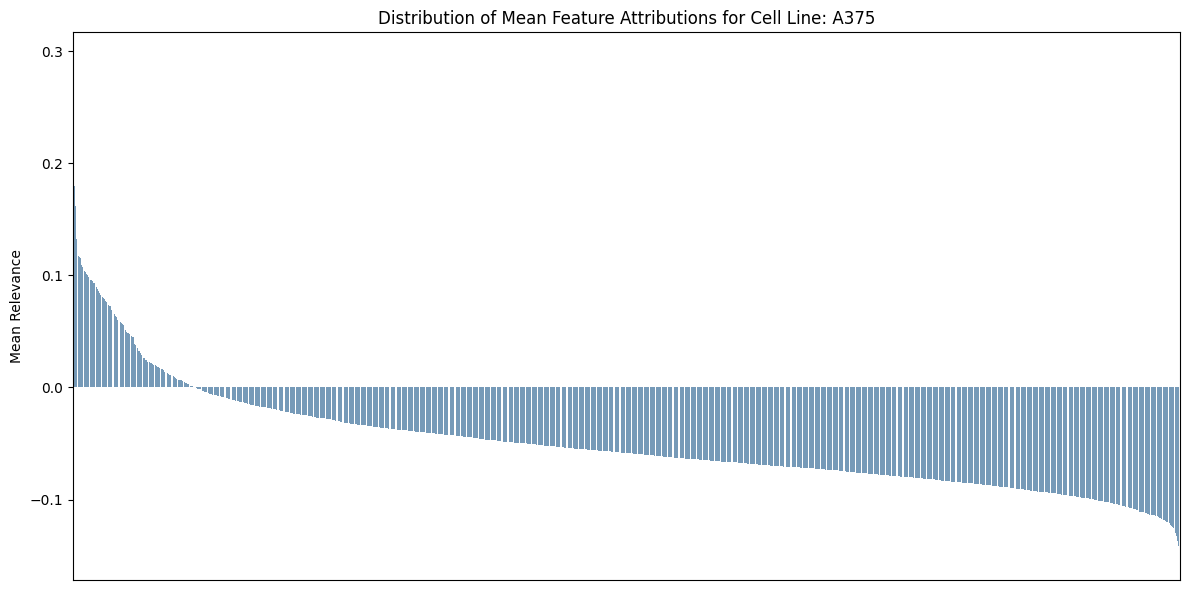

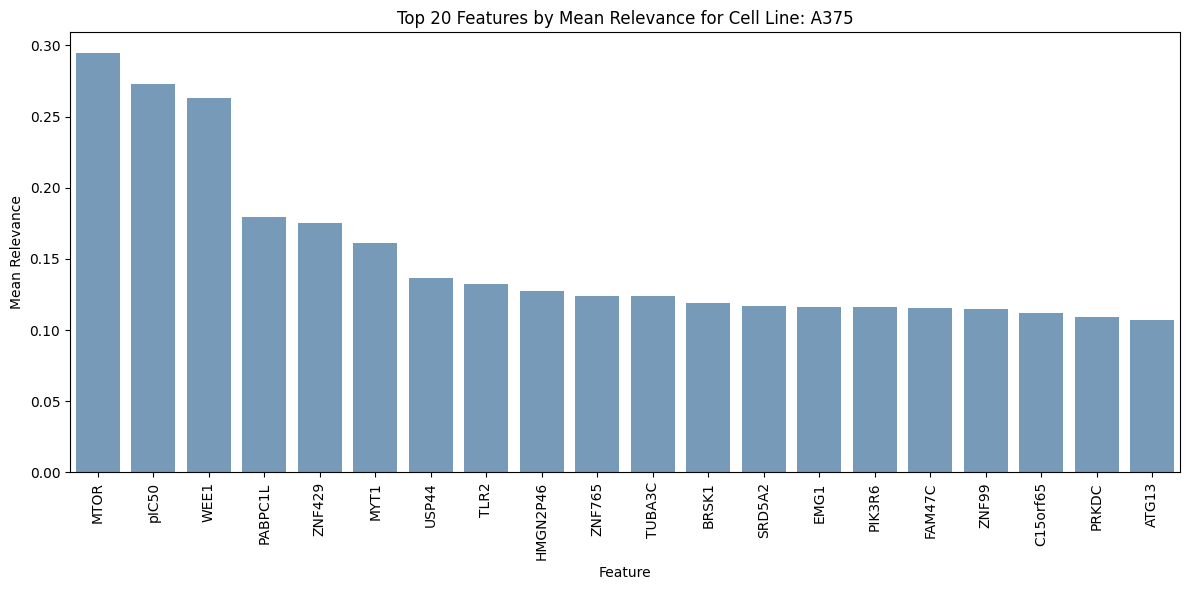

Top 20 Features for Cell Line: A427 (Averaged! across relevances o 2 drug pairs)
MTOR: 0.2105
pIC50: 0.1531
WEE1: 0.0967
FNTA: 0.0958
AKT2: 0.0901
PGGT1B: 0.0853
AKT3: 0.0721
PREX2: 0.0681
MAST3: 0.0675
MYT1: 0.0660
ATG13: 0.0653
PABPC1L: 0.0651
SLC7A13: 0.0631
CHEK1: 0.0617
AKT1: 0.0606
RHOB: 0.0603
CRTC3: 0.0590
RRAS2: 0.0550
TRERF1: 0.0524
STIM1: 0.0517


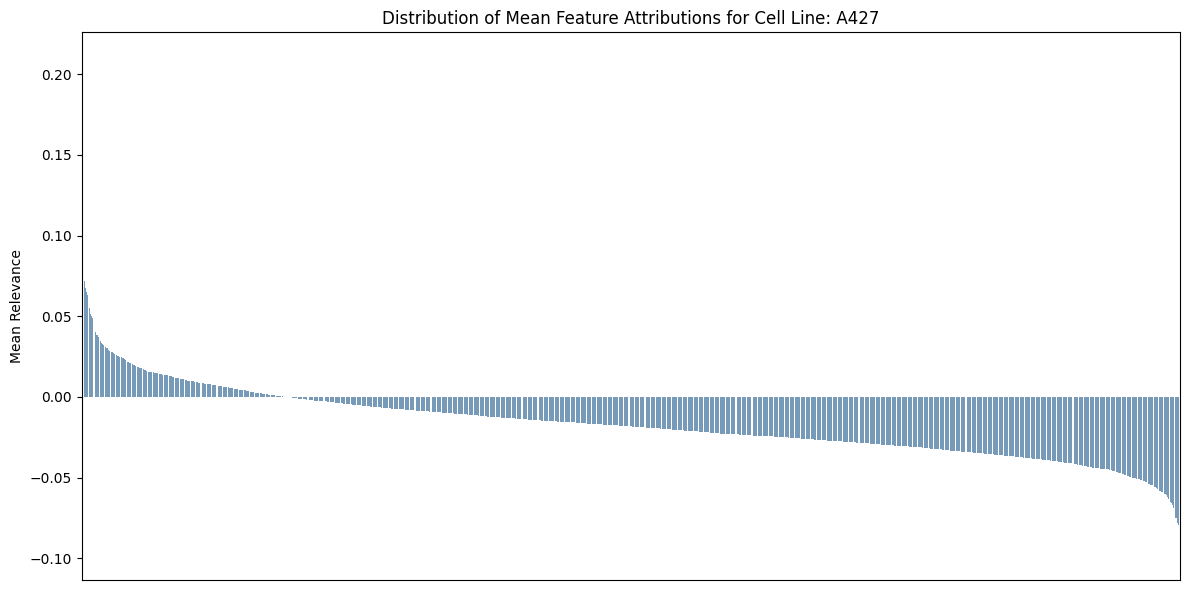

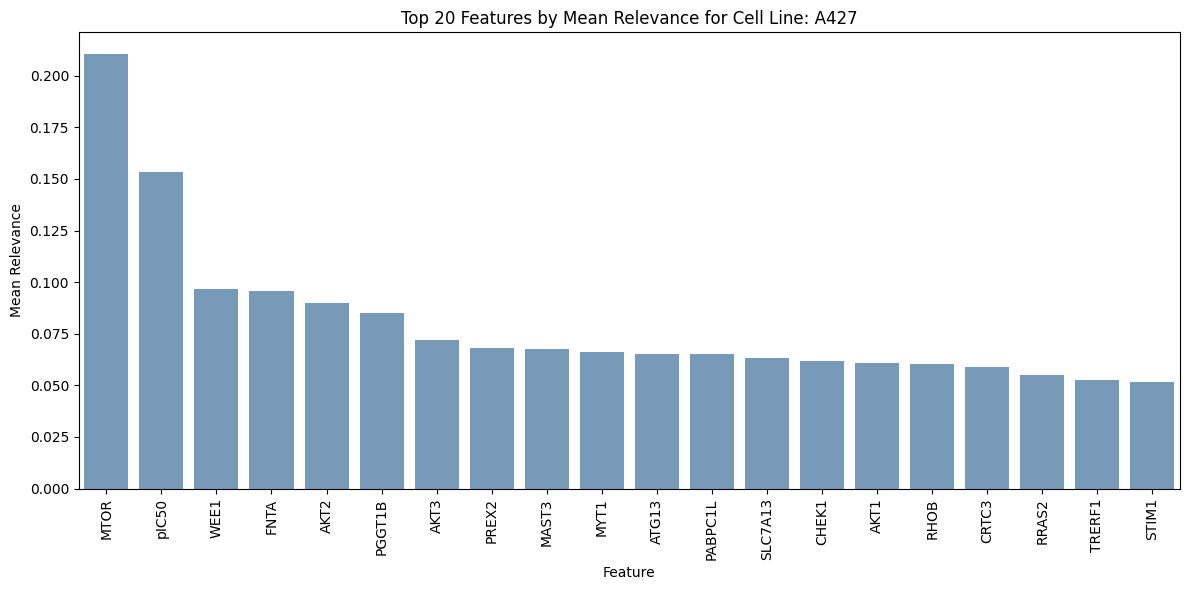

Top 20 Features for Cell Line: CAOV3 (Averaged! across relevances o 2 drug pairs)
MTOR: 0.2219
TOP2A: 0.1939
pIC50: 0.1753
AKT2: 0.1721
TOP2B: 0.1653
AKT3: 0.1616
AKT1: 0.1305
WEE1: 0.1303
EGFR: 0.1169
NR1I2: 0.1162
ATG13: 0.1095
PREX2: 0.1072
MYT1: 0.1013
SLC7A13: 0.0974
C15orf65: 0.0932
HMGN2P46: 0.0915
PABPC1L: 0.0866
FAM117A: 0.0854
HOXA10: 0.0850
CRTC3: 0.0843


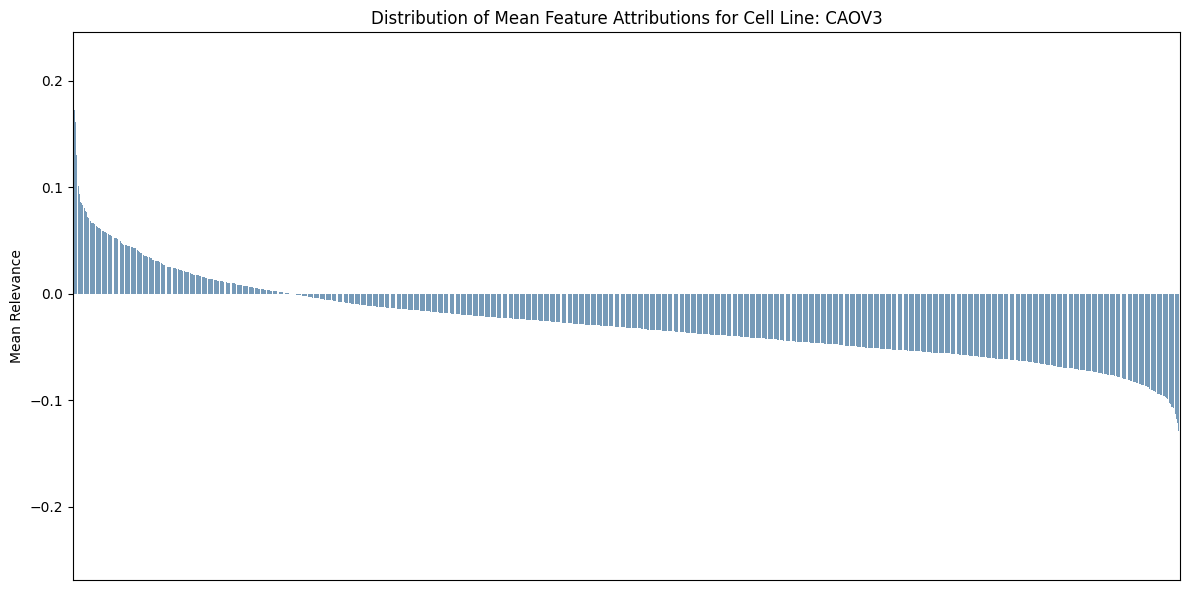

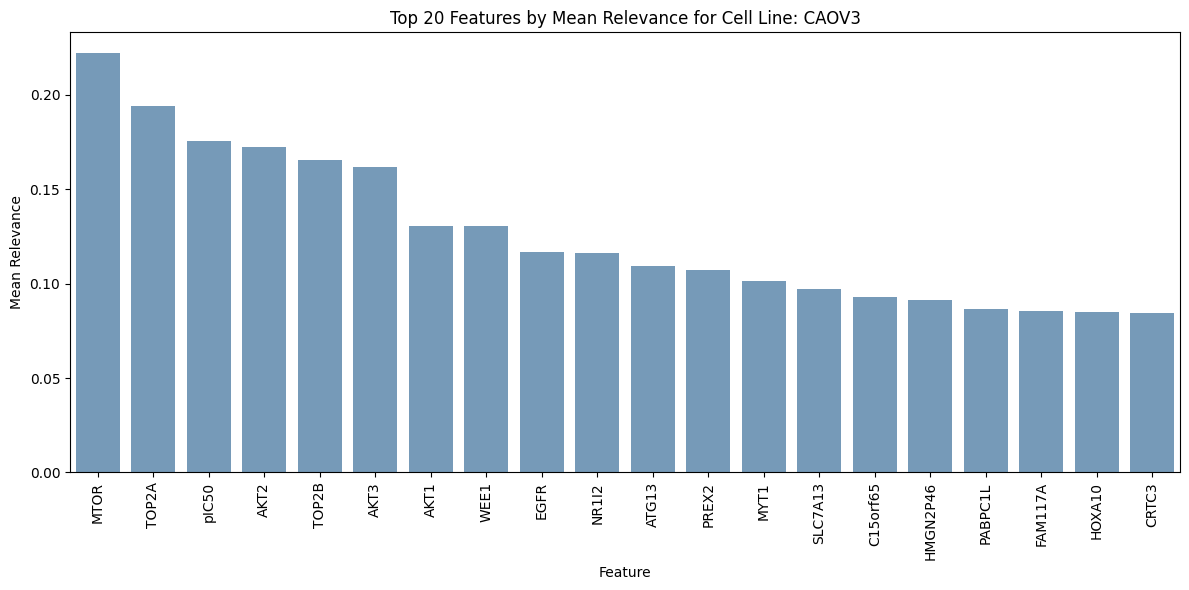

Top 20 Features for Cell Line: DLD1 (Averaged! across relevances o 2 drug pairs)
MTOR: 0.2308
EGFR: 0.1333
NR1I2: 0.1320
WEE1: 0.1209
pIC50: 0.1197
ZNF429: 0.1045
SULT1B1: 0.0989
SLC7A13: 0.0982
ATG13: 0.0957
PABPC1L: 0.0920
SRD5A2: 0.0857
PREX2: 0.0783
TLR2: 0.0781
HMGN2P46: 0.0781
TUBA3C: 0.0766
FAM47C: 0.0764
AKT3: 0.0749
AKT2: 0.0746
CLEC19A: 0.0741
ZNF765: 0.0740


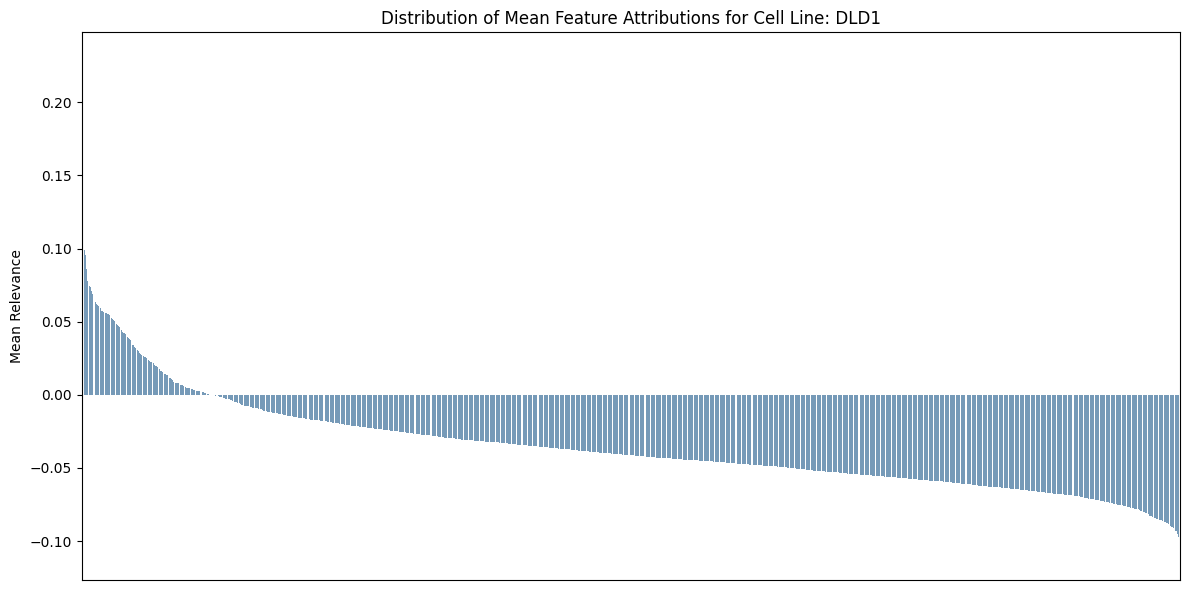

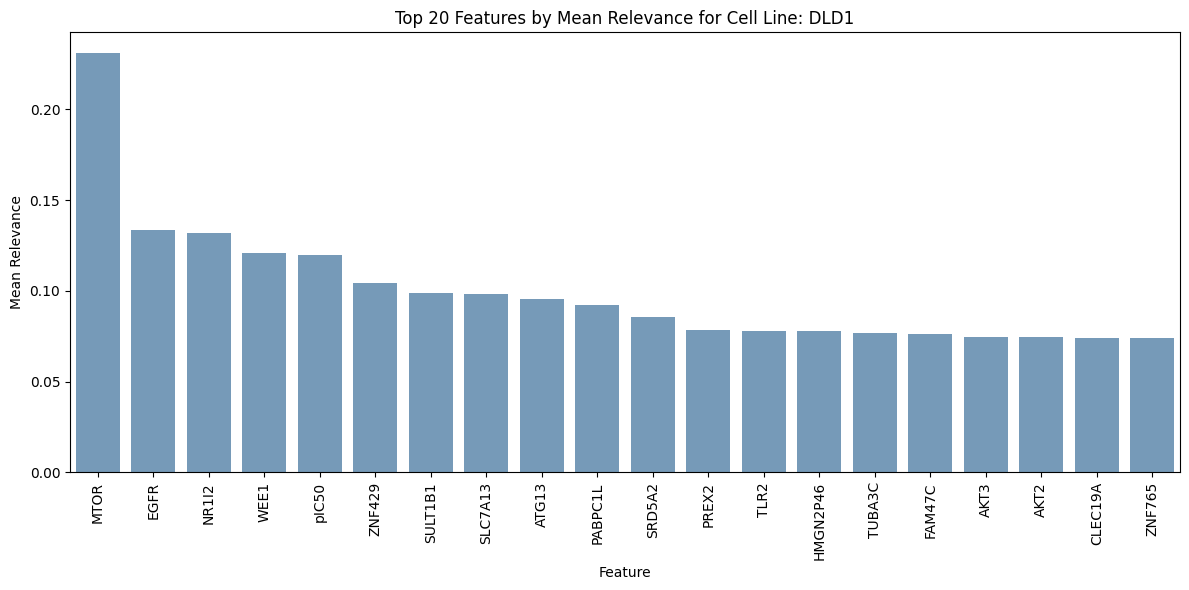

Top 20 Features for Cell Line: ES2 (Averaged! across relevances o 2 drug pairs)
MTOR: 0.1825
pIC50: 0.1116
WEE1: 0.0906
ATG13: 0.0898
SLC7A13: 0.0802
ZNF429: 0.0787
PABPC1L: 0.0724
PREX2: 0.0685
EGFR: 0.0665
ANKRD26: 0.0618
CRTC3: 0.0594
STIM1: 0.0589
MYT1: 0.0576
MAST3: 0.0570
TUBB: 0.0545
SLC16A3: 0.0521
USP44: 0.0486
PLCH2: 0.0474
TLR2: 0.0465
FOXR2: 0.0451


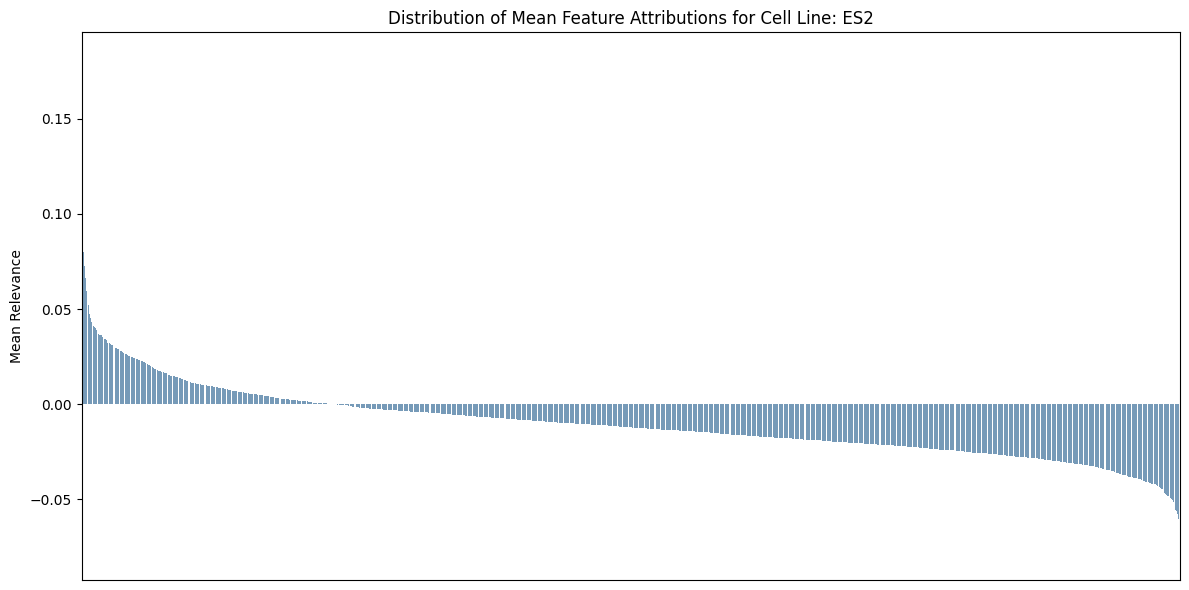

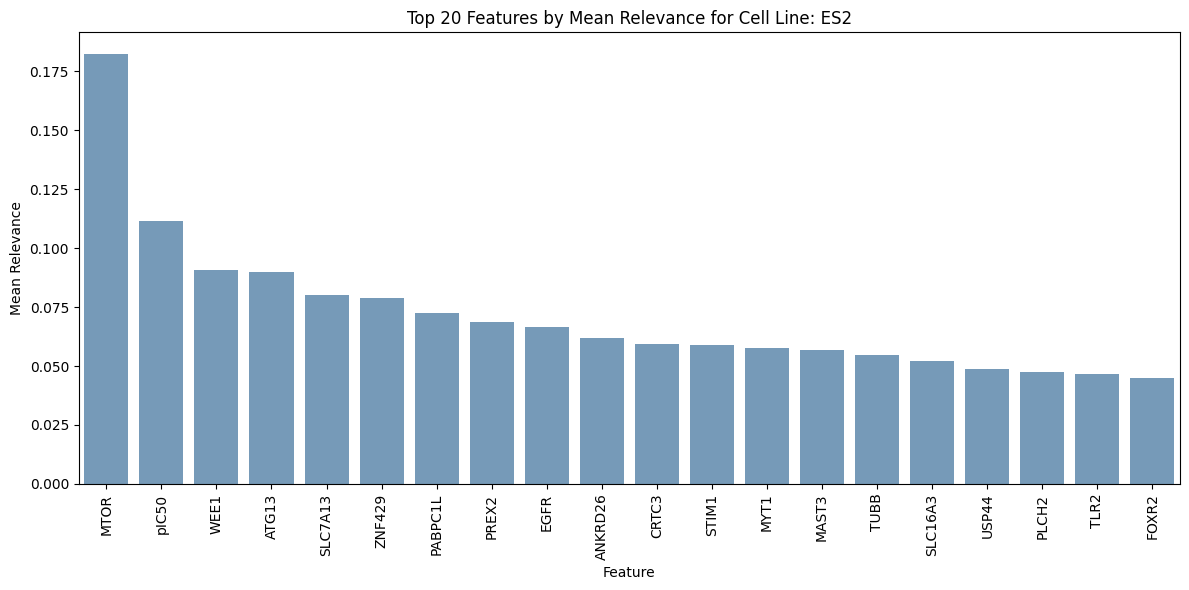

Top 20 Features for Cell Line: HCT116 (Averaged! across relevances o 2 drug pairs)
MTOR: 0.1026
WEE1: 0.0746
EGFR: 0.0707
NR1I2: 0.0626
AKT3: 0.0608
AKT2: 0.0608
AKT1: 0.0569
PABPC1L: 0.0526
MYT1: 0.0499
pIC50: 0.0478
SULT1B1: 0.0438
ATG13: 0.0435
ZNF429: 0.0398
RHOB: 0.0383
PGGT1B: 0.0361
PREX2: 0.0355
SLCO1B1: 0.0347
CRTC3: 0.0345
BRSK1: 0.0328
NKX3-1: 0.0327


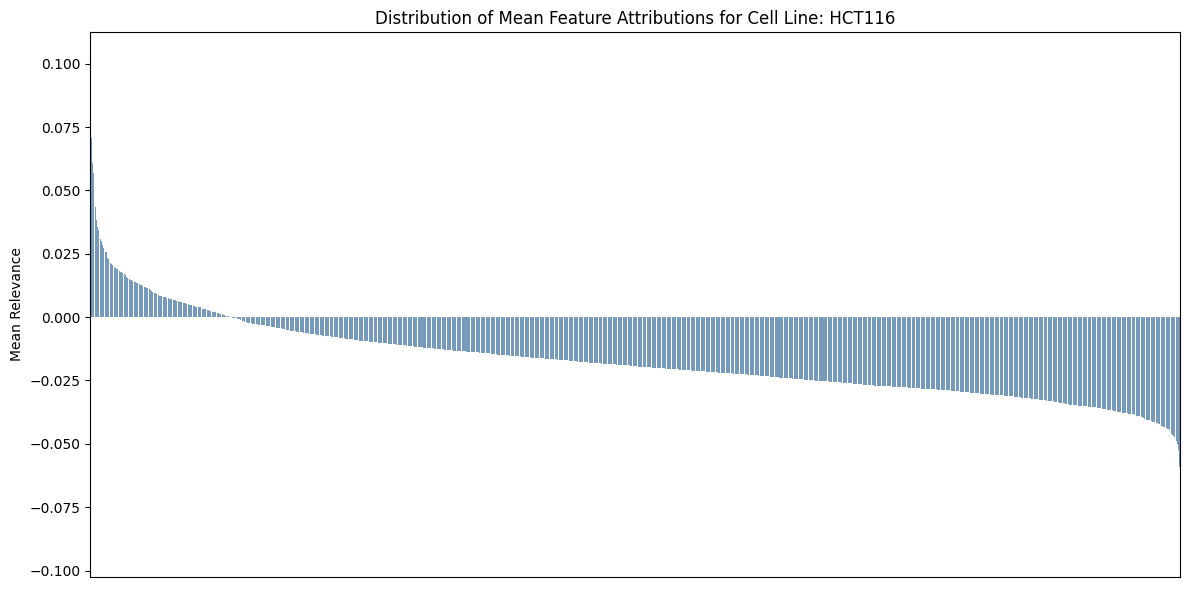

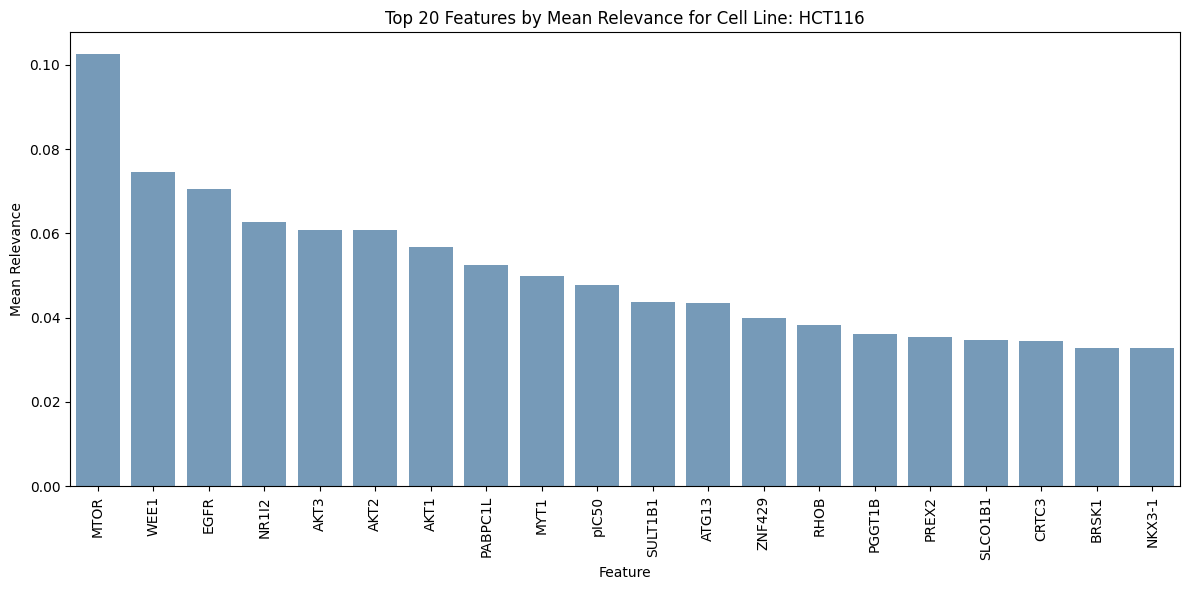

Top 20 Features for Cell Line: HT144 (Averaged! across relevances o 2 drug pairs)
MTOR: 0.1676
WEE1: 0.1449
EGFR: 0.0913
ZNF429: 0.0865
PABPC1L: 0.0861
MYT1: 0.0854
ATG13: 0.0836
SLC7A13: 0.0777
AKT1: 0.0707
CRTC3: 0.0702
TPTE2: 0.0700
STIM1: 0.0685
PREX2: 0.0668
USP44: 0.0657
NALCN: 0.0595
AKT3: 0.0589
TACR1: 0.0571
TOP1: 0.0562
PLCH2: 0.0556
SLC16A3: 0.0527


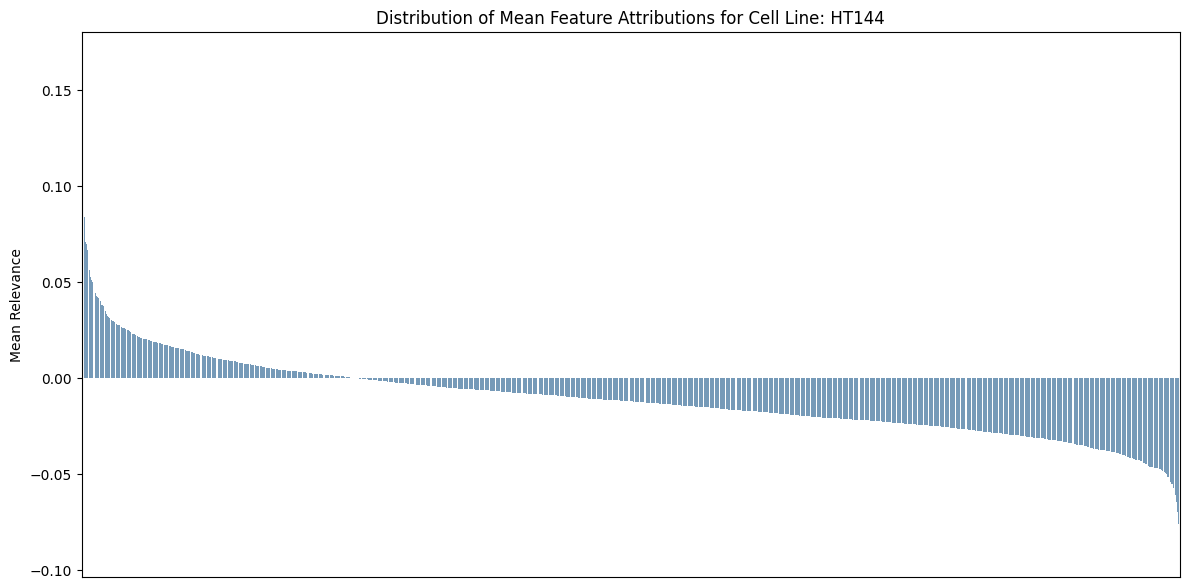

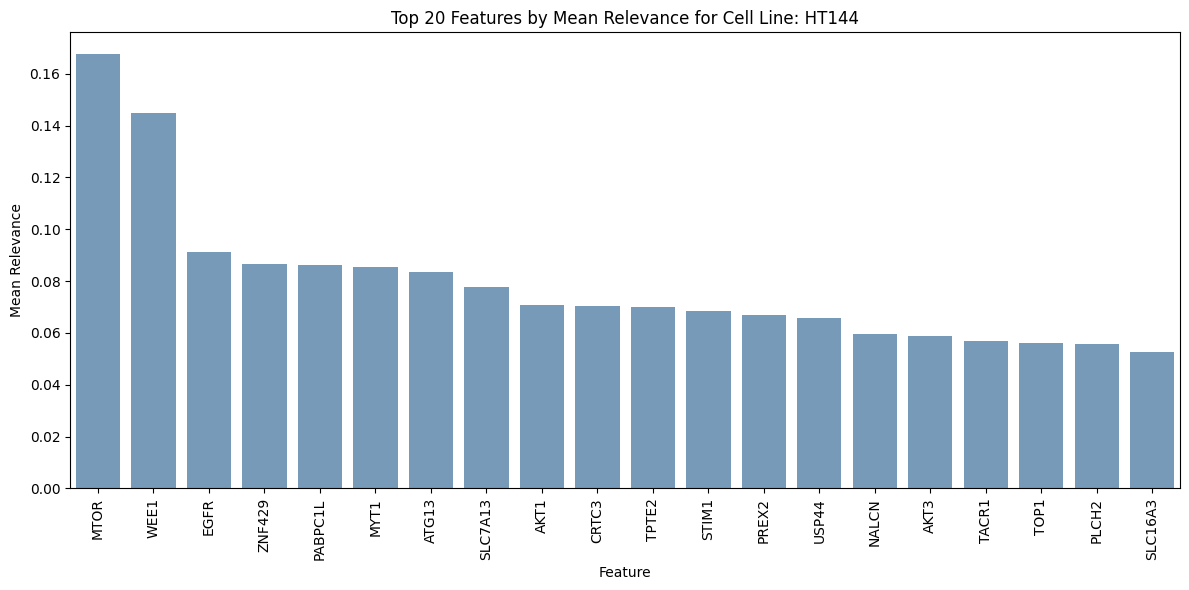

Top 20 Features for Cell Line: HT29 (Averaged! across relevances o 2 drug pairs)
MTOR: 0.2429
AKT2: 0.1318
WEE1: 0.1311
AKT1: 0.1220
AKT3: 0.1183
ATG13: 0.1065
PABPC1L: 0.1062
SLC7A13: 0.1050
CRTC3: 0.1025
PREX2: 0.0971
MYT1: 0.0918
EGFR: 0.0856
NR1I2: 0.0854
ZNF429: 0.0839
TPTE2: 0.0838
FNTA: 0.0814
PGGT1B: 0.0791
STIM1: 0.0729
TRERF1: 0.0721
RPTOR: 0.0654


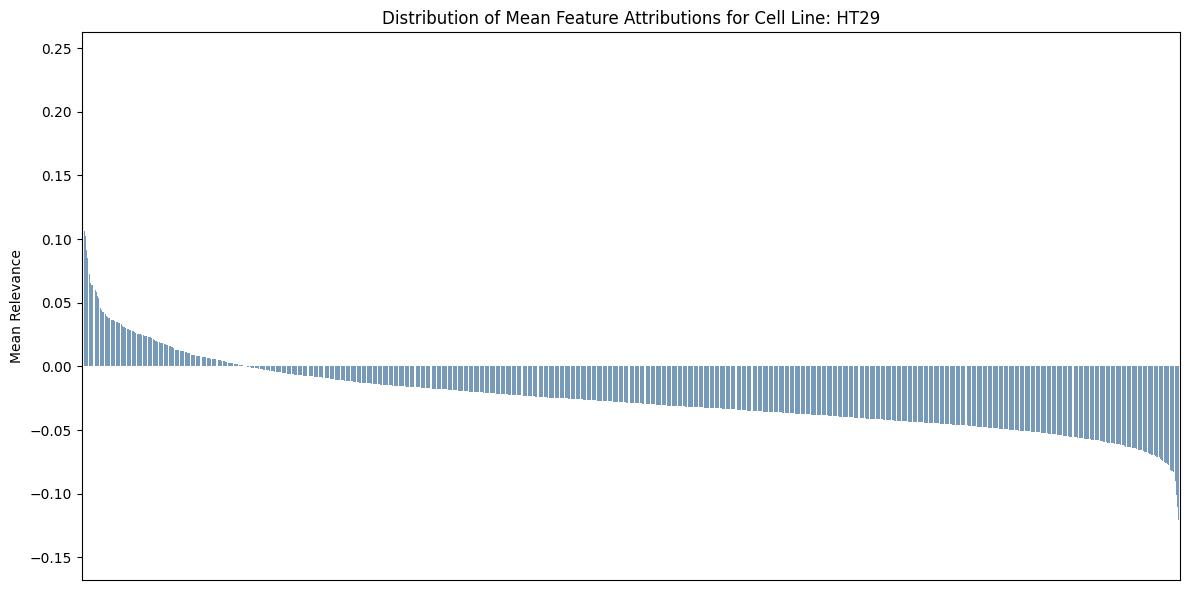

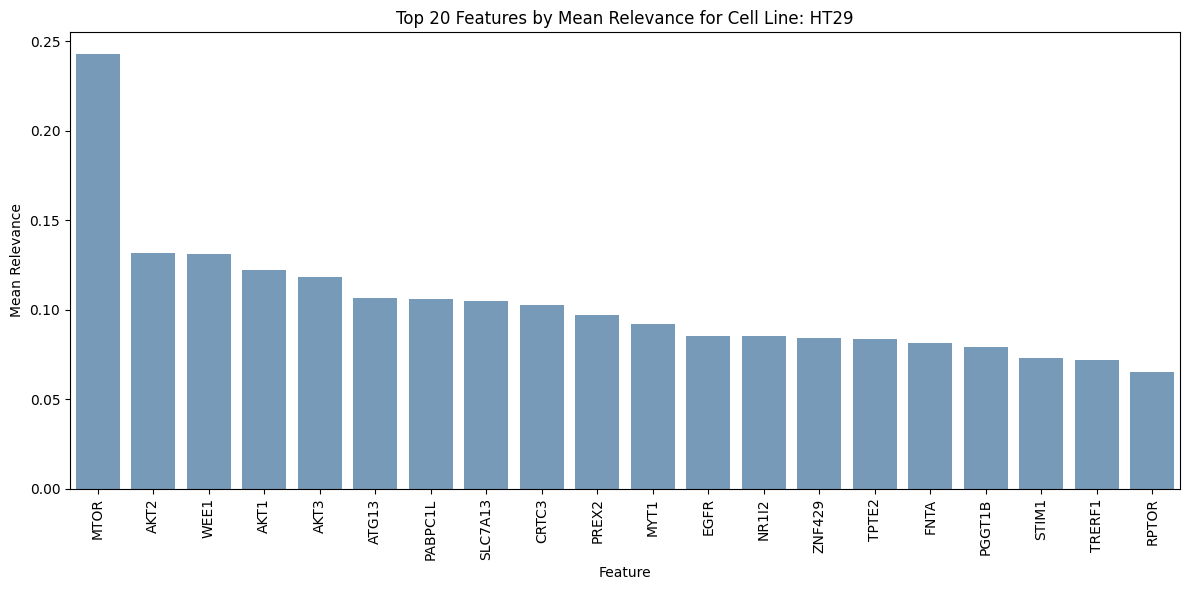

Top 20 Features for Cell Line: KPL1 (Averaged! across relevances o 2 drug pairs)
MTOR: 0.2826
AKT3: 0.1306
AKT2: 0.1301
SLC7A13: 0.1274
ATG13: 0.1225
pIC50: 0.1136
PREX2: 0.1081
CRTC3: 0.1068
STIM1: 0.0945
AKT1: 0.0887
TRPM2: 0.0870
WEE1: 0.0853
PLCH2: 0.0841
TLR2: 0.0840
ANKRD26: 0.0814
TRERF1: 0.0814
MAST3: 0.0801
SRD5A2: 0.0781
RPTOR: 0.0749
HMGN2P46: 0.0745


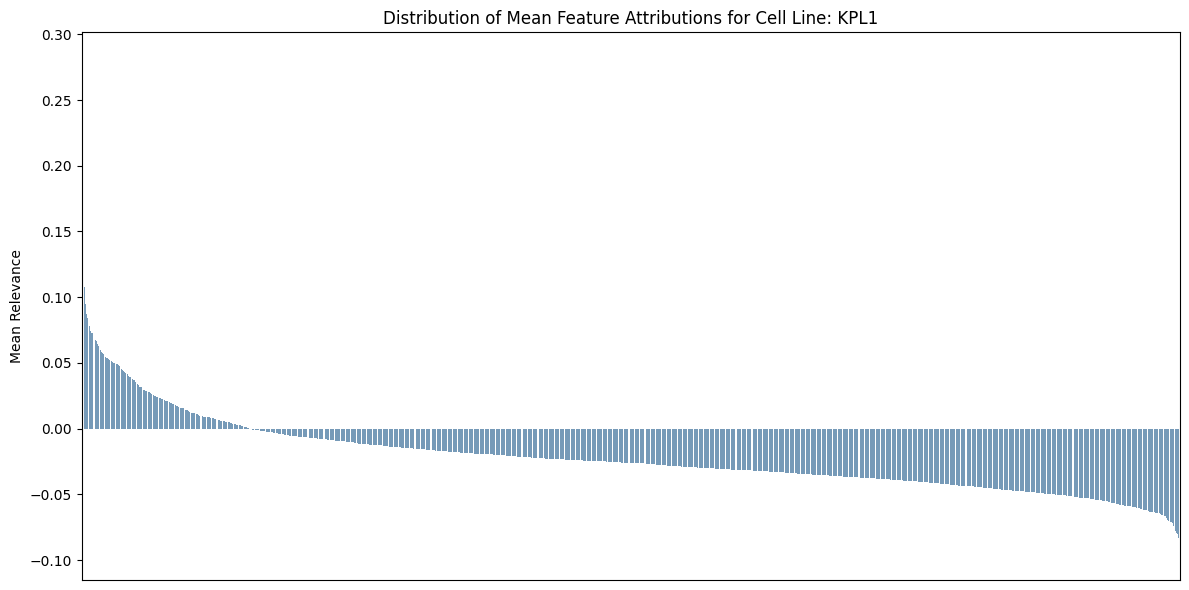

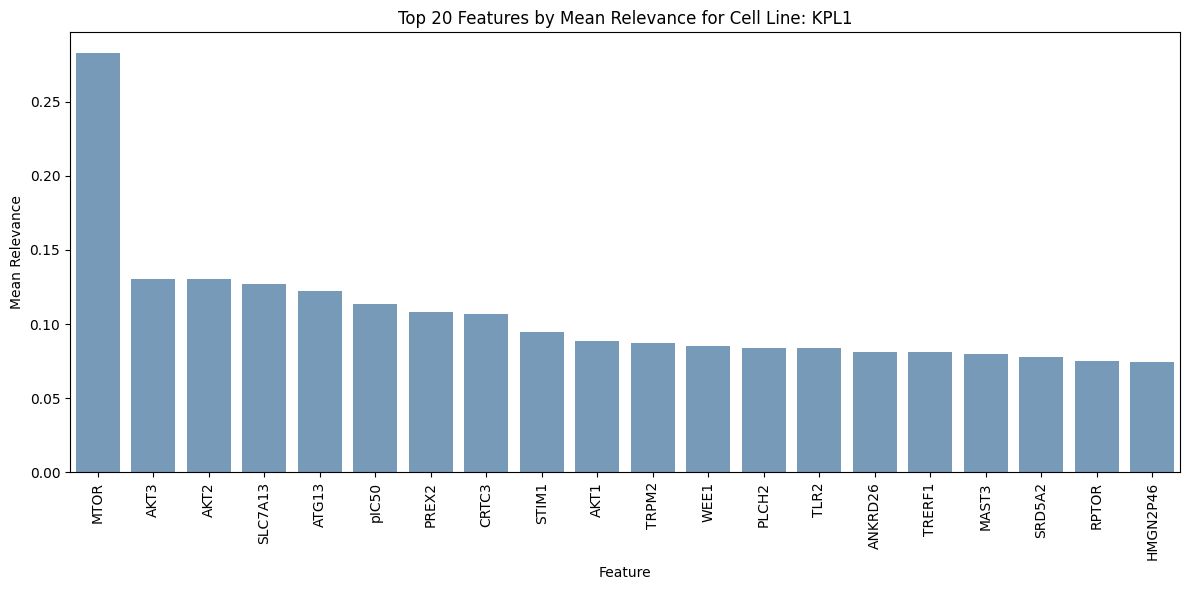

Top 20 Features for Cell Line: LOVO (Averaged! across relevances o 2 drug pairs)
MTOR: 0.2279
EGFR: 0.2171
NR1I2: 0.1302
pIC50: 0.1159
ERBB4: 0.1152
ATG13: 0.1132
SLC7A13: 0.1129
PREX2: 0.1022
AKT2: 0.0990
ERBB2: 0.0982
AKT3: 0.0930
SULT1B1: 0.0843
RPTOR: 0.0835
LRIG2: 0.0789
CRTC3: 0.0758
AKT1: 0.0751
ANKRD26: 0.0723
HMGN2P46: 0.0716
TPTE2: 0.0706
NRG2: 0.0683


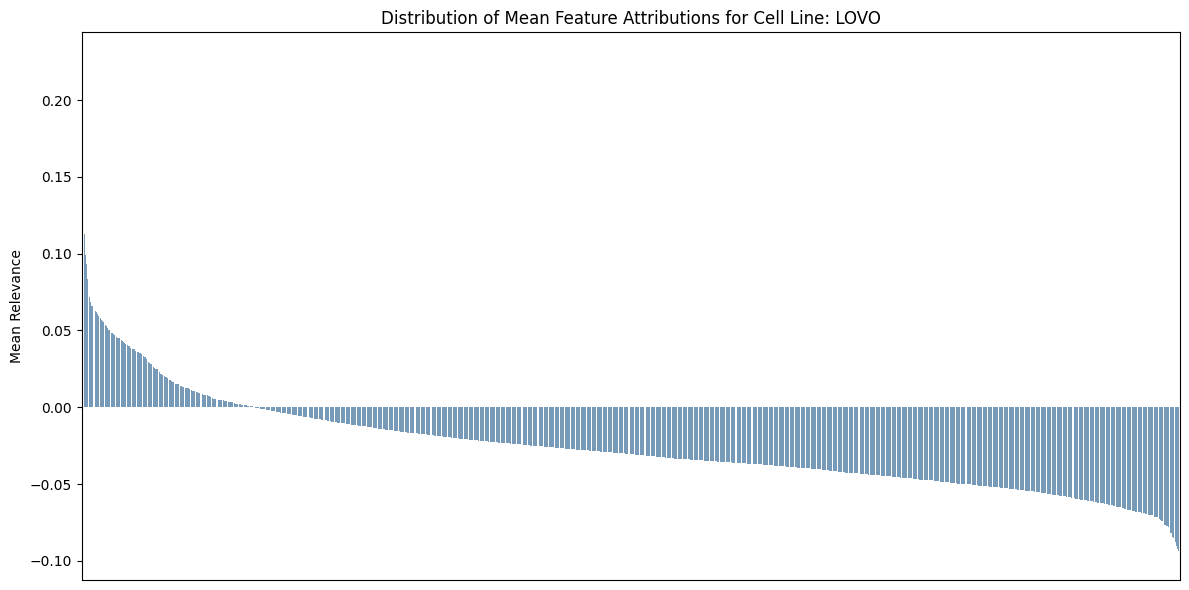

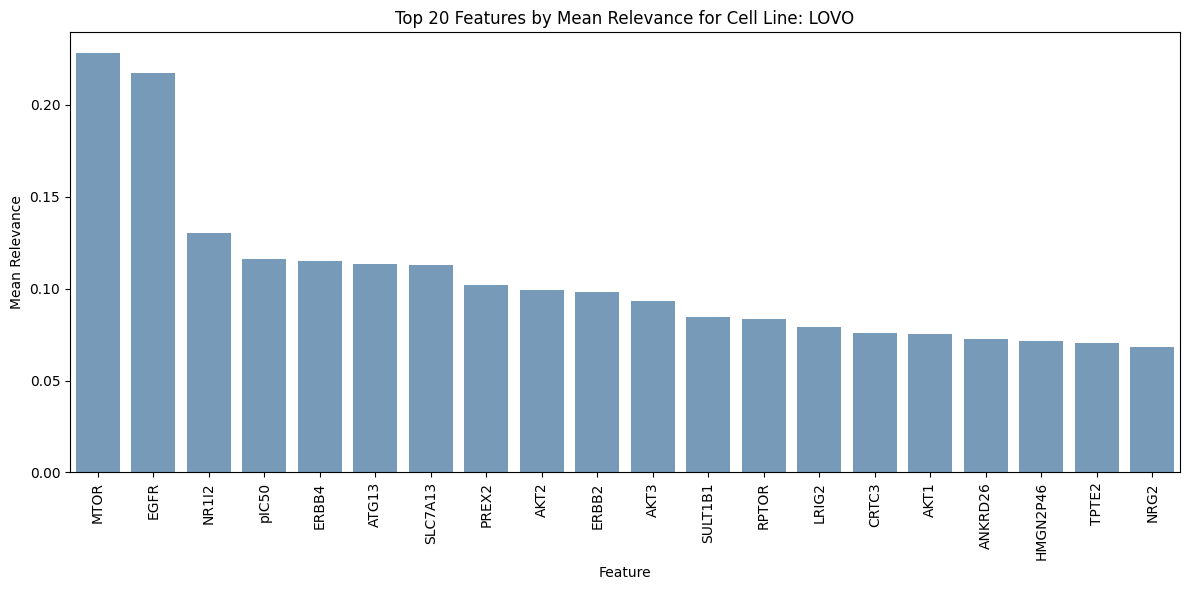

Top 20 Features for Cell Line: MDAMB436 (Averaged! across relevances o 2 drug pairs)
WEE1: 0.1146
MTOR: 0.1130
PABPC1L: 0.0832
pIC50: 0.0822
ZNF429: 0.0784
MYT1: 0.0728
AKT2: 0.0555
USP44: 0.0543
TLR2: 0.0524
BRSK1: 0.0523
HMGN2P46: 0.0481
TUBA3C: 0.0458
C15orf65: 0.0454
ATG13: 0.0439
PIK3R6: 0.0429
FAM47C: 0.0427
SLC7A13: 0.0422
NALCN: 0.0416
PDCD6: 0.0412
AKT3: 0.0405


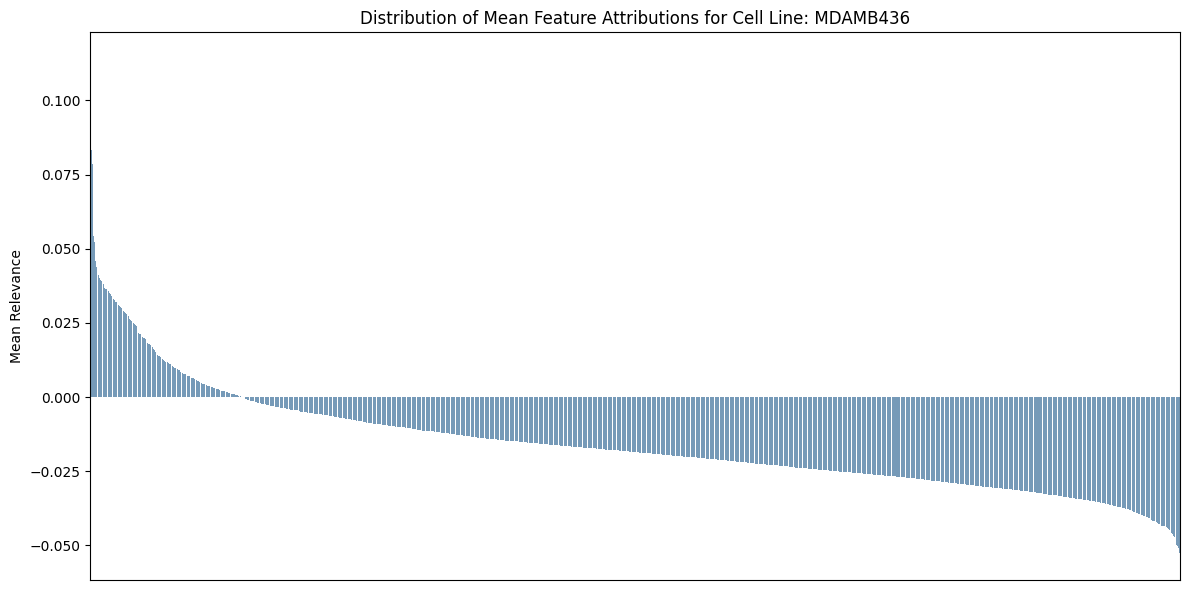

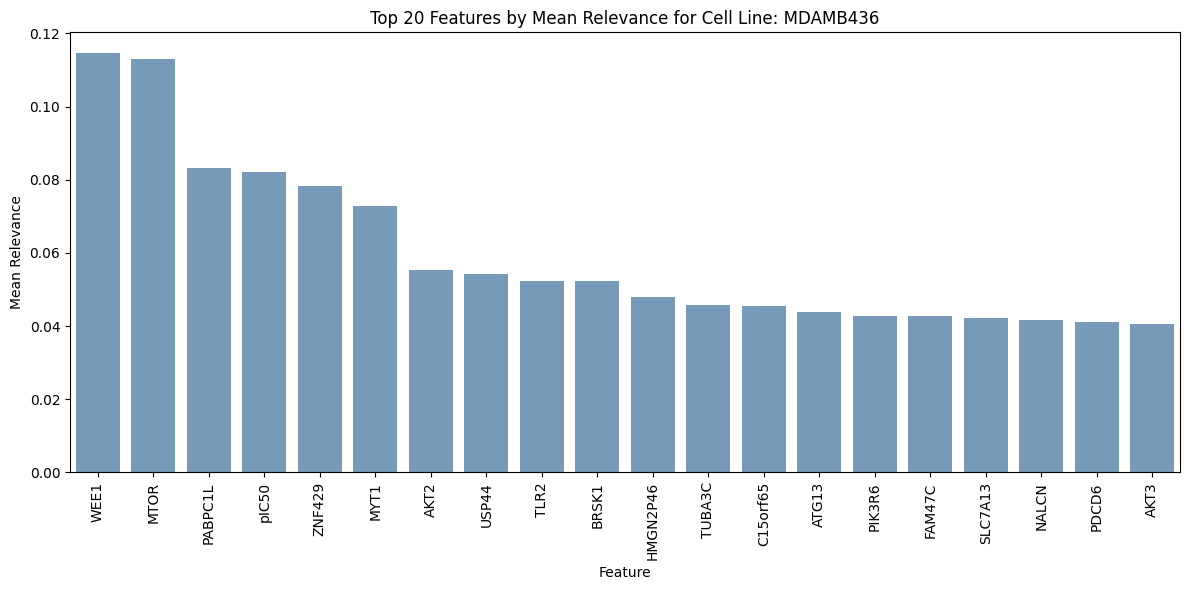

Top 20 Features for Cell Line: MSTO (Averaged! across relevances o 2 drug pairs)
MTOR: 0.2867
HMGN2P46: 0.1958
pIC50: 0.1935
TUBB: 0.1732
CUX1: 0.1645
FAM47C: 0.1630
TLR2: 0.1617
APLNR: 0.1579
HOXA10: 0.1558
TUBA3C: 0.1555
KRTAP4-5: 0.1542
PIK3R6: 0.1541
SRD5A2: 0.1531
NAIP: 0.1522
FNTB: 0.1520
CCDC178: 0.1511
H3C8: 0.1486
OR2T35: 0.1484
CDK3: 0.1479
LYN: 0.1478


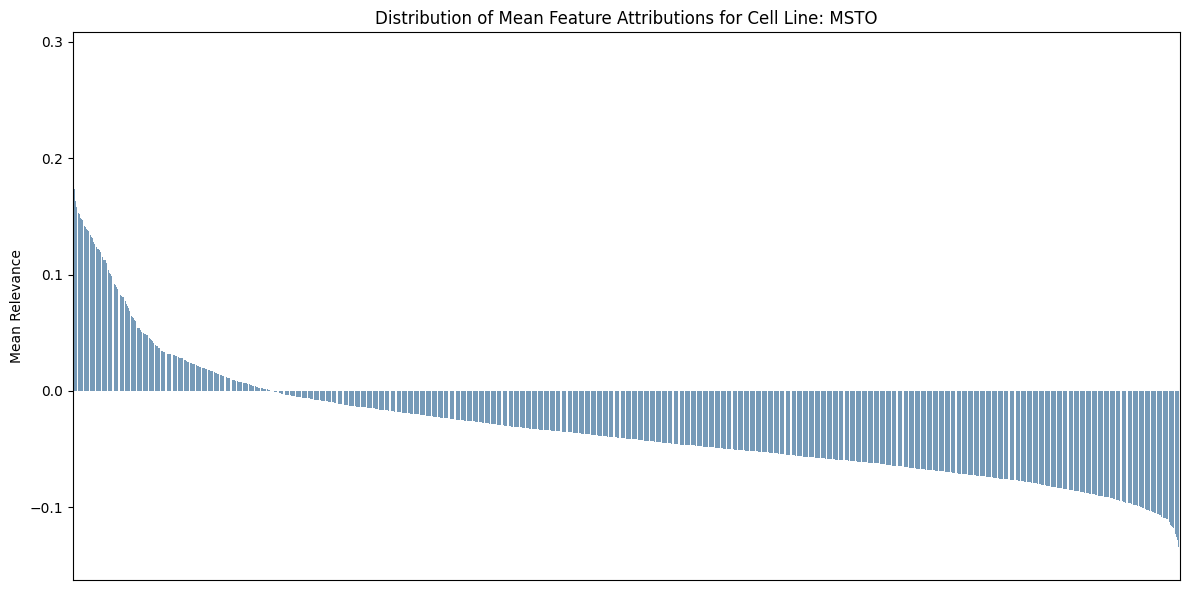

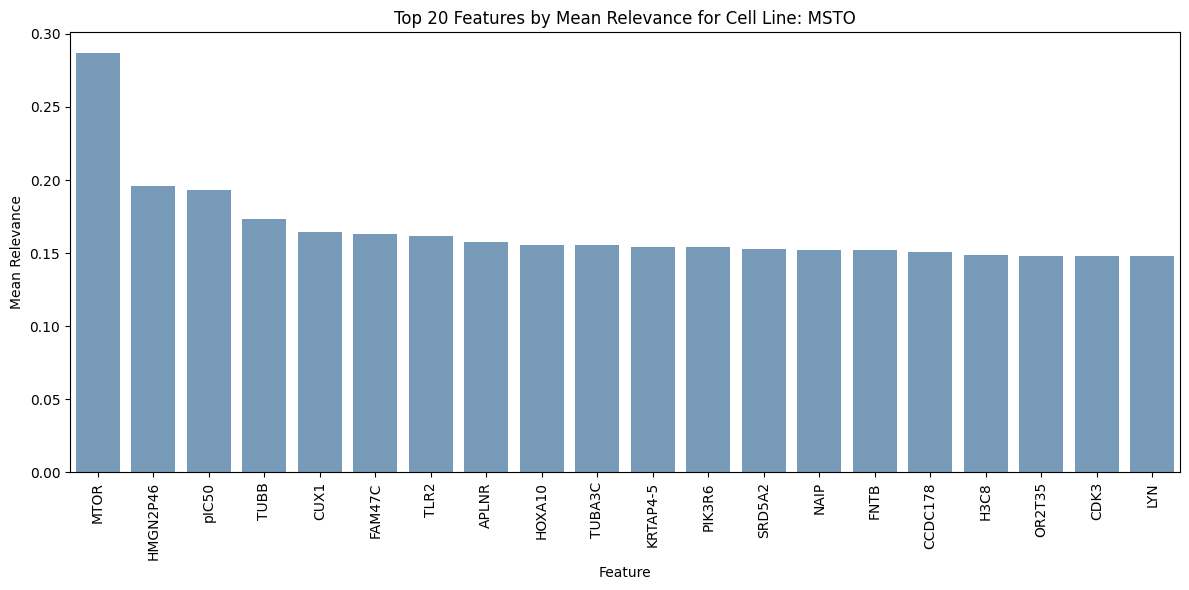

Top 20 Features for Cell Line: NCIH1650 (Averaged! across relevances o 2 drug pairs)
MTOR: 0.3074
WEE1: 0.1558
SLC7A13: 0.1404
ATG13: 0.1338
AKT2: 0.1325
PREX2: 0.1248
AKT3: 0.1212
CRTC3: 0.1143
PABPC1L: 0.1045
AKT1: 0.1031
TPTE2: 0.1014
MYT1: 0.1005
ZNF429: 0.0985
EGFR: 0.0980
STIM1: 0.0966
MAST3: 0.0908
TRERF1: 0.0907
PLCH2: 0.0865
NR1I2: 0.0847
ANKRD26: 0.0828


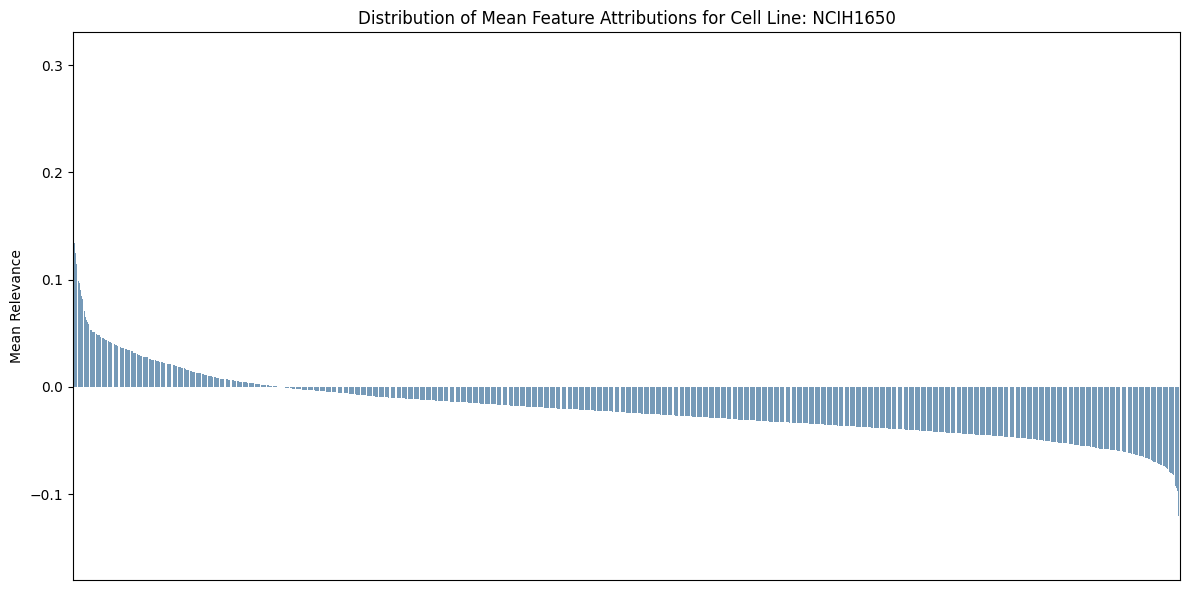

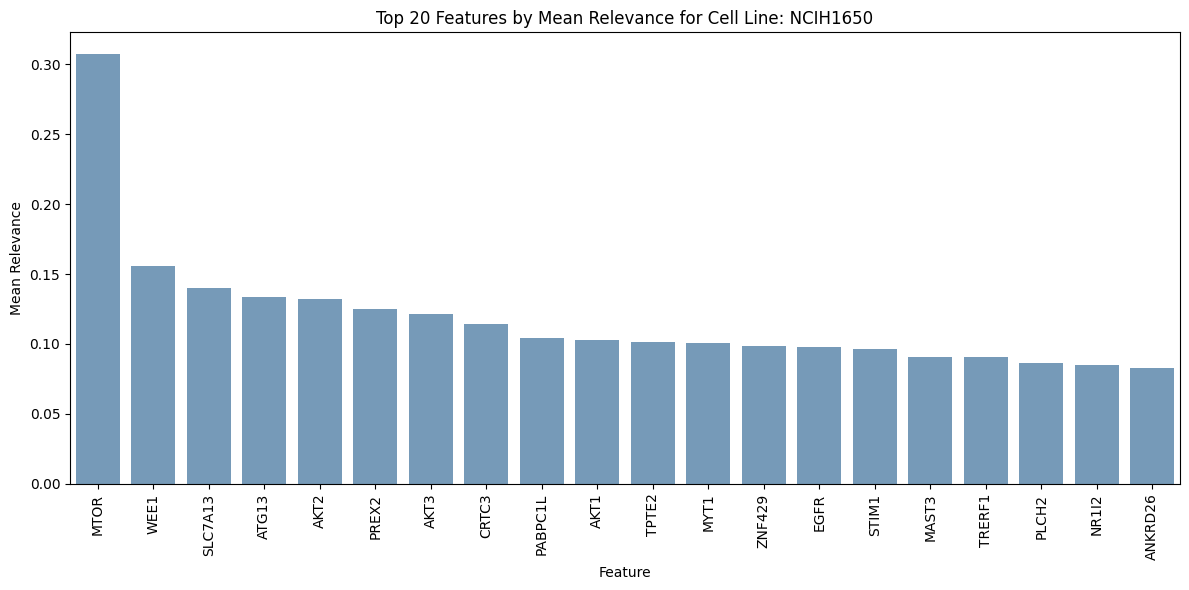

Top 20 Features for Cell Line: NCIH2122 (Averaged! across relevances o 2 drug pairs)
EGFR: 0.2116
NR1I2: 0.2019
AKT1: 0.1626
AKT3: 0.1439
NR1H4: 0.1228
TCL1A: 0.1185
MTOR: 0.1145
AKT2: 0.1113
ERBB4: 0.1045
DMD: 0.1003
NKX3-1: 0.0989
NCOR1: 0.0986
SLCO1B1: 0.0983
CYP2E1: 0.0969
NCOR2: 0.0940
ELAVL3: 0.0936
ABCG8: 0.0912
ERBB2: 0.0892
FOXA2: 0.0864
HNF1A: 0.0851


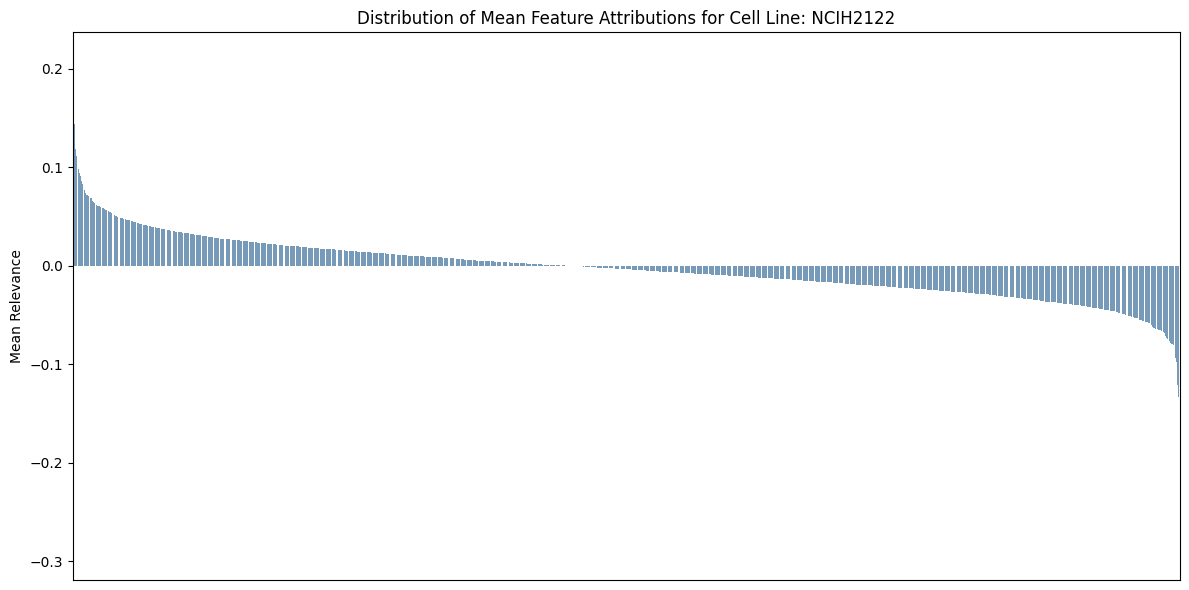

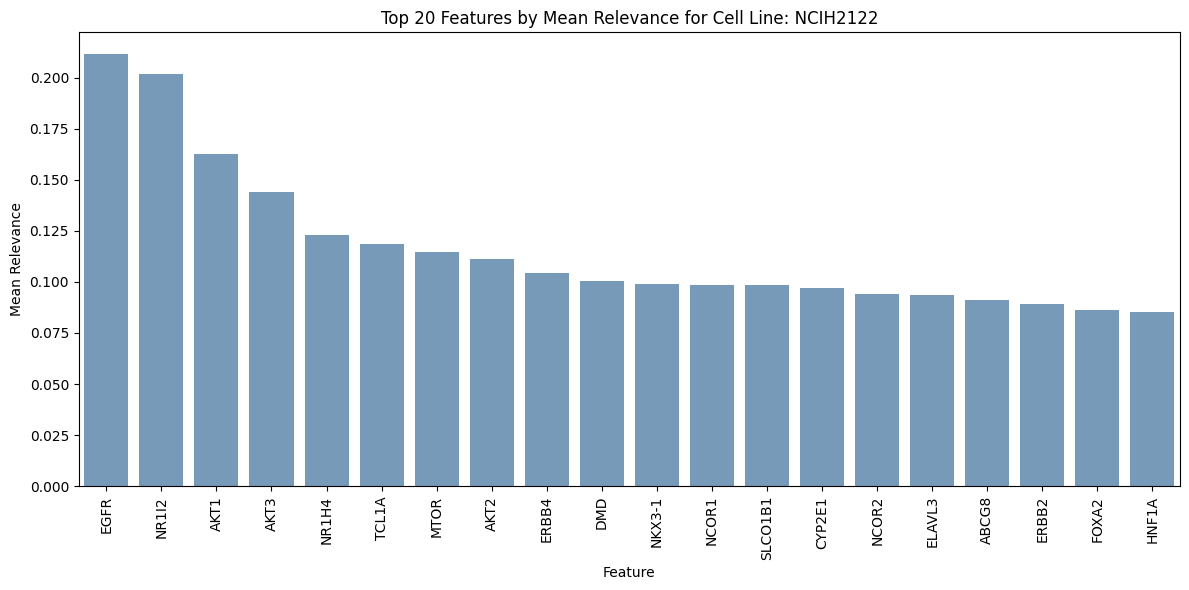

Top 20 Features for Cell Line: NCIH23 (Averaged! across relevances o 2 drug pairs)
MTOR: 0.1256
NR4A2: 0.1084
AKT1: 0.1083
EZR: 0.1081
PRKCZ: 0.1081
HNF1A: 0.1072
MYD88: 0.1053
NR1I2: 0.1015
ZHX2: 0.1013
PIK3R2: 0.1012
TPTE2: 0.1010
ELAVL3: 0.1006
SOS1: 0.0990
ITPR3: 0.0989
PRDM16: 0.0974
DACH1: 0.0959
RELN: 0.0956
LRP1B: 0.0956
LIFR: 0.0951
IRS1: 0.0949


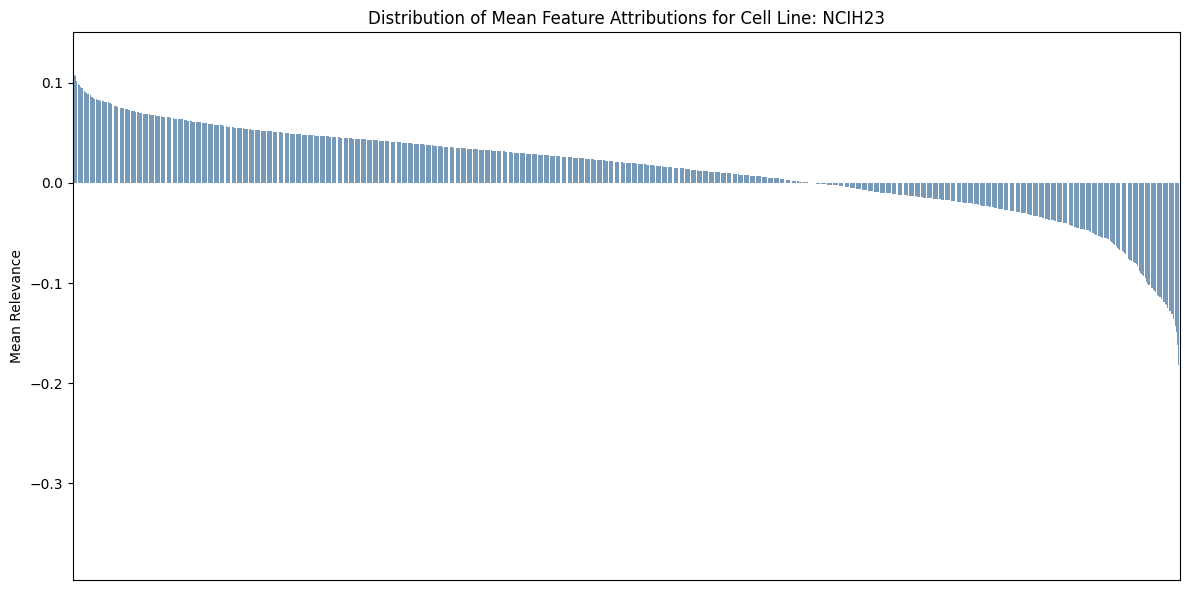

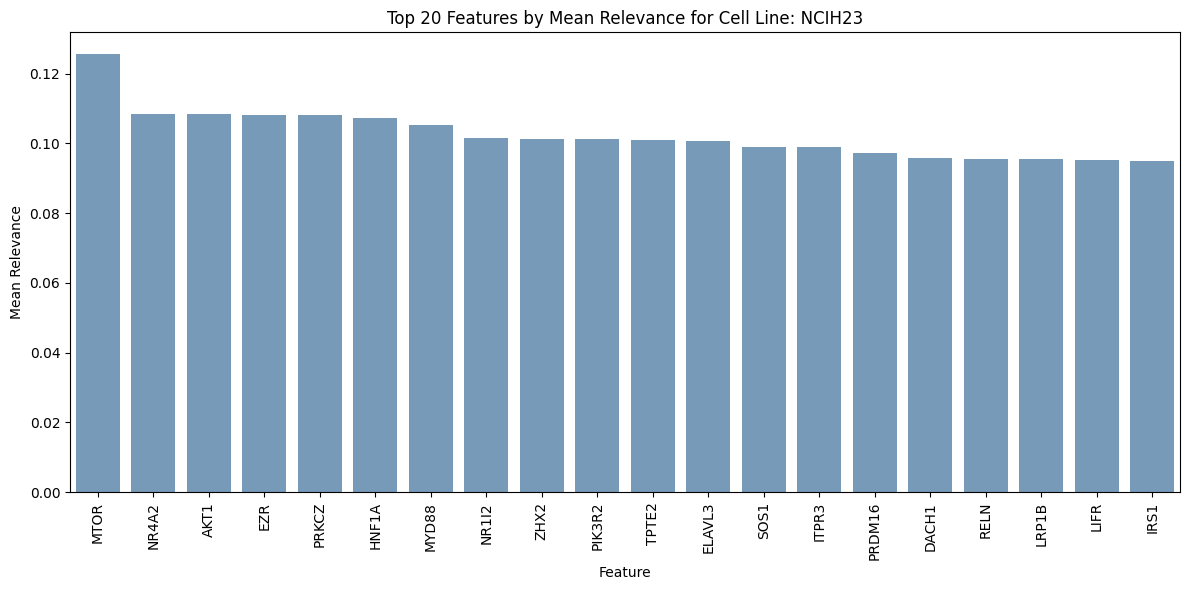

Top 20 Features for Cell Line: NCIH460 (Averaged! across relevances o 2 drug pairs)
MTOR: 0.1403
pIC50: 0.1091
AKT2: 0.0993
AKT3: 0.0920
EGFR: 0.0901
AKT1: 0.0859
WEE1: 0.0795
TOP1: 0.0742
NR1I2: 0.0742
ATG13: 0.0693
PABPC1L: 0.0568
PREX2: 0.0563
FAM47C: 0.0563
ZNF429: 0.0552
TLR2: 0.0527
MYT1: 0.0510
RPTOR: 0.0508
CRTC3: 0.0500
HMGN2P46: 0.0495
SULT1B1: 0.0492


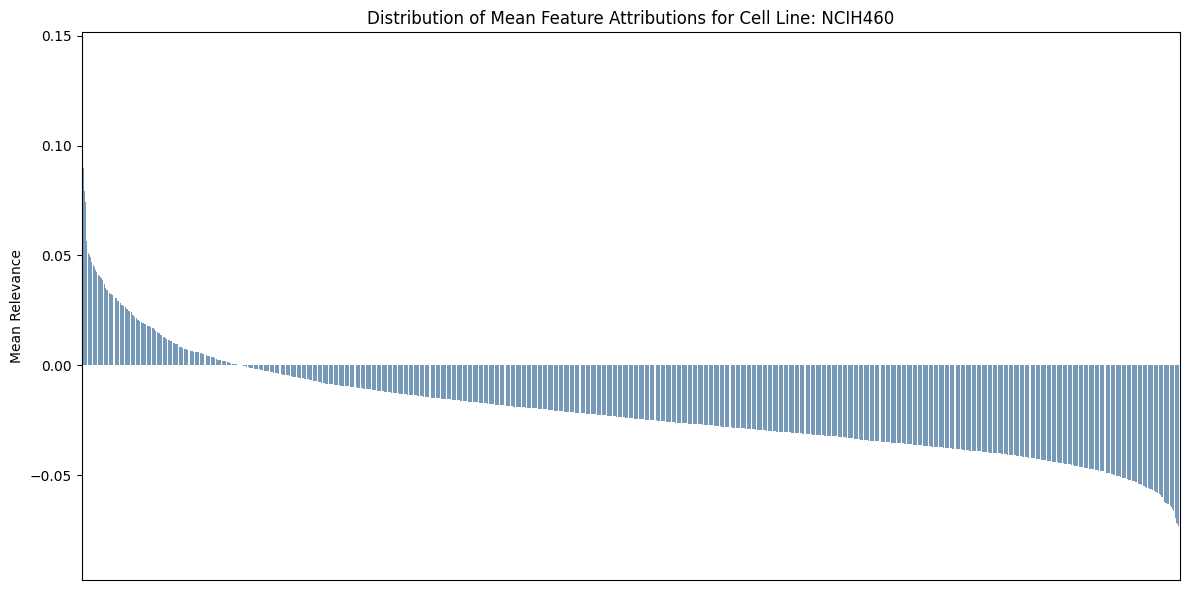

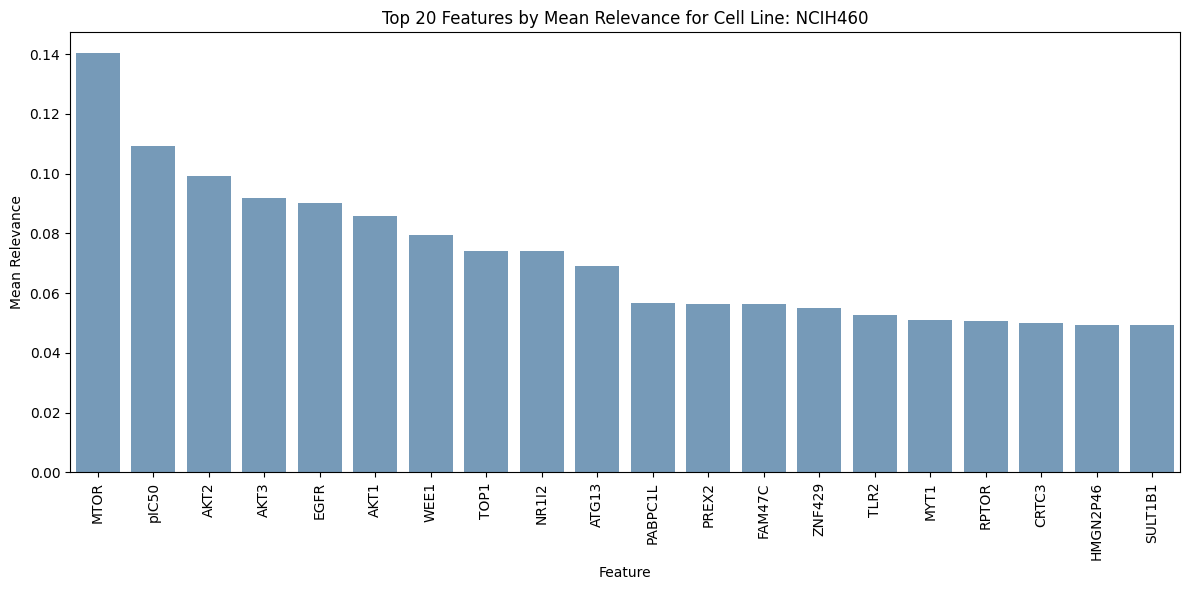

Top 20 Features for Cell Line: NCIH520 (Averaged! across relevances o 2 drug pairs)
MTOR: 0.1287
AKT2: 0.0683
NR1I2: 0.0613
CRTC3: 0.0612
PREX2: 0.0586
AKT1: 0.0566
TPTE2: 0.0563
ATG13: 0.0556
CCKBR: 0.0535
AKT3: 0.0496
SLC7A13: 0.0469
MYT1: 0.0469
SULT1B1: 0.0463
WEE1: 0.0463
TRERF1: 0.0446
TCL1A: 0.0418
PABPC1L: 0.0416
CHEK1: 0.0399
DIS3: 0.0391
TOP1: 0.0386


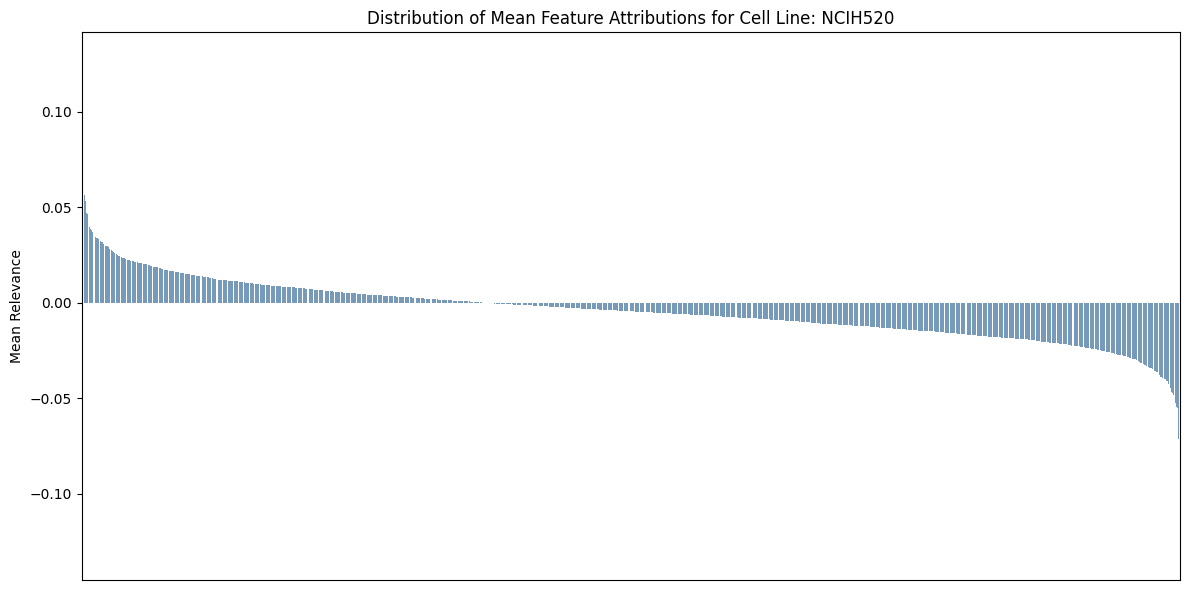

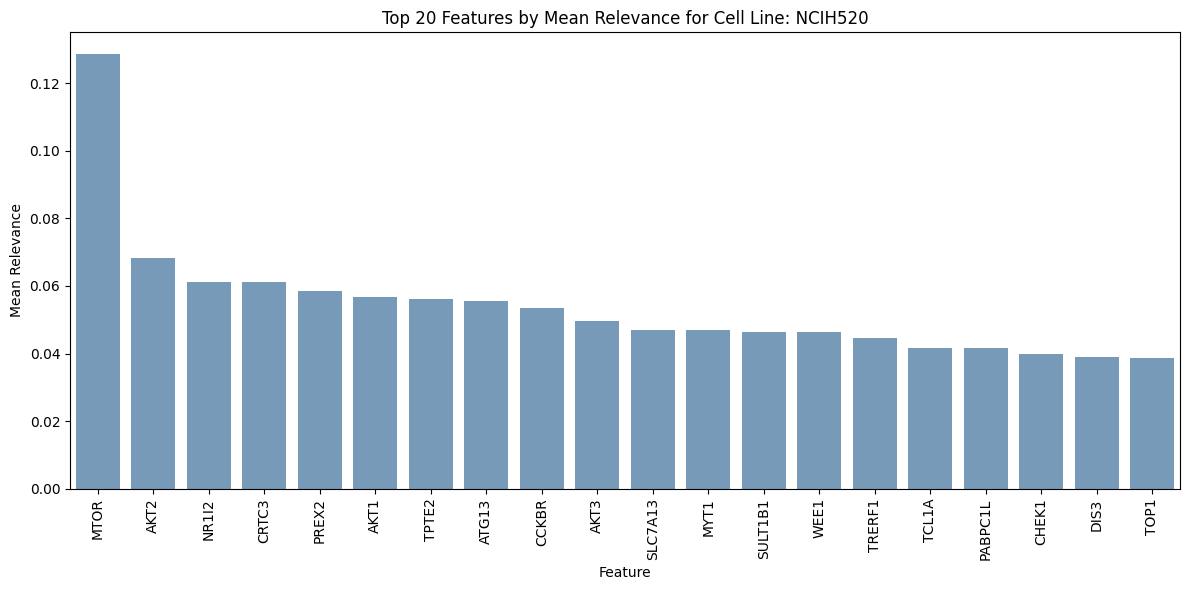

Top 20 Features for Cell Line: OCUBM (Averaged! across relevances o 2 drug pairs)
MTOR: 0.1173
WEE1: 0.1135
pIC50: 0.1014
MYT1: 0.0754
NR1I2: 0.0741
FNTA: 0.0652
PABPC1L: 0.0630
ZNF429: 0.0613
PGGT1B: 0.0586
BRSK1: 0.0524
RHOB: 0.0501
EGFR: 0.0496
USP44: 0.0495
SULT1B1: 0.0478
ATG13: 0.0468
PARP2: 0.0451
AR: 0.0445
ZMIZ1: 0.0442
TRPM2: 0.0439
CHEK1: 0.0423


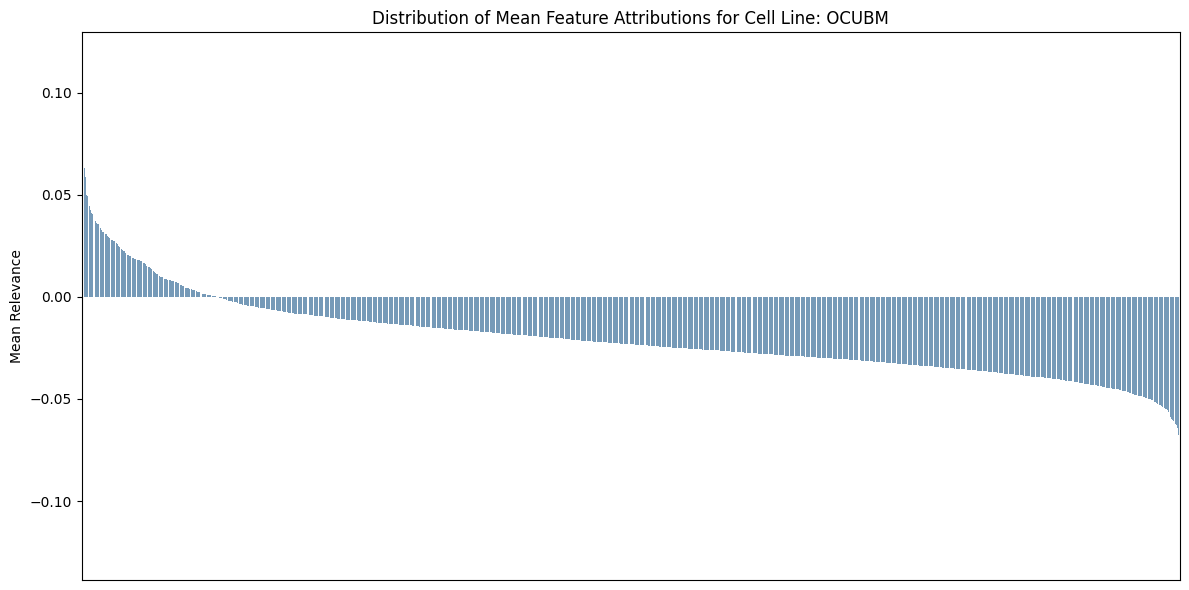

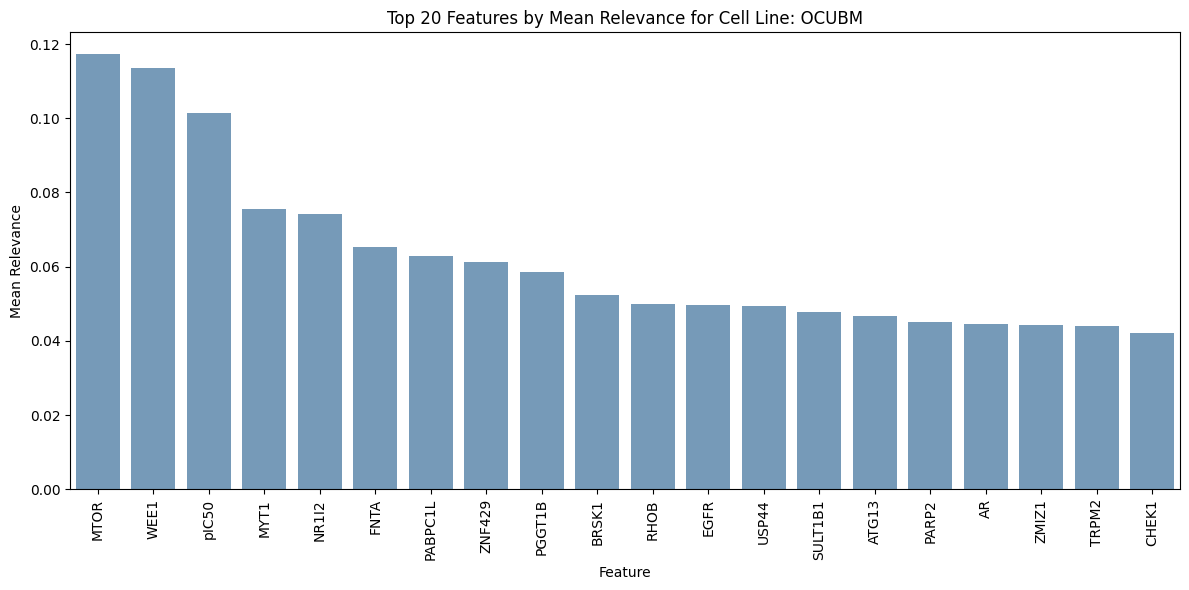

Top 20 Features for Cell Line: OV90 (Averaged! across relevances o 2 drug pairs)
MTOR: 0.1933
TUBB: 0.1236
pIC50: 0.1009
ATG13: 0.0825
SLC7A13: 0.0802
MAGED1: 0.0770
TPM4: 0.0726
PREX2: 0.0686
CRTC3: 0.0635
FNTA: 0.0606
STIM1: 0.0590
ANKRD26: 0.0559
AKT2: 0.0559
MAST3: 0.0551
PLCH2: 0.0545
ZNF429: 0.0533
TUBA3C: 0.0522
PABPC1L: 0.0522
DNAH11: 0.0514
LARP4B: 0.0505


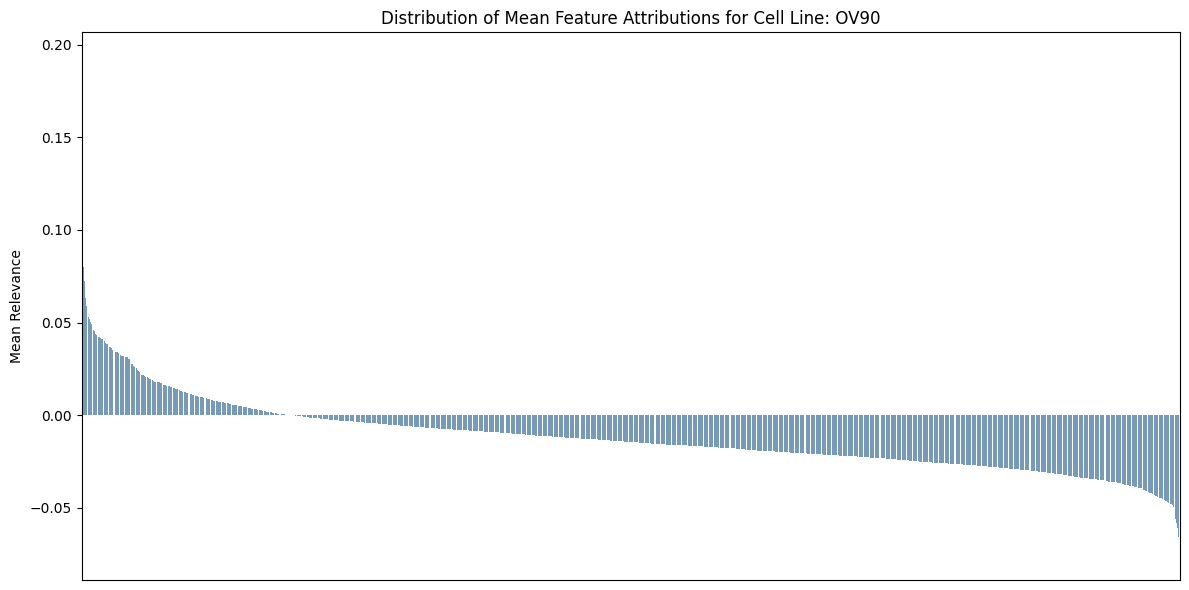

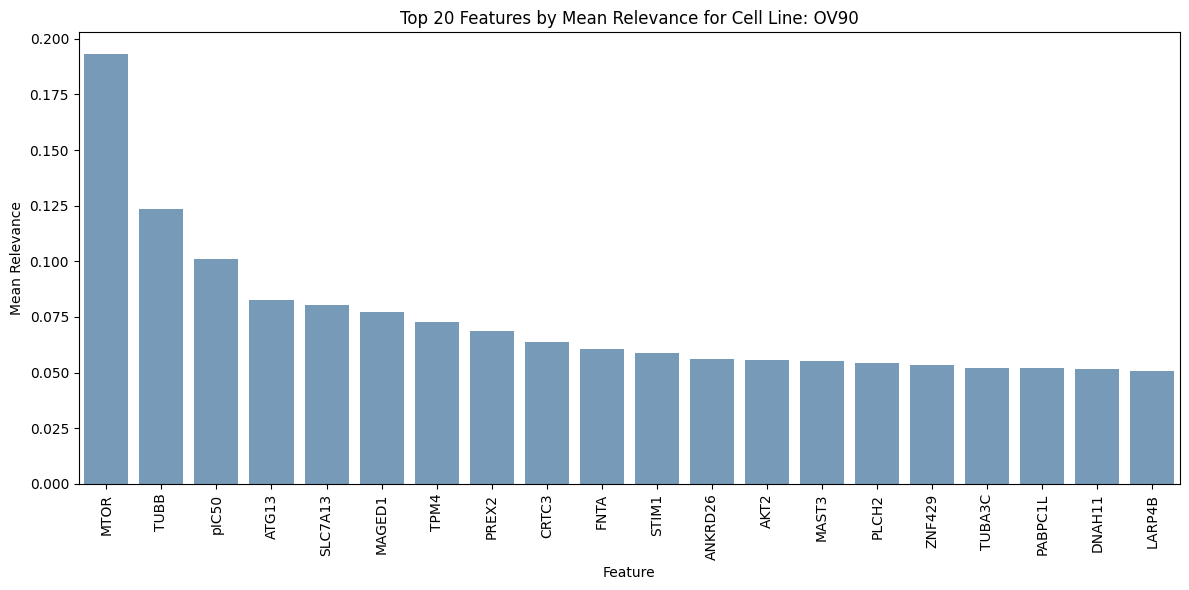

Top 20 Features for Cell Line: OVCAR3 (Averaged! across relevances o 2 drug pairs)
MTOR: 0.2329
TOP1: 0.1142
NR1I2: 0.1055
EGFR: 0.0940
WEE1: 0.0931
SLC7A13: 0.0889
ATG13: 0.0883
NKX3-1: 0.0834
ERBB4: 0.0802
TRPM2: 0.0790
PREX2: 0.0787
PABPC1L: 0.0785
SULT1B1: 0.0760
ANKRD26: 0.0750
MYT1: 0.0745
CRTC3: 0.0731
CDK2: 0.0730
AKT2: 0.0716
TACR1: 0.0700
CHEK1: 0.0670


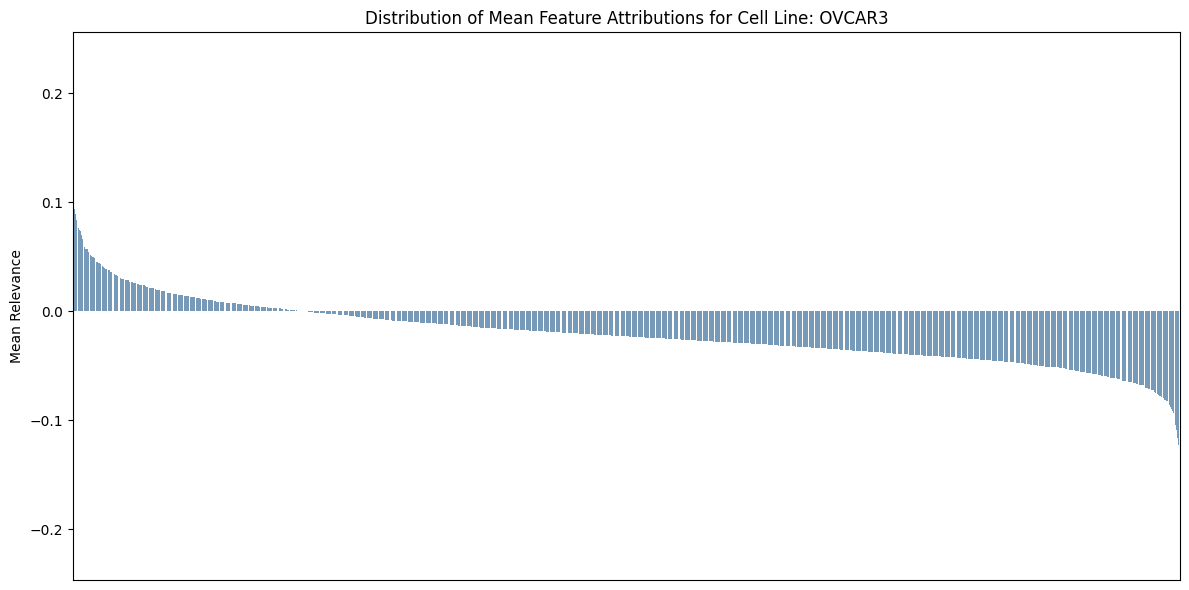

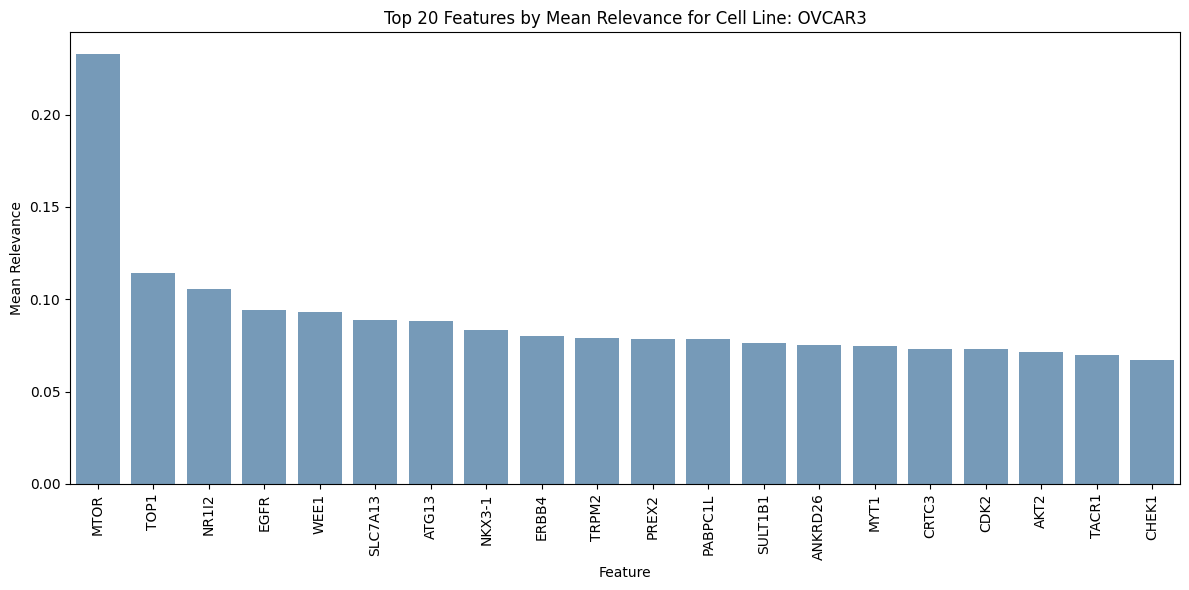

Top 20 Features for Cell Line: PA1 (Averaged! across relevances o 2 drug pairs)
MTOR: 0.1723
WEE1: 0.1518
AKT2: 0.1233
AKT3: 0.1111
AKT1: 0.1100
PABPC1L: 0.1052
MYT1: 0.0961
NR1I2: 0.0959
ATG13: 0.0810
SULT1B1: 0.0802
BRSK1: 0.0783
ZNF429: 0.0745
NKX3-1: 0.0691
RHOB: 0.0680
PTPRB: 0.0675
PREX2: 0.0663
CRTC3: 0.0655
USP44: 0.0650
SLCO1B1: 0.0640
SLC7A13: 0.0615


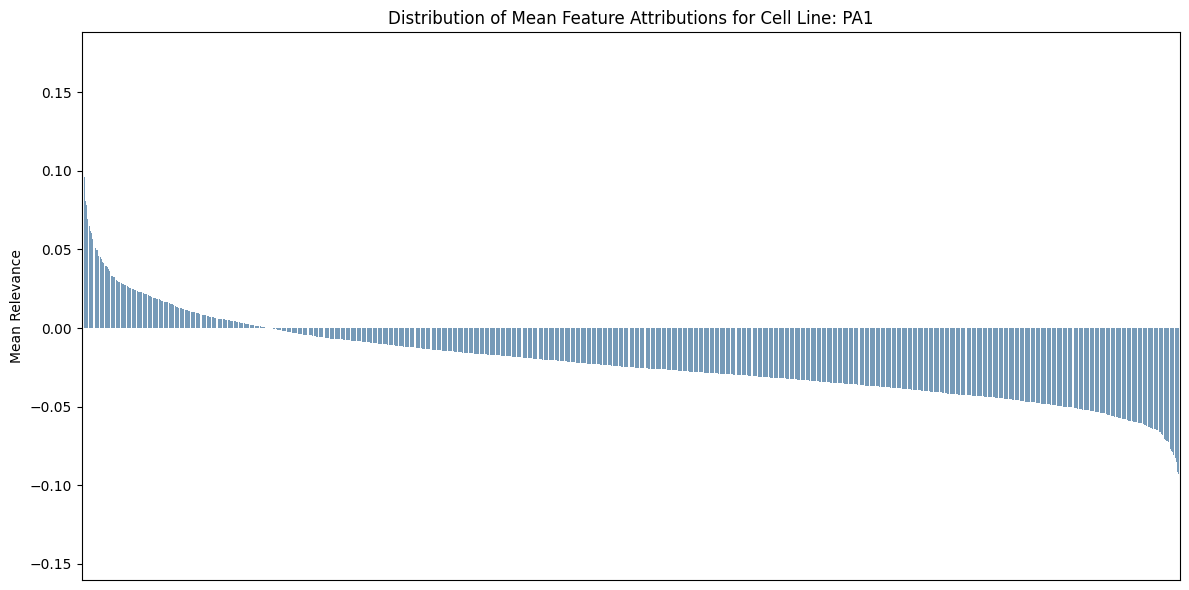

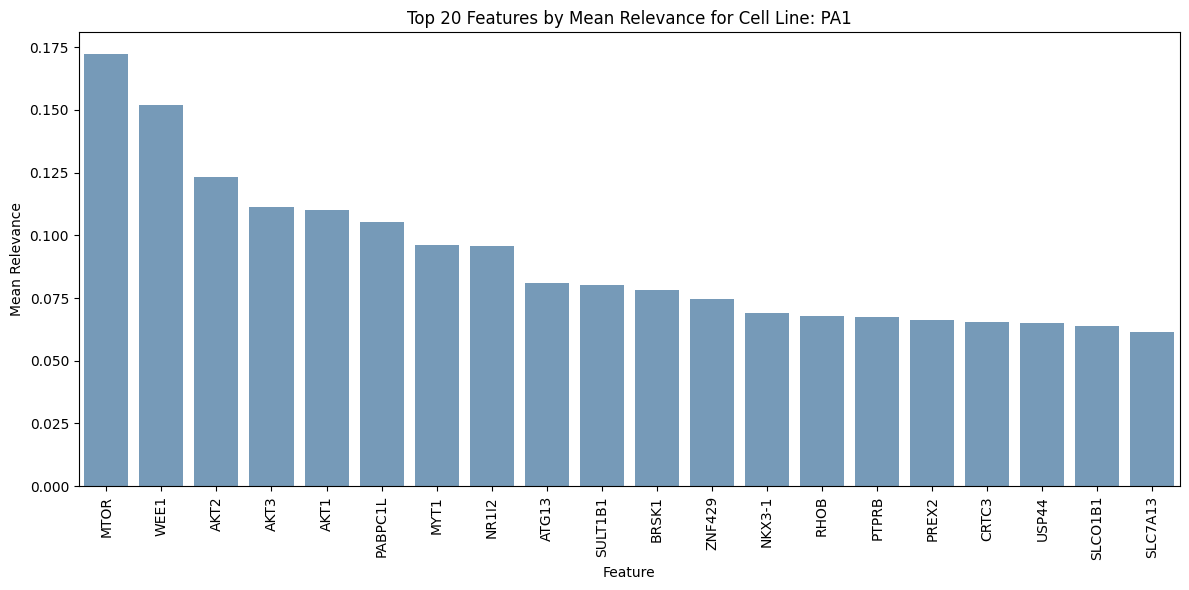

Top 20 Features for Cell Line: RKO (Averaged! across relevances o 2 drug pairs)
MTOR: 0.2480
pIC50: 0.1658
WEE1: 0.1293
AKT3: 0.1146
AKT2: 0.1115
ATG13: 0.1051
SLC7A13: 0.0980
PABPC1L: 0.0951
ZNF429: 0.0933
PREX2: 0.0886
TLR2: 0.0829
AKT1: 0.0823
CRTC3: 0.0823
CLEC19A: 0.0780
MYT1: 0.0776
MAST3: 0.0774
ZNF99: 0.0728
HMGN2P46: 0.0723
SRD5A2: 0.0703
TRPM2: 0.0696


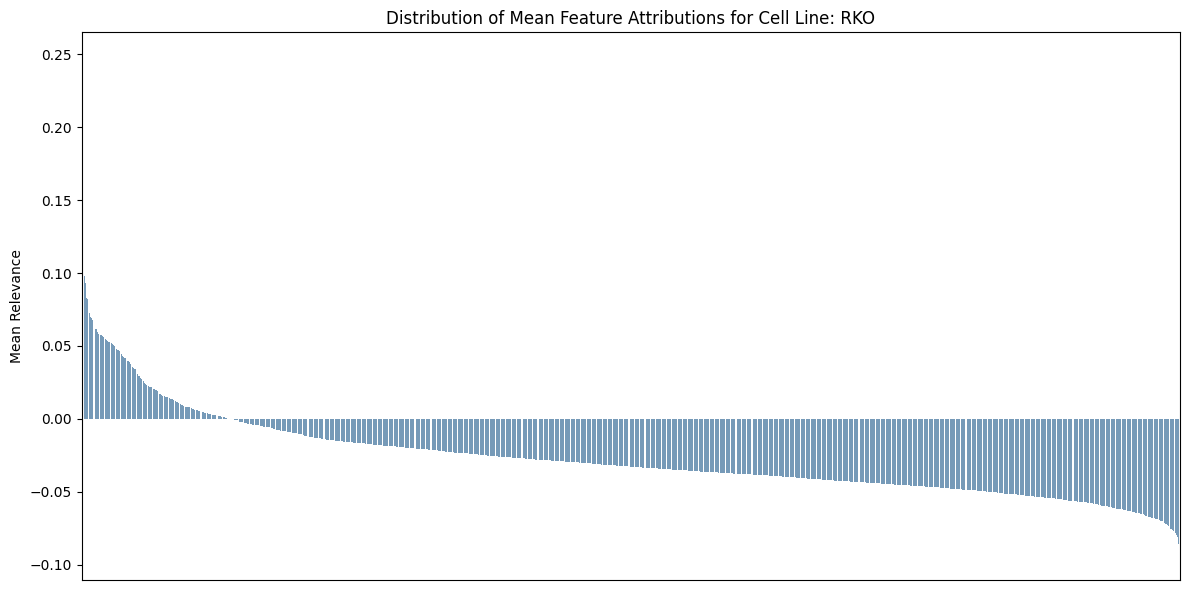

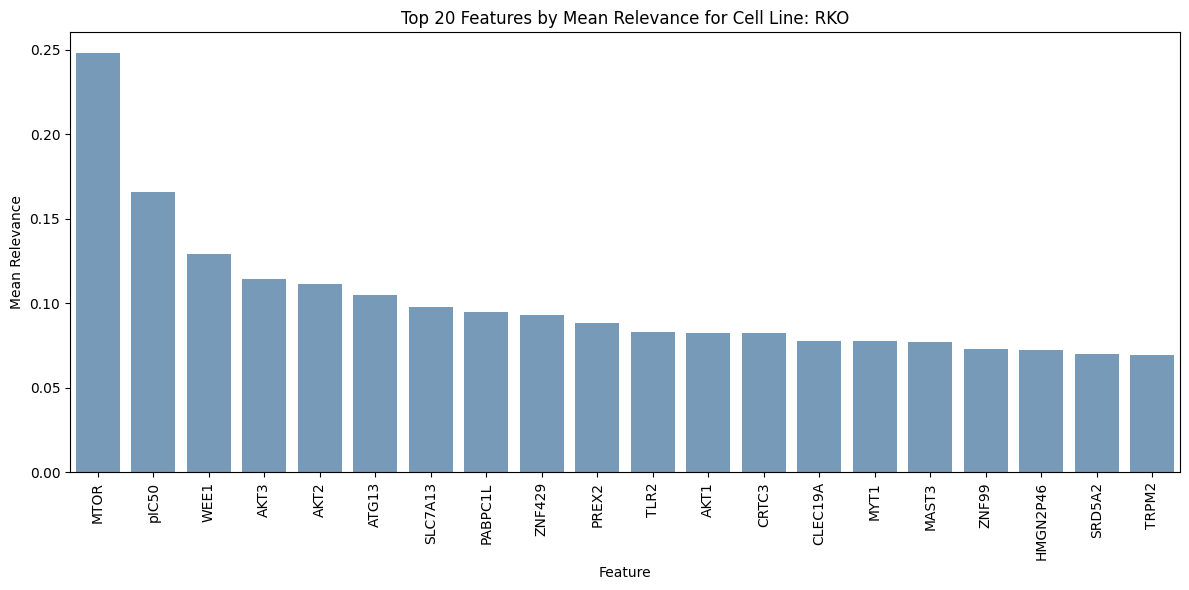

Top 20 Features for Cell Line: RPMI7951 (Averaged! across relevances o 2 drug pairs)
MTOR: 0.1990
ATG13: 0.0958
PREX2: 0.0918
CRTC3: 0.0852
ANKRD26: 0.0791
SLC7A13: 0.0774
TPTE2: 0.0754
STIM1: 0.0726
AKT2: 0.0701
PLCH2: 0.0695
MAST3: 0.0672
AKT1: 0.0650
AKT3: 0.0614
TRERF1: 0.0611
EGFR: 0.0587
GPHN: 0.0582
PIK3R4: 0.0571
PKHD1: 0.0569
IRS1: 0.0569
PLCB4: 0.0562


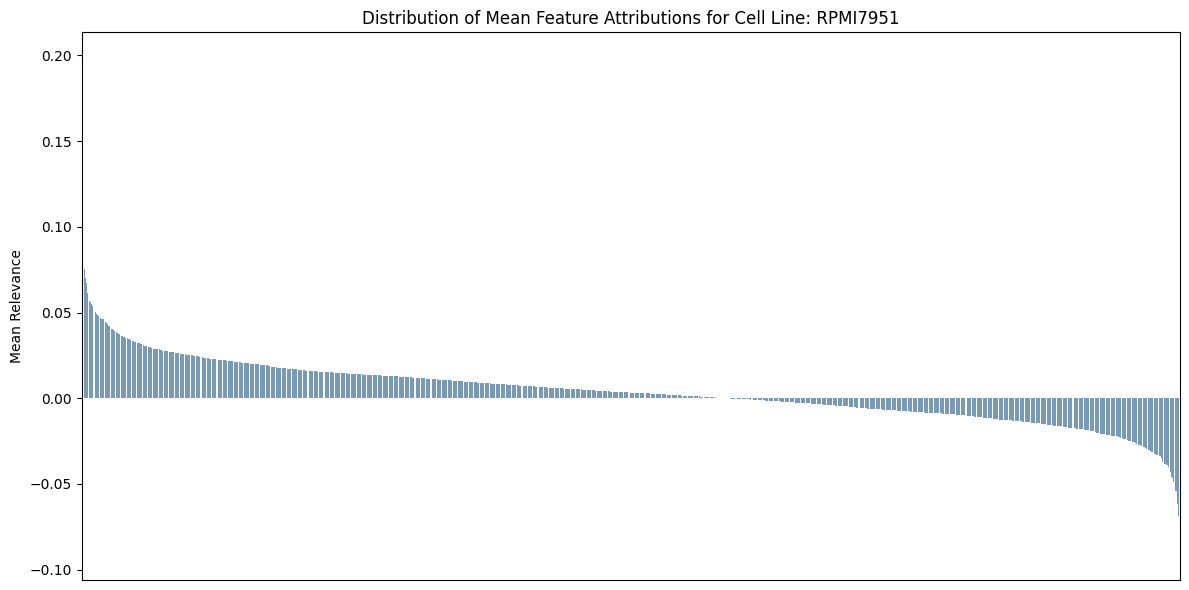

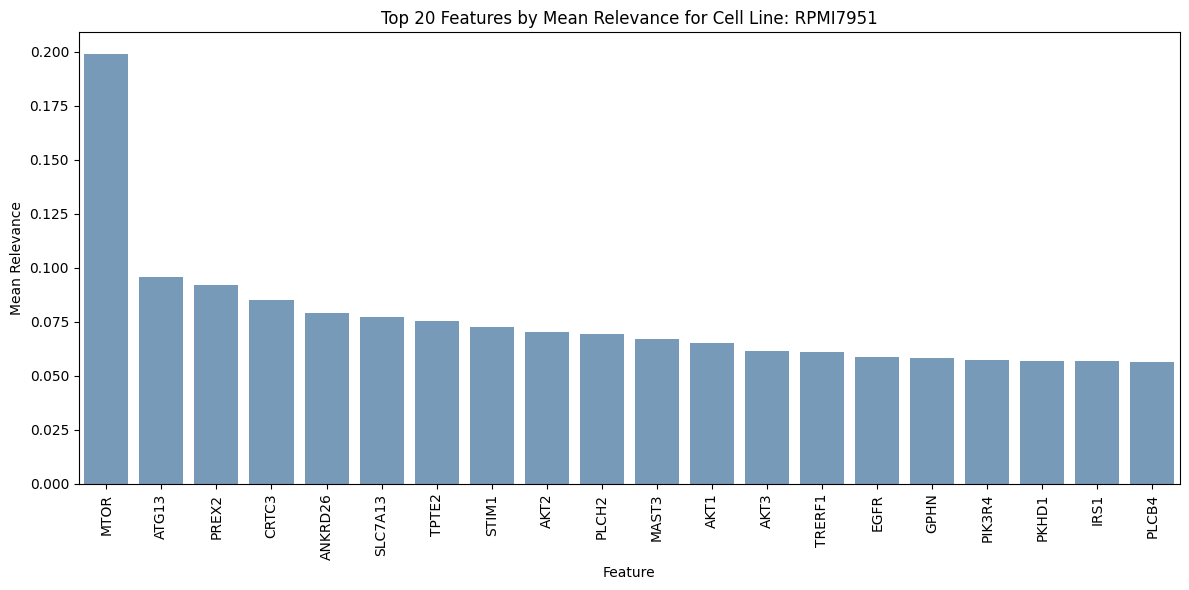

Top 20 Features for Cell Line: SKMEL30 (Averaged! across relevances o 2 drug pairs)
MTOR: 0.2033
pIC50: 0.1612
SLC7A13: 0.0796
ATG13: 0.0794
WEE1: 0.0789
CHEK1: 0.0762
MYT1: 0.0679
CRTC3: 0.0676
PREX2: 0.0675
ANKRD26: 0.0672
HMGN2P46: 0.0646
TLR2: 0.0644
PIK3R6: 0.0632
CDK2: 0.0611
ZNF99: 0.0611
ZNF429: 0.0608
TUBA3C: 0.0605
STK11IP: 0.0602
ZNF765: 0.0601
TRPM2: 0.0600


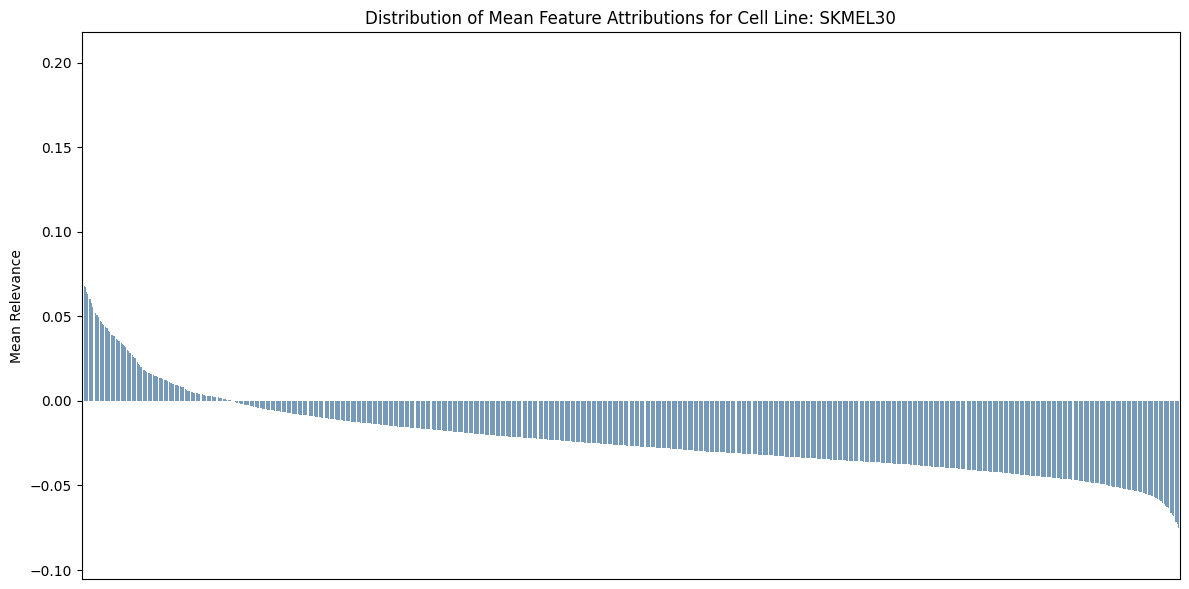

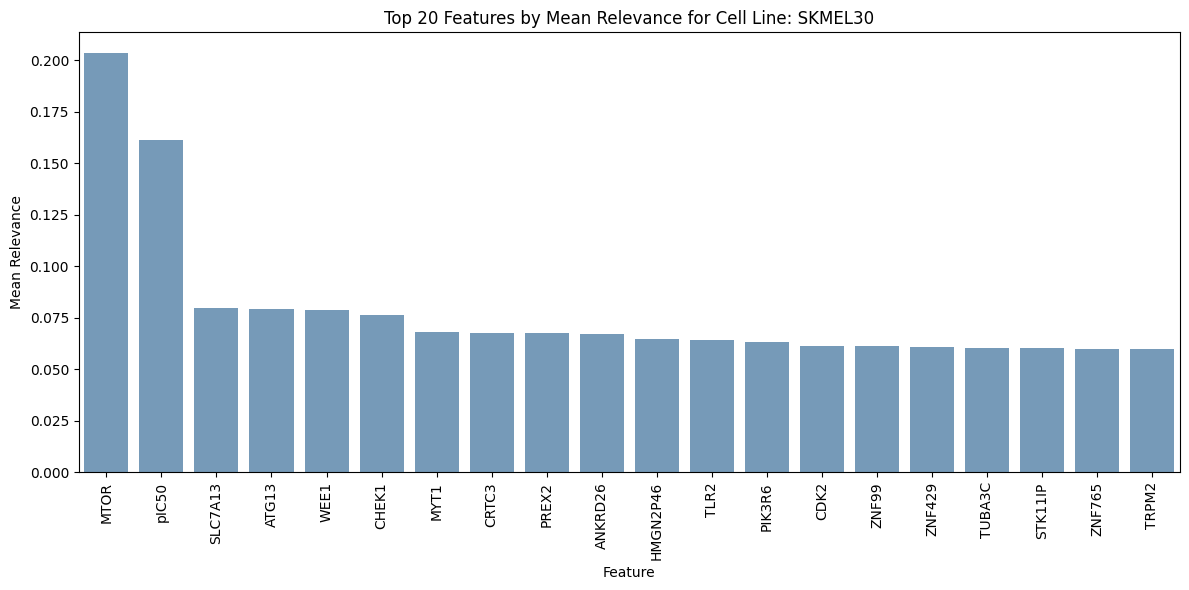

Top 20 Features for Cell Line: SKMES1 (Averaged! across relevances o 2 drug pairs)
MTOR: 0.2371
NR1I2: 0.2093
EGFR: 0.1778
SULT1B1: 0.1360
AKT2: 0.1297
AKT3: 0.1268
AKT1: 0.1198
ATG13: 0.1198
PREX2: 0.1116
SLCO1B1: 0.1069
SLC7A13: 0.1034
ABCG8: 0.0854
CRTC3: 0.0852
TPTE2: 0.0849
TCL1A: 0.0789
ERBB4: 0.0783
NR1H4: 0.0741
WEE1: 0.0738
TRPM2: 0.0721
MAST3: 0.0701


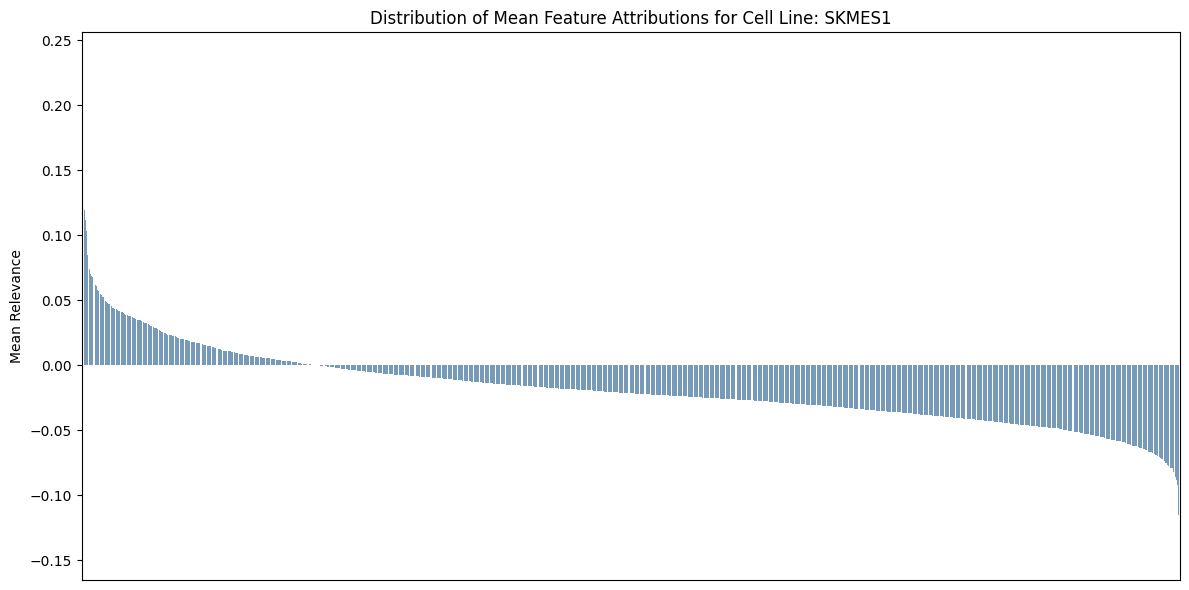

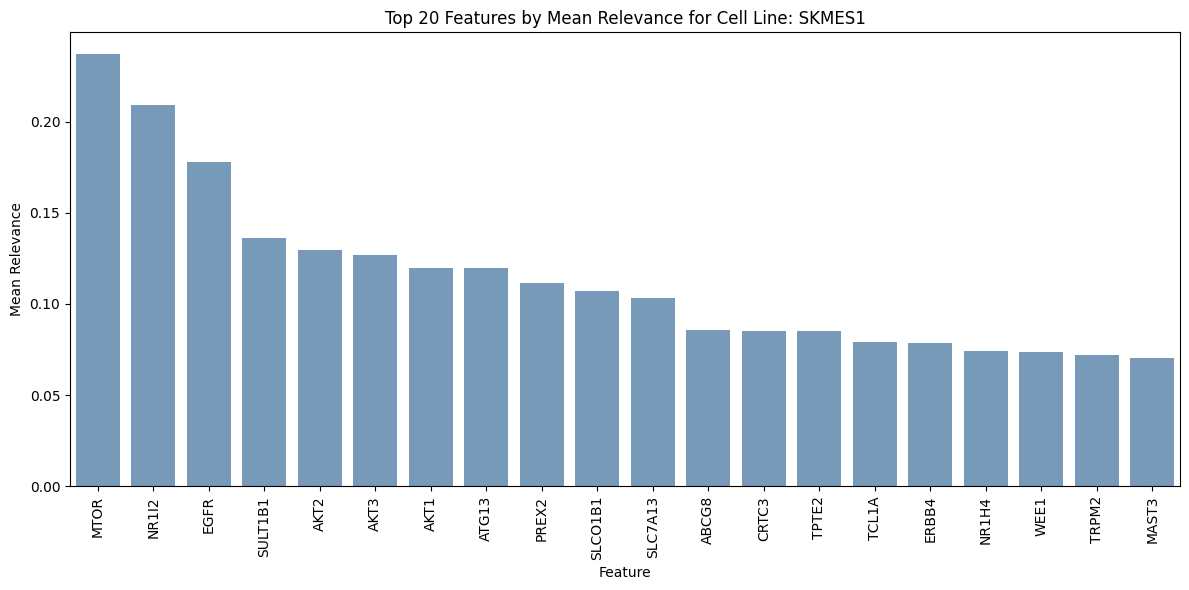

Top 20 Features for Cell Line: SKOV3 (Averaged! across relevances o 2 drug pairs)
MTOR: 0.3404
WEE1: 0.2264
ZNF429: 0.1665
PABPC1L: 0.1646
pIC50: 0.1523
SLC7A13: 0.1474
ATG13: 0.1455
MYT1: 0.1358
NR1I2: 0.1228
PREX2: 0.1158
EGFR: 0.1138
USP44: 0.1136
CRTC3: 0.1131
TRPM2: 0.1115
SULT1B1: 0.1090
SRD5A2: 0.1065
TLR2: 0.1041
ZNF99: 0.1025
TUBA3C: 0.1025
BRSK1: 0.1019


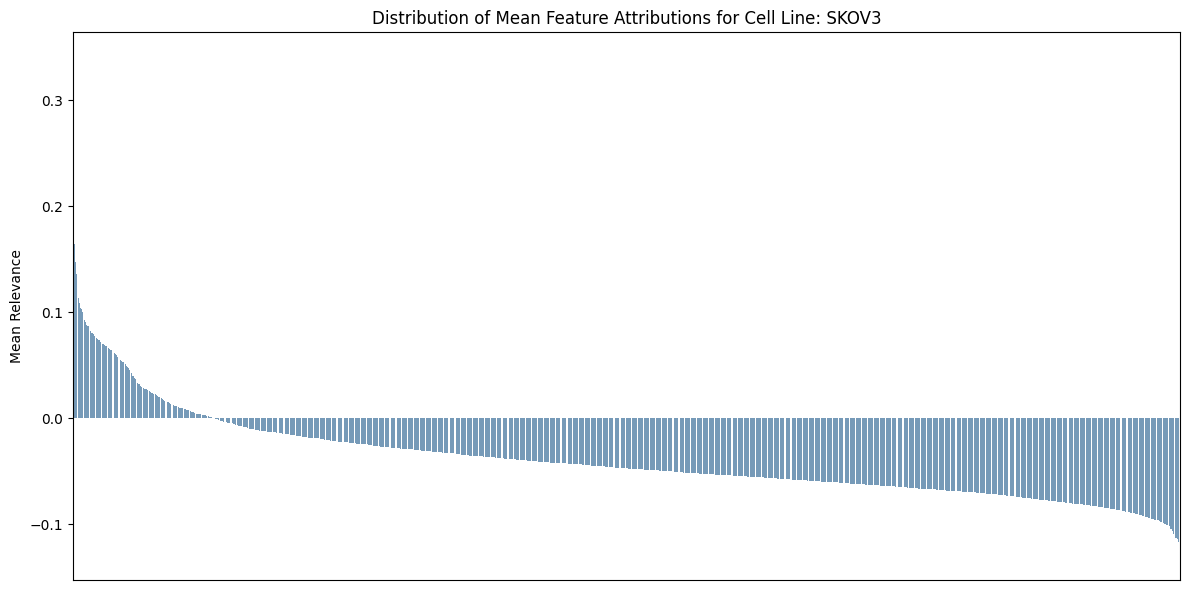

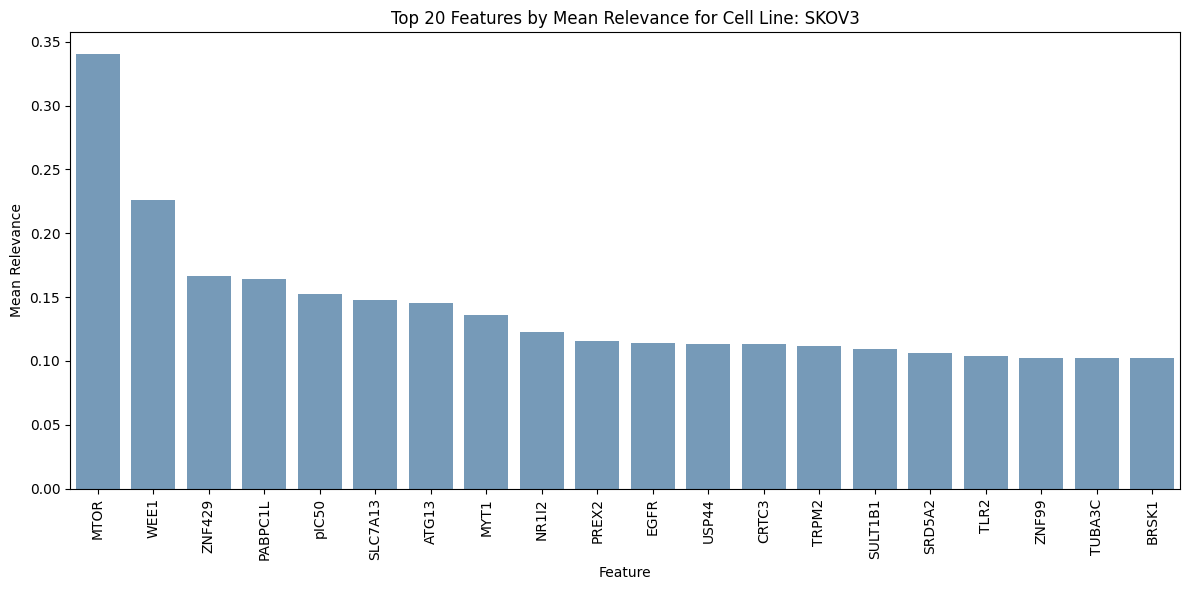

Top 20 Features for Cell Line: SW620 (Averaged! across relevances o 2 drug pairs)
MTOR: 0.0890
pIC50: 0.0544
WEE1: 0.0398
AKT2: 0.0396
TOP1: 0.0391
AKT3: 0.0381
ATG13: 0.0379
SLC7A13: 0.0366
PABPC1L: 0.0358
PREX2: 0.0327
ZNF429: 0.0310
AKT1: 0.0289
TOP1MT: 0.0284
NALCN: 0.0279
CRTC3: 0.0277
ZMIZ1: 0.0273
DAZAP1: 0.0268
DCHS1: 0.0265
FNTA: 0.0264
NKX3-1: 0.0259


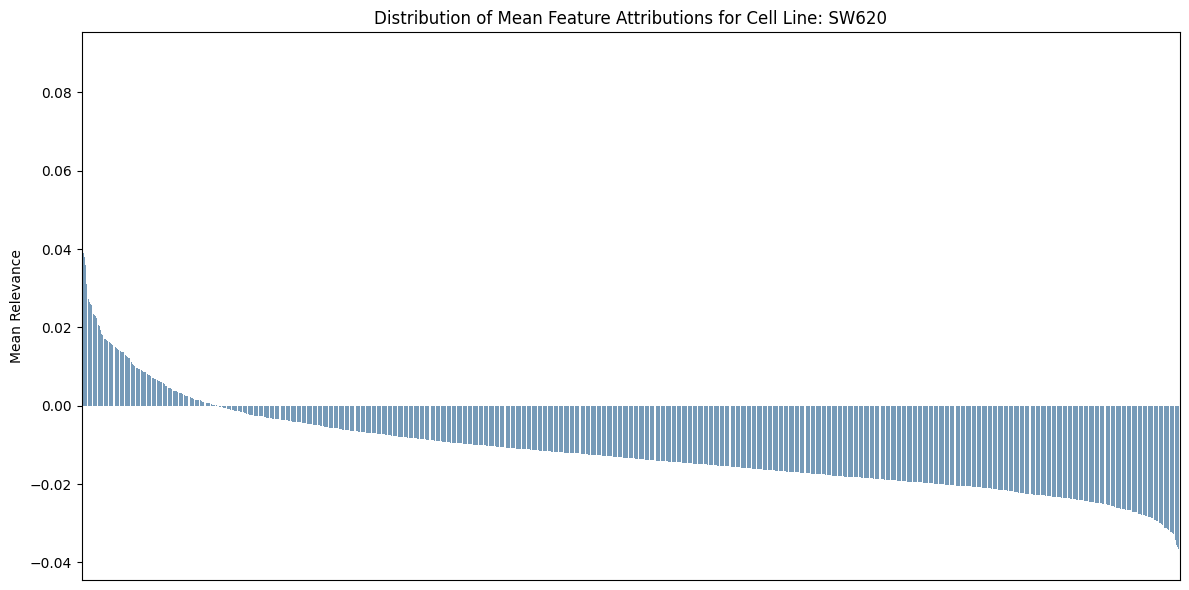

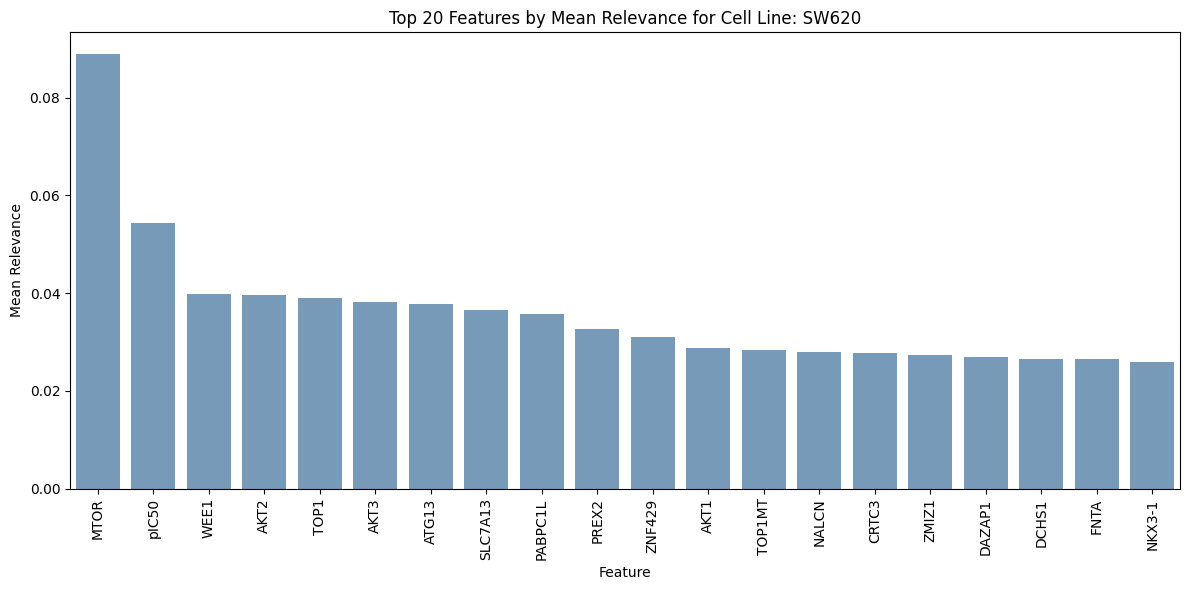

Top 20 Features for Cell Line: SW837 (Averaged! across relevances o 2 drug pairs)
EGFR: 0.3040
MTOR: 0.2918
NR1I2: 0.2016
ATG13: 0.1540
SLC7A13: 0.1522
TACR1: 0.1485
ERBB4: 0.1411
PREX2: 0.1374
AKT1: 0.1338
ERBB2: 0.1243
AKT3: 0.1238
SLCO1B1: 0.1175
HTR3C: 0.1167
CRTC3: 0.1140
TPTE2: 0.1138
SULT1B1: 0.1130
STIM1: 0.1112
NR1H4: 0.1026
LRIG2: 0.1017
NALCN: 0.1010


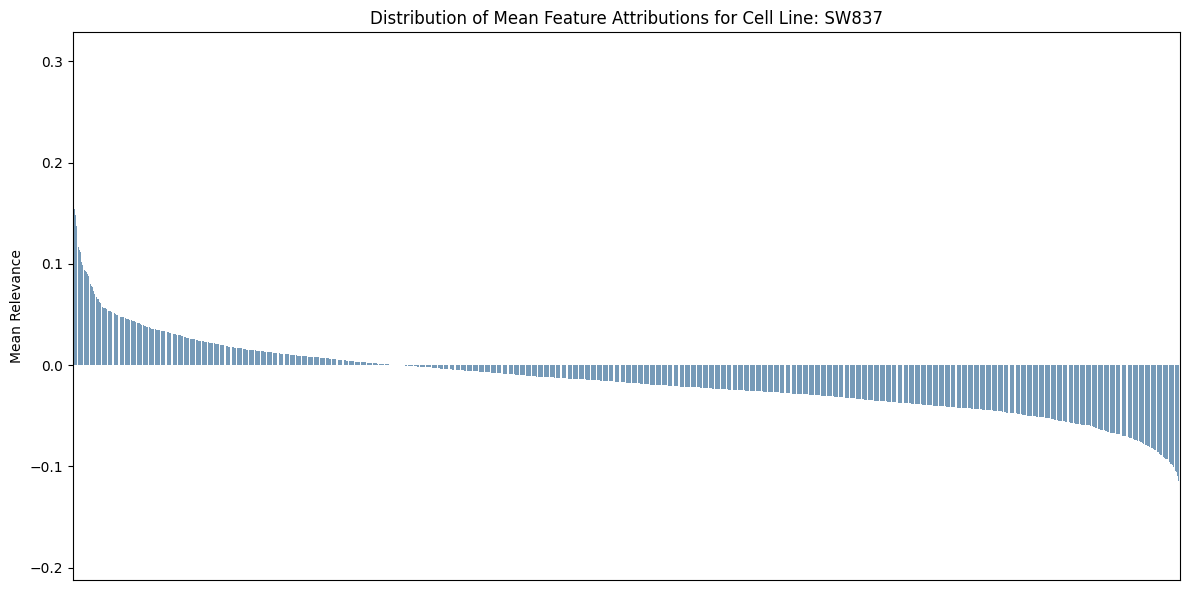

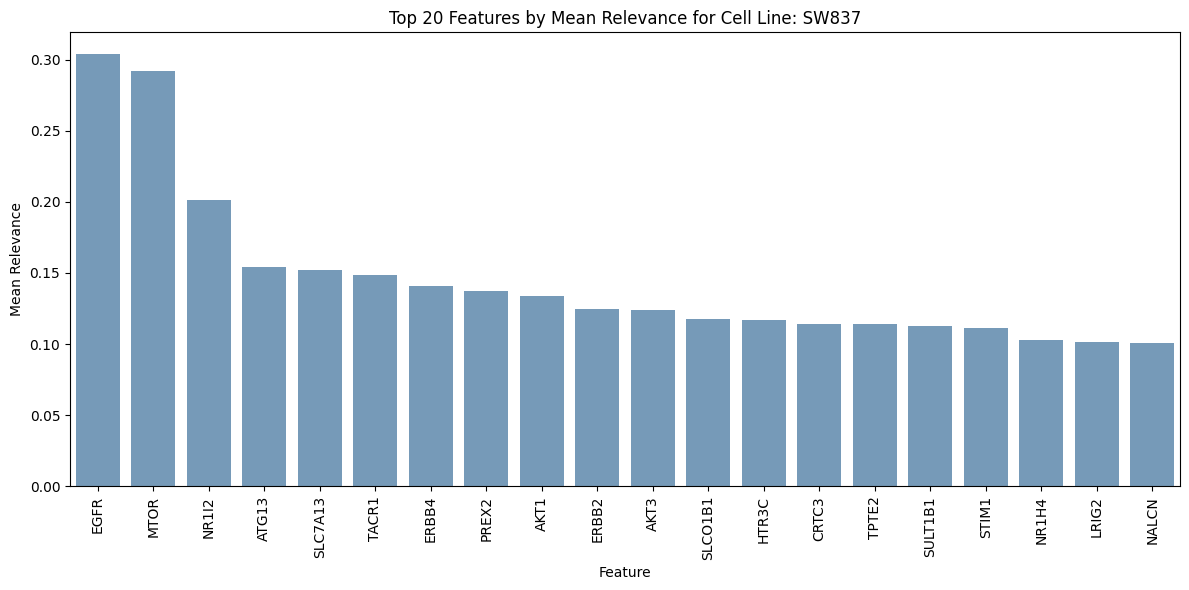

Top 20 Features for Cell Line: T47D (Averaged! across relevances o 2 drug pairs)
MTOR: 0.3587
PIK3CA: 0.1856
PIK3CD: 0.1575
PIK3CG: 0.1471
PIK3CB: 0.1420
ATR: 0.1357
PREX2: 0.1257
ATG13: 0.1204
ANKRD26: 0.1161
SLC7A13: 0.1117
CRTC3: 0.1054
NOLC1: 0.1031
CHRM1: 0.1021
PLCB4: 0.0986
NMBR: 0.0982
MAST3: 0.0897
HTR3C: 0.0881
CYSLTR2: 0.0878
LPAR4: 0.0872
CCKBR: 0.0825


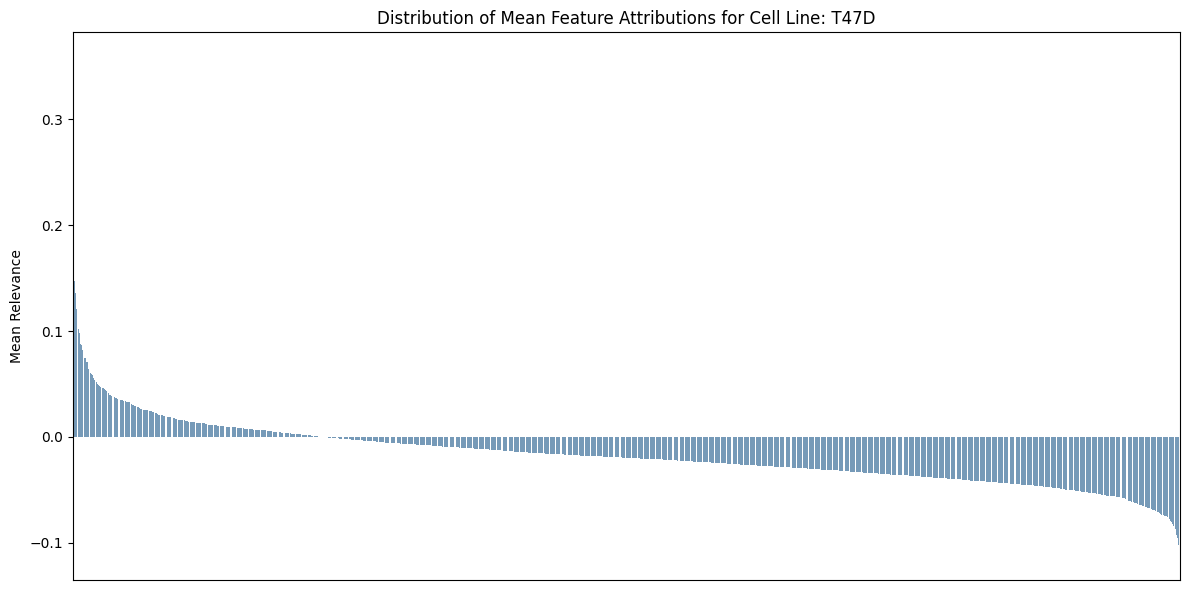

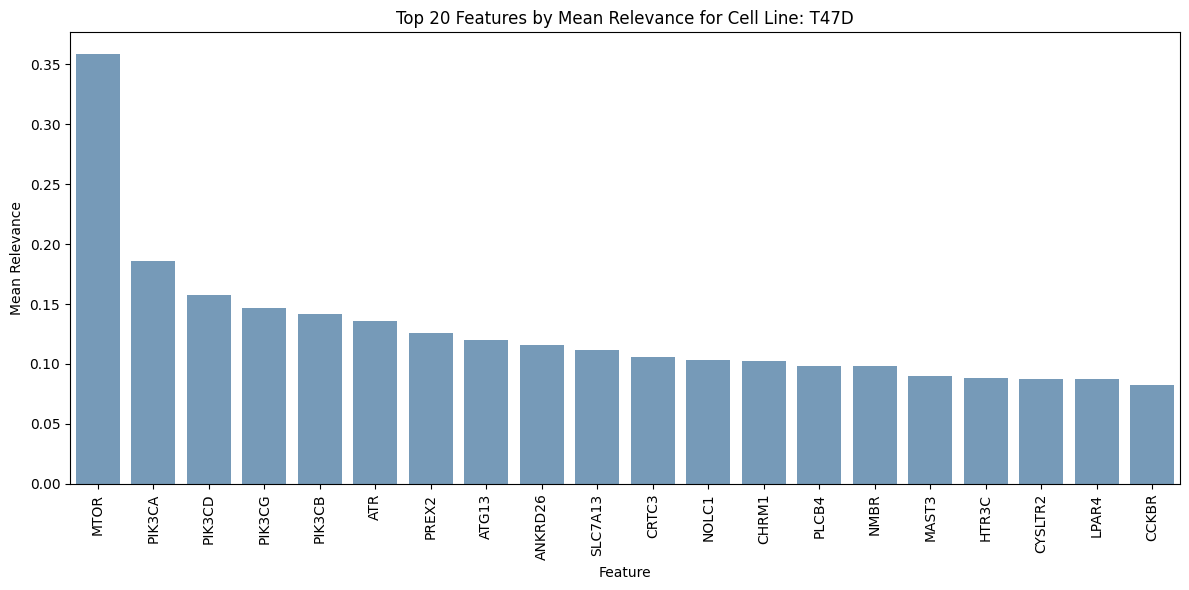

Top 20 Features for Cell Line: UACC62 (Averaged! across relevances o 2 drug pairs)
WEE1: 0.2392
MTOR: 0.2374
PABPC1L: 0.1581
ZNF429: 0.1440
MYT1: 0.1399
EGFR: 0.1156
USP44: 0.1118
BRSK1: 0.1101
NR1I2: 0.1057
ATG13: 0.1055
SLC7A13: 0.0970
ZMIZ1: 0.0956
PREX2: 0.0929
AKT2: 0.0911
pIC50: 0.0882
AKT1: 0.0875
AKT3: 0.0841
CRTC3: 0.0809
NALCN: 0.0790
OTUD7A: 0.0785


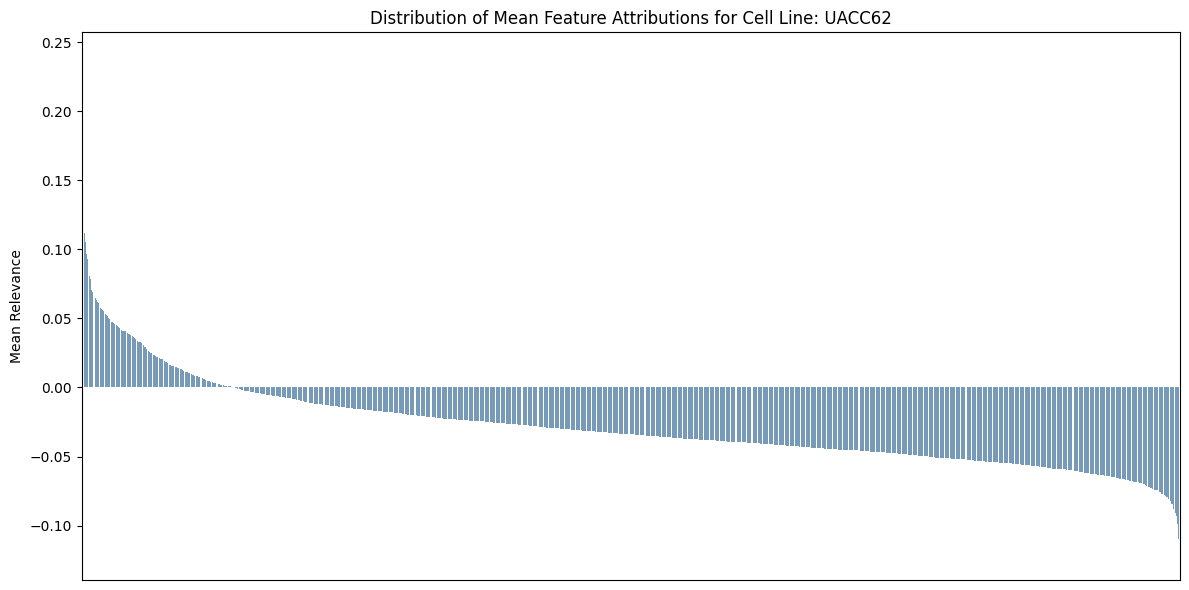

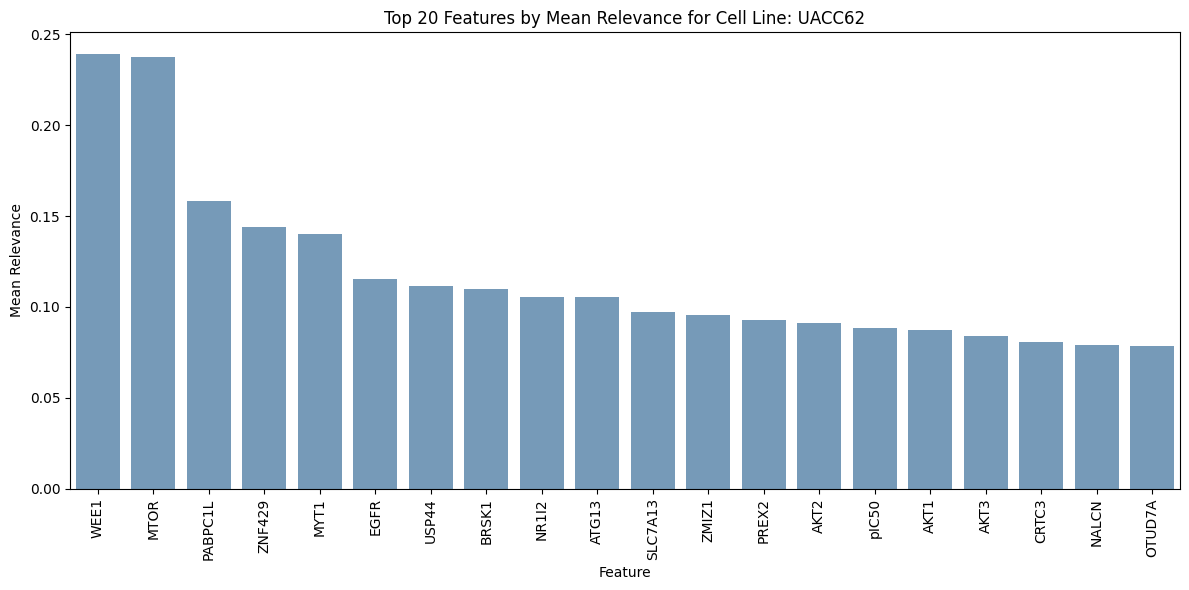

Top 20 Features for Cell Line: UWB1289 (Averaged! across relevances o 2 drug pairs)
WEE1: 0.6646
ZNF429: 0.3791
PABPC1L: 0.3715
USP44: 0.3456
BRSK1: 0.3397
MYT1: 0.3378
OTUD7A: 0.2486
H1-8: 0.2337
BRD8: 0.2305
ZMIZ1: 0.2246
MTOR: 0.2200
KLF2: 0.2084
PTPRO: 0.1995
MNAT1: 0.1886
CAMKK2: 0.1840
PTPRB: 0.1821
PAK5: 0.1693
CCNE1: 0.1566
TPM4: 0.1537
CDC25C: 0.1465


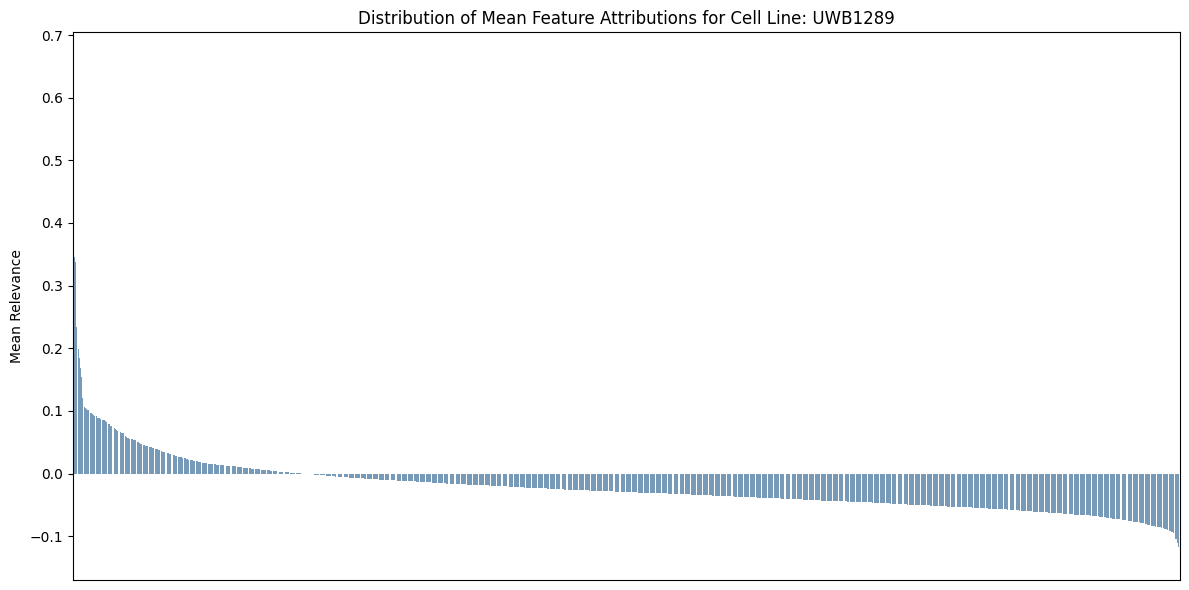

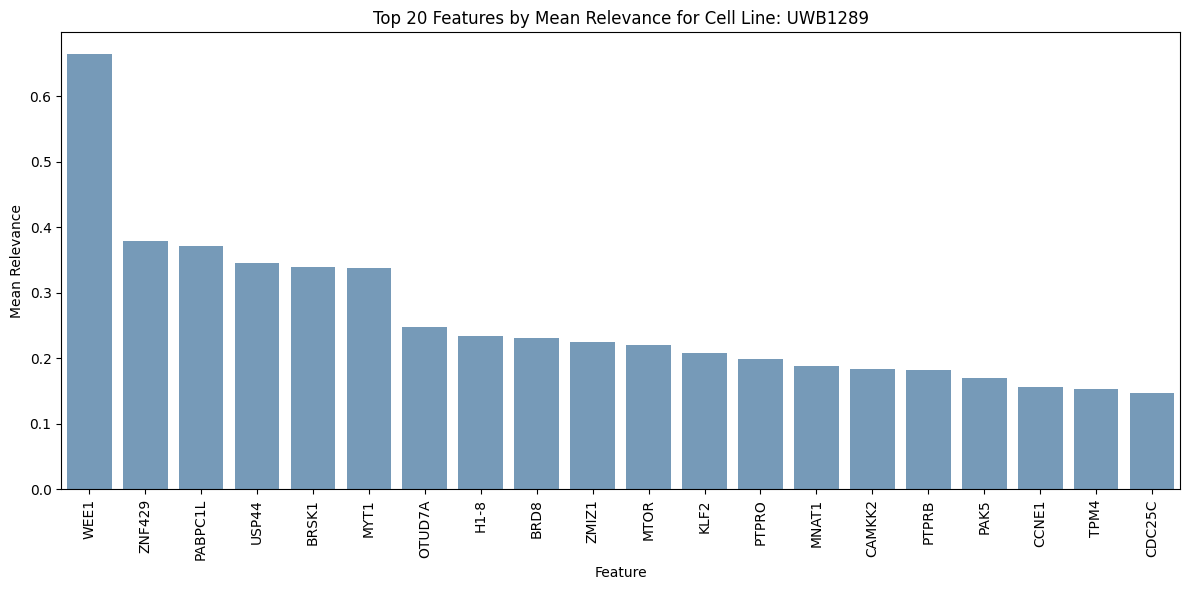

Top 20 Features for Cell Line: VCAP (Averaged! across relevances o 2 drug pairs)
MTOR: 0.1440
NR1I2: 0.1075
AR: 0.1061
TOP1: 0.0925
EGFR: 0.0905
NKX3-1: 0.0833
ZMIZ1: 0.0715
SLC7A13: 0.0669
SULT1B1: 0.0639
APOL2: 0.0638
ATG13: 0.0634
PATZ1: 0.0621
PNRC1: 0.0601
SRD5A1: 0.0590
PABPC1L: 0.0574
VEZF1: 0.0561
CRTC3: 0.0525
PREX2: 0.0508
DCHS1: 0.0504
AKT3: 0.0499


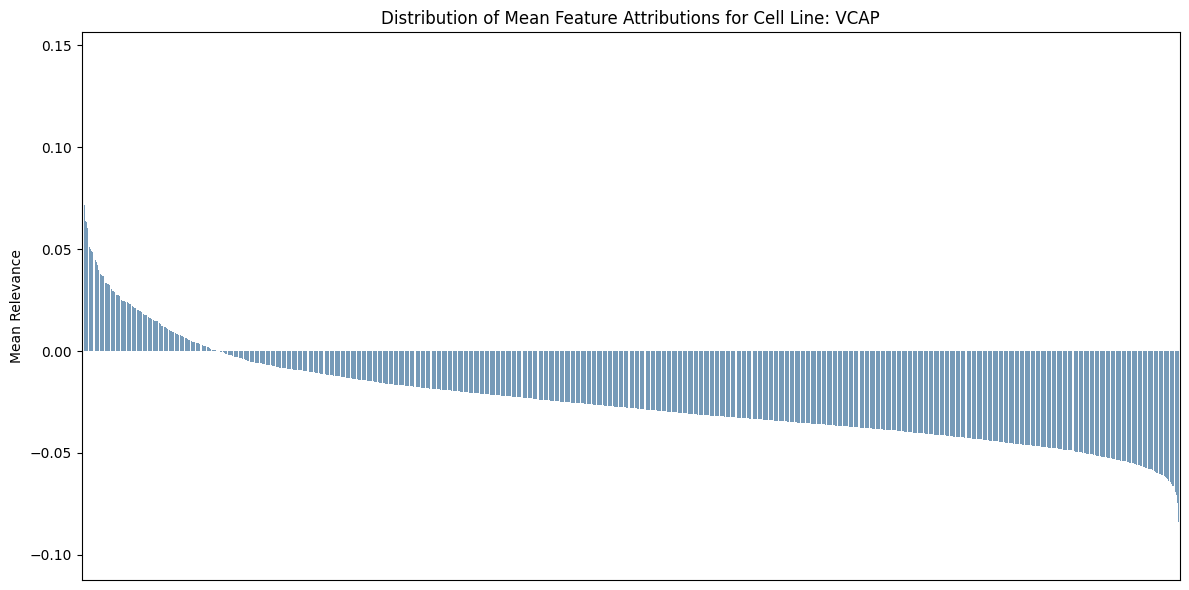

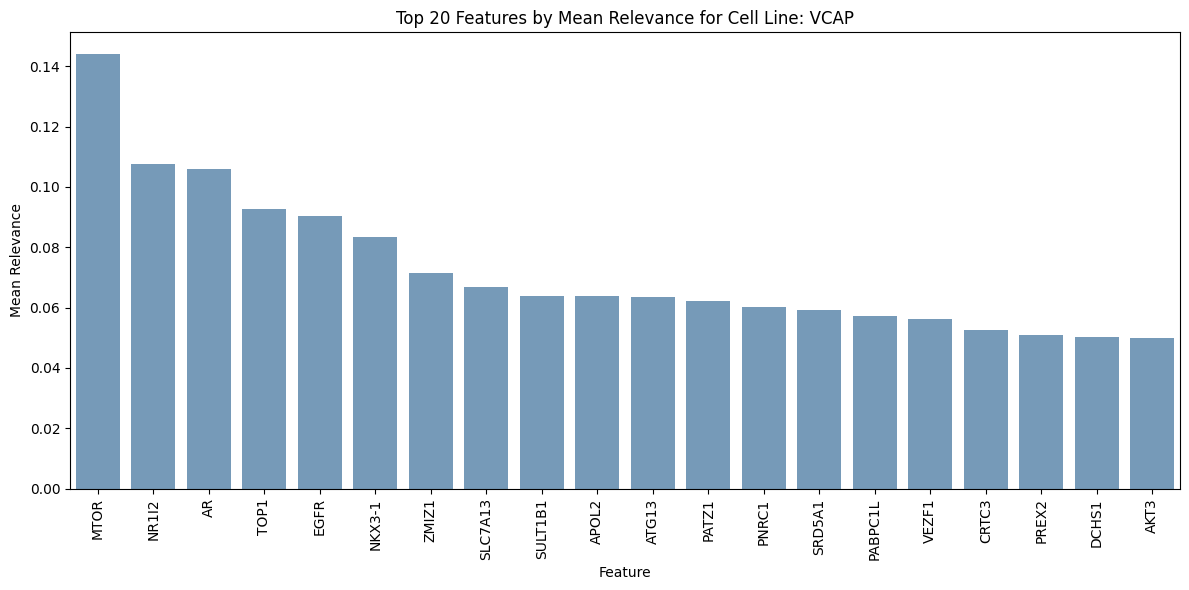

Top 20 Features for Cell Line: ZR751 (Averaged! across relevances o 2 drug pairs)
EGFR: 0.2016
NR1I2: 0.1999
MTOR: 0.1624
AKT1: 0.0949
SULT1B1: 0.0928
SLCO1B1: 0.0924
ATG13: 0.0919
AKT3: 0.0918
NR1H4: 0.0905
ABCG8: 0.0903
TCL1A: 0.0864
AKT2: 0.0854
CRTC3: 0.0820
HNF1A: 0.0819
TPTE2: 0.0813
PREX2: 0.0807
ERBB2: 0.0799
ERBB4: 0.0754
CYP2E1: 0.0742
MAP4K3: 0.0712


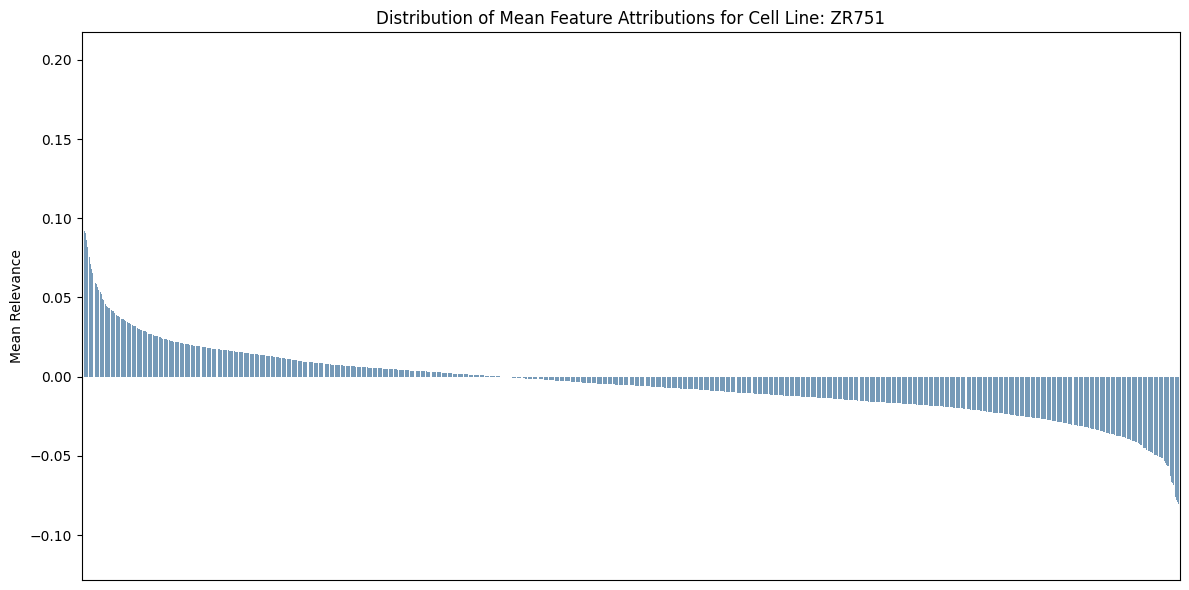

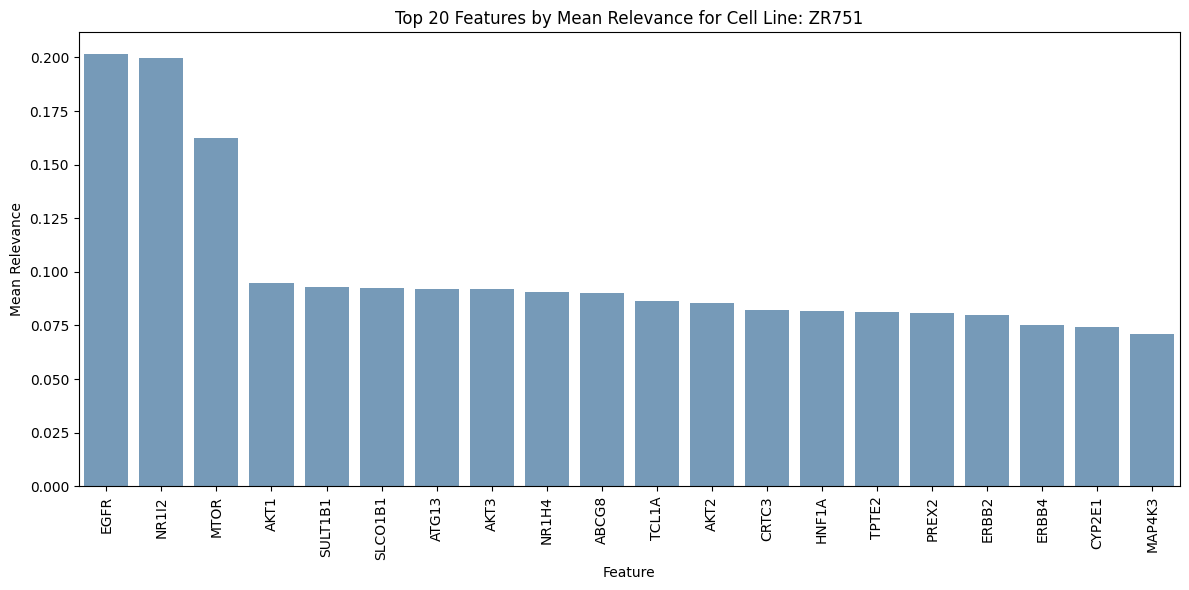

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Iterate over each cell line
cell_line_names = np.unique(cell_line_data)
for cell_line_name in cell_line_names:
    # Filter relevances and reshape for the current cell line
    mask = cell_line_data == cell_line_name
    relevances_filtered = relevances[mask]
    relevances_filtered_reshaped = relevances_filtered.reshape(-1, len(feature_names))
    
    # Stack indices 0-2402 and 2402-4804, then average
    relevances_part_a = relevances_filtered_reshaped[:, :2402]
    relevances_part_b = relevances_filtered_reshaped[:, 2402:4804]
    mean_relevances = np.mean((relevances_part_a + relevances_part_b) / 2, axis=0)
    
    # Sort by amplitude (absolute value of mean relevance)
    sorted_indices = np.argsort(mean_relevances)[::-1]
    top_indices = sorted_indices[:20]
    top_feature_names = np.array(feature_names[:2402])[top_indices]
    top_feature_names = [name.split("_")[0] for name in top_feature_names]  # Remove suffixes
    top_mean_relevances = mean_relevances[top_indices]
    
    # Print the top 20 feature names
    print(f"Top 20 Features for Cell Line: {cell_line_name} (Averaged! across relevances o 2 drug pairs)")
    for name, relevance in zip(top_feature_names, top_mean_relevances):
        print(f"{name}: {relevance:.4f}")
    
    # Create a DataFrame for easier plotting
    mean_relevance_df = pd.DataFrame({
        "Index": np.arange(2402),  # Use indices instead of feature names
        "Mean Relevance": mean_relevances[sorted_indices]
    })
    
    # Plot the distribution of mean feature attributions for the current cell line
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x="Index", 
        y="Mean Relevance", 
        data=mean_relevance_df, 
        color="steelblue", 
        alpha=0.8
    )
    
    # Remove text from x-axis
    plt.xticks([], [])
    plt.xlabel("")
    plt.ylabel("Mean Relevance")
    plt.title(f"Distribution of Mean Feature Attributions for Cell Line: {cell_line_name}")
    plt.tight_layout()
    plt.show()
    
    # Create a DataFrame for easier plotting
    top_features_df = pd.DataFrame({
        "Feature": top_feature_names,
        "Mean Relevance": top_mean_relevances
    })
    
    # Plot the top 20 features
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x="Feature", 
        y="Mean Relevance", 
        data=top_features_df, 
        color="steelblue", 
        alpha=0.8
    )
    
    # Format the x-axis
    plt.xticks(rotation=90)
    plt.xlabel("Feature")
    plt.ylabel("Mean Relevance")
    plt.title(f"Top 20 Features by Mean Relevance for Cell Line: {cell_line_name}")
    plt.tight_layout()
    plt.show()